In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors

%matplotlib inline

In [2]:
plt.style.use('dark_background')

### revisions checklist

- [x] Generate violin plots using Xenium, Cosmx, and Gellyfish for all cells
- [x] Generate violin plots using Xenium, Cosmx, and Gellyfish for overlapping cells
- [x] Generate violin plots using Xenium, Cosmx, and Gellyfish for individual overlapping cells
- [x] Add Cbm5 data into the Gellyfish data
- [x] Determine thresholds for violin plots
- [x] Generate summary for each technology
    - [x] include number of cells
    - [x] include number of genes
    - [x] include number of samples
    - [x] include median
- [x] Generate umaps / brain proj using all genes in each panel
    - [x] use only the filtered cells to generate umap
    - [x] make umap unlabeled
    - [x] include a cell type list for each cluster
    - [x] make sure umap is high resolution
    - [x] generate brain proj with high resolution
- [ ] Generate umaps / brain proj using overlapping genes
    - [ ] use only the filtered cells to generate umap
    - [ ] make umap unlabeled
    - [ ] include a cell type list for each cluster
    - [ ] make sure umap is high resolution
    - [ ] generate brain proj with high resolution
- [ ] Conduct wilcoxon test for every violin plot
- [X] Generate gene overlap list for one on one comparisons

# Xenium Analysis

In [3]:
sample_id_list = ['C3m1', 'C3m2', 'C3m3', 'C24m1', 'C24m2', 'C24m3', 'HD24m1', 'HD24m2', 'HD24m3', 'R61']

In [4]:
concated_cell_csv = pd.DataFrame()
for sample_id in sample_id_list:
    df = pd.read_csv(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\xenium_prerelease_molina_mouse_brain_Mar13\{sample_id}\cells.csv.gz")
    df['sample_id'] = sample_id
    concated_cell_csv = pd.concat([concated_cell_csv, df])

### filter out 0 gene cells

In [5]:
concated_cell_csv_filtered = concated_cell_csv[concated_cell_csv['transcript_counts'] > 0]
concated_cell_csv_filtered

cell_id   x_centroid   y_centroid  transcript_counts  \
0            1  1470.409833  4249.051636                  4   
1            2  1474.557941  4239.123071                 12   
2            3  1474.138440  4230.722266                 34   
3            4  1479.313043  4242.560010                  3   
4            5  1486.422662  4240.159839                  6   
...        ...          ...          ...                ...   
62701    62702  4511.553882   772.796457                  1   
62704    62705  4500.247803   810.598993                  1   
62710    62711  4537.563965   827.317804                  4   
62712    62713  4795.765991   725.019598                  2   
62714    62715  4752.350830   835.528937                  2   

       control_probe_counts  control_codeword_counts  \
0                         0                        0   
1                         0                        0   
2                         0                        0   
3                         0                        0   
4                         0                        0   
...                     ...                      ...   
62701                     0                        0   
62704                     0                        0   
62710                     0                        0   
62712                     0                        0   
62714                     0                        0   

       unassigned_codeword_counts  total_counts   cell_area  nucleus_area  \
0                               0             4  178.186563     44.704687   
1                               0            12   50.439531     29.487031   
2                               0            34  251.430000     54.639063   
3                               0             3   50.665312     23.345781   
4                               0             6   59.199844     29.712812   
...                           ...           ...         ...           ...   
62701                           0             1  831.913594      6.637969   
62704                           0             1  616.021563     26.642187   
62710                           0             4  886.326875     41.814688   
62712                           0             2  987.702656     24.023125   
62714                           0             2  912.743281     15.443437   

      sample_id  
0          C3m1  
1          C3m1  
2          C3m1  
3          C3m1  
4          C3m1  
...         ...  
62701       R61  
62704       R61  
62710       R61  
62712       R61  
62714       R61  

[553305 rows x 11 columns]

In [6]:
xenium_filtered_transcripts = concated_cell_csv_filtered['transcript_counts']
xenium_filtered_transcripts

0         4
1        12
2        34
3         3
4         6
         ..
62701     1
62704     1
62710     4
62712     2
62714     2
Name: transcript_counts, Length: 553305, dtype: int64

In [7]:
print(f'Xenium mean transcript count: {xenium_filtered_transcripts.mean()}')
print(f'Xenium median transcript count: {xenium_filtered_transcripts.median()}')
print(f'Xenium min transcript count: {xenium_filtered_transcripts.min()}')
print(f'Xenium max transcript count: {xenium_filtered_transcripts.max()}')
print(f'Xenium mean ratio: {xenium_filtered_transcripts.mean() / 248}')
print(f'Xenium median ratio: {xenium_filtered_transcripts.median() / 248}')

Xenium mean transcript count: 208.57277089489523
Xenium median transcript count: 178.0
Xenium min transcript count: 1
Xenium max transcript count: 1526
Xenium mean ratio: 0.8410192374794162
Xenium median ratio: 0.717741935483871


Text(0.5, 1.0, 'Xenium - Number of transcripts per cell')

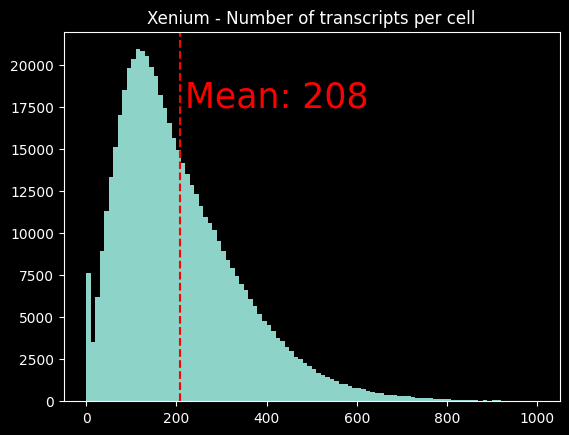

In [8]:
plt.hist(xenium_filtered_transcripts, bins = 100, range = (0, 1000))
plt.axvline(xenium_filtered_transcripts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(220, 17500, f'Mean: {int(xenium_filtered_transcripts.mean())}', color = 'red', fontsize = 25)
#plt.axvline(xenium_transcripts.mean() - xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(380, 25000, f'SD: {int(xenium_transcripts.std())}', color = 'green', fontsize = 15)
#plt.axvline(xenium_transcripts.mean() + xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Xenium - Number of transcripts per cell')

Text(0.5, 1.0, 'Xenium - Number of transcripts per cell')

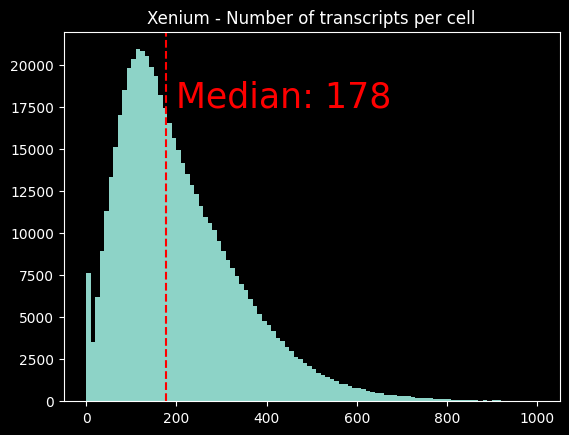

In [9]:
# how can I filter out extreme outliers?
# will this still be necessary if I am finding median

plt.hist(xenium_filtered_transcripts, bins = 100, range = (0, 1000))
plt.axvline(xenium_filtered_transcripts.median(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(200, 17500, f'Median: {int(xenium_filtered_transcripts.median())}', color = 'red', fontsize = 25)
#plt.axvline(xenium_transcripts.mean() - xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(380, 25000, f'SD: {int(xenium_transcripts.std())}', color = 'green', fontsize = 15)
#plt.axvline(xenium_transcripts.mean() + xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Xenium - Number of transcripts per cell')

In [10]:
xenium_violin_plot_df = pd.DataFrame()

In [11]:
xenium_violin_plot_df['transcript_count'] = xenium_filtered_transcripts
xenium_violin_plot_df['technology'] = 'Xenium'

In [12]:
xenium_violin_plot_df

transcript_count technology
0                     4     Xenium
1                    12     Xenium
2                    34     Xenium
3                     3     Xenium
4                     6     Xenium
...                 ...        ...
62701                 1     Xenium
62704                 1     Xenium
62710                 4     Xenium
62712                 2     Xenium
62714                 2     Xenium

[553305 rows x 2 columns]

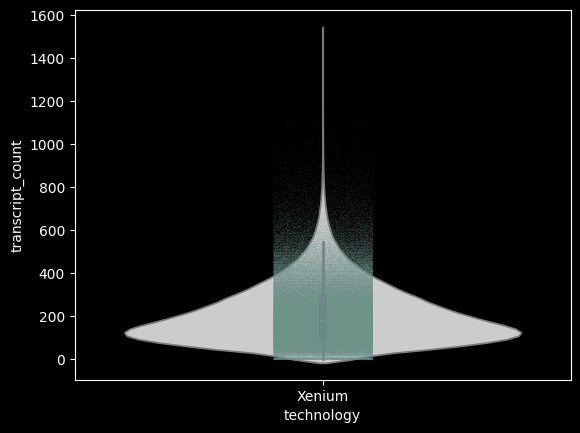

In [13]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = xenium_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = xenium_violin_plot_df, jitter = True, size = 0.15)
plt.show()

In [14]:
# count the number of cells in each section
# should I make a histogram for each section
concated_cell_csv_filtered['sample_id'].value_counts()

HD24m2    65125
R61       62362
HD24m1    57250
C3m2      56154
C24m2     54253
C24m1     53583
C24m3     53459
C3m1      52483
HD24m3    49758
C3m3      48878
Name: sample_id, dtype: int64

# Cosmx Analysis

In [15]:
cosmx_gene_exp = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\5 Raw data\MsBrain_exprMat_file.csv")
cosmx_gene_exp = cosmx_gene_exp.drop(columns = ['fov', 'cell_ID'])
cosmx_gene_exp

Chrna4  Slc6a1  Cd109  Ldha  Aldoc  Drd1  Tank  Rit2  Prkag2  Lpar3  \
0            6      19     11    27    106    17    15    14       6      8   
1            0       0      0     0      0     0     0     0       0      0   
2            0       0      0     0      0     0     0     0       0      0   
3            0       0      0     0      0     0     0     0       0      0   
4            0       0      0     0      0     0     0     0       0      0   
...        ...     ...    ...   ...    ...   ...   ...   ...     ...    ...   
134768       0       0      0     0      1     0     0     0       0      0   
134769       0       0      0     0      0     0     0     0       0      0   
134770       0       1      0     0      3     0     1     0       0      2   
134771       0       0      1     0      0     0     0     0       0      0   
134772       0       0      0     0      0     0     0     0       0      0   

        ...  NegPrb1  NegPrb2  NegPrb3  NegPrb4  NegPrb5  NegPrb6  NegPrb7  \
0       ...        3        1        6        6        7       14        1   
1       ...        0        0        0        0        0        0        0   
2       ...        0        0        0        0        0        0        0   
3       ...        0        0        0        0        0        0        0   
4       ...        0        0        0        0        0        0        0   
...     ...      ...      ...      ...      ...      ...      ...      ...   
134768  ...        0        0        0        0        0        0        0   
134769  ...        0        0        0        0        0        0        0   
134770  ...        0        0        0        0        0        0        0   
134771  ...        0        0        0        0        0        0        0   
134772  ...        0        0        0        0        0        0        0   

        NegPrb8  NegPrb9  NegPrb10  
0             8        5         6  
1             0        0         0  
2             0        0         0  
3             0        0         0  
4             0        0         0  
...         ...      ...       ...  
134768        0        0         0  
134769        0        0         0  
134770        0        0         0  
134771        0        0         0  
134772        0        0         0  

[134773 rows x 960 columns]

In [16]:
cosmx_gene_exp_revised = cosmx_gene_exp.iloc[:, :-10]
cosmx_transcript_counts = cosmx_gene_exp_revised.sum(axis = 1)
cosmx_transcript_counts_filtered = cosmx_transcript_counts[cosmx_transcript_counts != 0]
cosmx_transcript_counts_filtered

0         17818
2            14
3            26
4            12
5           171
          ...  
134768       60
134769       42
134770      308
134771      108
134772      200
Length: 134635, dtype: int64

In [17]:
print(f'Cosmx mean transcript count: {cosmx_transcript_counts_filtered.mean()}')
print(f'Cosmx median transcript count: {cosmx_transcript_counts_filtered.median()}')
print(f'Cosmx min transcript count: {cosmx_transcript_counts_filtered.min()}')
print(f'Cosmx max transcript count: {cosmx_transcript_counts_filtered.max()}')
print(f'Cosmx mean ratio: {cosmx_transcript_counts_filtered.mean() / len(cosmx_gene_exp_revised.columns)}')
print(f'Cosmx median ratio: {cosmx_transcript_counts_filtered.median() / len(cosmx_gene_exp_revised.columns)}')

Cosmx mean transcript count: 524.8502618189921
Cosmx median transcript count: 310.0
Cosmx min transcript count: 1
Cosmx max transcript count: 129447
Cosmx mean ratio: 0.5524739598094653
Cosmx median ratio: 0.3263157894736842


Text(0.5, 1.0, 'Cosmx - Number of transcripts per cell')

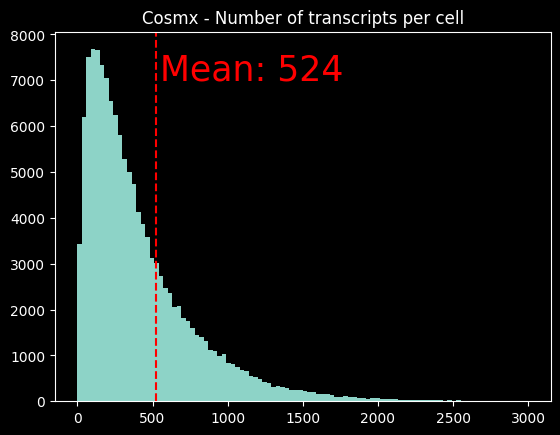

In [18]:
plt.hist(cosmx_transcript_counts_filtered, bins = 100, range = (0, 3000))
plt.axvline(cosmx_transcript_counts_filtered.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(550, 7000, f'Mean: {int(cosmx_transcript_counts_filtered.mean())}', color = 'red', fontsize = 25)
#plt.axvline(xenium_transcripts.mean() - xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(380, 25000, f'SD: {int(xenium_transcripts.std())}', color = 'green', fontsize = 15)
#plt.axvline(xenium_transcripts.mean() + xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cosmx - Number of transcripts per cell')

Text(0.5, 1.0, 'Cosmx - Number of transcripts per cell')

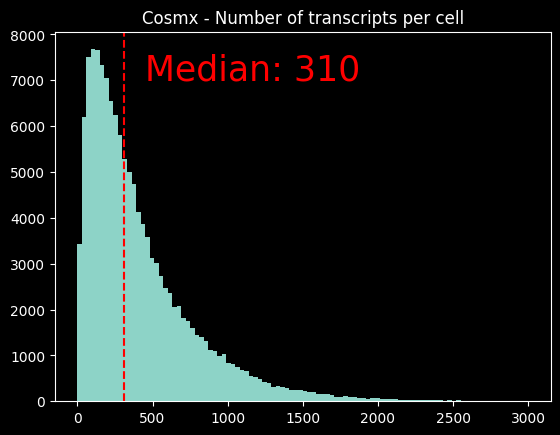

In [19]:
# how can I filter out extreme outliers?
# will this still be necessary if I am finding median

plt.hist(cosmx_transcript_counts_filtered, bins = 100, range = (0, 3000))
plt.axvline(cosmx_transcript_counts_filtered.median(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(450, 7000, f'Median: {int(cosmx_transcript_counts_filtered.median())}', color = 'red', fontsize = 25)
#plt.axvline(xenium_transcripts.mean() - xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(380, 25000, f'SD: {int(xenium_transcripts.std())}', color = 'green', fontsize = 15)
#plt.axvline(xenium_transcripts.mean() + xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cosmx - Number of transcripts per cell')

In [20]:
cosmx_violin_plot_df = pd.DataFrame()

In [21]:
cosmx_violin_plot_df['transcript_count'] = cosmx_transcript_counts_filtered
cosmx_violin_plot_df['technology'] = 'Cosmx'
cosmx_violin_plot_df

transcript_count technology
0                  17818      Cosmx
2                     14      Cosmx
3                     26      Cosmx
4                     12      Cosmx
5                    171      Cosmx
...                  ...        ...
134768                60      Cosmx
134769                42      Cosmx
134770               308      Cosmx
134771               108      Cosmx
134772               200      Cosmx

[134635 rows x 2 columns]

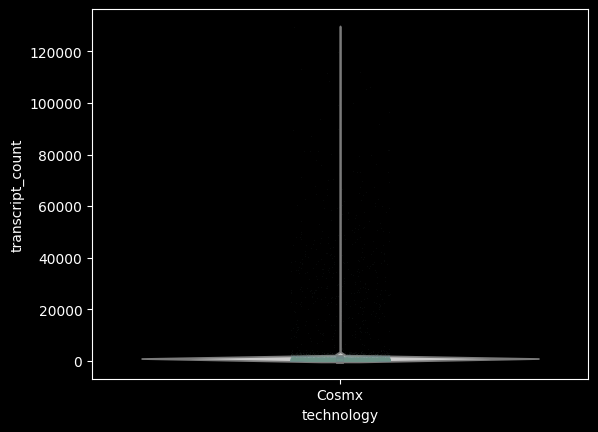

In [22]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = cosmx_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = cosmx_violin_plot_df, jitter = True, size = 0.15)
plt.show()

# Vizgen Analysis

In [23]:
df = pd.read_csv(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Vizgen Analysis\Training Data Set\detected_transcripts.csv")
df['sample_id'] = 0
df_revised = df[df['cell_id'] != -1]
df_revised1 = df_revised.groupby(['cell_id','gene']).count()[['transcript_id']].reset_index()
gene_exp = df_revised1.pivot_table(index='cell_id', columns='gene', values='transcript_id', fill_value=0)
gene_exp

gene                 4732456N10Rik  Ace2  Adora2a  Aldh1l1  Ano3  Aqp4  Ar  \
cell_id                                                                      
2706017100029100017              0     1        0        0     0     0   0   
2706017100030100132              0     0        0        0     0     0   0   
2706017100030100136              0     0        0        0     0     1   0   
2706017100030100137              0     0        0        0     0     0   0   
2706017100030100158              0     0        0        0     0     0   0   
...                            ...   ...      ...      ...   ...   ...  ..   
2706017105046100011              0     0        0        0     0     0   0   
2706017105046100298              0     0        0        0     0     0   0   
2706017105048100113              0     0        0        0     0     0   0   
2706017105049100349              0     0        0        0     0     0   0   
2706017105050100027              0     0        0        0     0     0   0   

gene                 Arhgap36  Avpr1a  Avpr2  ...  Sytl4  Tacr1  Tacr3  \
cell_id                                       ...                        
2706017100029100017         0       0      0  ...      0      0      0   
2706017100030100132         0       0      0  ...      0      0      0   
2706017100030100136         0       0      0  ...      0      0      0   
2706017100030100137         0       0      0  ...      0      0      0   
2706017100030100158         0       0      0  ...      0      0      0   
...                       ...     ...    ...  ...    ...    ...    ...   
2706017105046100011         0       0      0  ...      0      0      0   
2706017105046100298         0       0      0  ...      0      0      0   
2706017105048100113         0       0      0  ...      0      0      0   
2706017105049100349         0       0      0  ...      0      0      0   
2706017105050100027         0       0      0  ...      0      0      0   

gene                 Tiparp  Tmem108  Traf4  Trhr  Ttn  Ttyh2  uc011zyl.1  
cell_id                                                                    
2706017100029100017       0        0      0     0    0      0           0  
2706017100030100132       0        0      0     0    0      0           0  
2706017100030100136       0        0      0     0    0      0           0  
2706017100030100137       0        0      0     0    0      0           0  
2706017100030100158       0        0      0     0    0      0           0  
...                     ...      ...    ...   ...  ...    ...         ...  
2706017105046100011       0        0      0     0    0      0           0  
2706017105046100298       0        0      0     0    0      0           0  
2706017105048100113       0        0      0     0    0      0           0  
2706017105049100349       0        0      0     0    0      0           0  
2706017105050100027       0        0      0     0    0      0           0  

[199644 rows x 140 columns]

In [24]:
list(gene_exp.columns)

['4732456N10Rik',
 'Ace2',
 'Adora2a',
 'Aldh1l1',
 'Ano3',
 'Aqp4',
 'Ar',
 'Arhgap36',
 'Avpr1a',
 'Avpr2',
 'Baiap2',
 'Bdnf',
 'Blank-1',
 'Blank-2',
 'Blank-3',
 'Blank-4',
 'Blank-5',
 'Bmp7',
 'Brs3',
 'Calcr',
 'Cbln1',
 'Cbln2',
 'Cckar',
 'Cckbr',
 'Ccnd2',
 'Cd24a',
 'Cdkn1a',
 'Cenpe',
 'Chat',
 'Coch',
 'Col25a1',
 'Cplx3',
 'Cpne5',
 'Creb3l1',
 'Crhbp',
 'Crhr1',
 'Crhr2',
 'Cspg5',
 'Cxcl14',
 'Cyp19a1',
 'Cyp26a1',
 'Cyr61',
 'Dgkk',
 'Ebf3',
 'Egr2',
 'Ermn',
 'Esr1',
 'Etv1',
 'Fbxw13',
 'Fezf1',
 'Fn1',
 'Fst',
 'Gabra1',
 'Gabrg1',
 'Gad1',
 'Galr1',
 'Galr2',
 'Gbx2',
 'Gda',
 'Gem',
 'Gjc3',
 'Glra3',
 'Gpr165',
 'Greb1',
 'Grpr',
 'Htr2c',
 'Igf1r',
 'Igf2r',
 'Irs4',
 'Isl1',
 'Kiss1r',
 'Klf4',
 'Lepr',
 'Lmod1',
 'Lpar1',
 'Man1a',
 'Mc4r',
 'Mki67',
 'Mlc1',
 'Myh11',
 'Ndnf',
 'Ndrg1',
 'Necab1',
 'Nos1',
 'Npas1',
 'Npy1r',
 'Npy2r',
 'Ntng1',
 'Ntsr1',
 'Nup62cl',
 'Omp',
 'Onecut2',
 'Opalin',
 'Oprd1',
 'Oprk1',
 'Oprl1',
 'Oxtr',
 'Pak3',
 'Pcdh11x',
 

In [25]:
# drop blanks
blank_col = [gene for gene in gene_exp.columns if 'Blank' in gene]
gene_exp = gene_exp.drop(columns = blank_col)
list(gene_exp.columns)

['4732456N10Rik',
 'Ace2',
 'Adora2a',
 'Aldh1l1',
 'Ano3',
 'Aqp4',
 'Ar',
 'Arhgap36',
 'Avpr1a',
 'Avpr2',
 'Baiap2',
 'Bdnf',
 'Bmp7',
 'Brs3',
 'Calcr',
 'Cbln1',
 'Cbln2',
 'Cckar',
 'Cckbr',
 'Ccnd2',
 'Cd24a',
 'Cdkn1a',
 'Cenpe',
 'Chat',
 'Coch',
 'Col25a1',
 'Cplx3',
 'Cpne5',
 'Creb3l1',
 'Crhbp',
 'Crhr1',
 'Crhr2',
 'Cspg5',
 'Cxcl14',
 'Cyp19a1',
 'Cyp26a1',
 'Cyr61',
 'Dgkk',
 'Ebf3',
 'Egr2',
 'Ermn',
 'Esr1',
 'Etv1',
 'Fbxw13',
 'Fezf1',
 'Fn1',
 'Fst',
 'Gabra1',
 'Gabrg1',
 'Gad1',
 'Galr1',
 'Galr2',
 'Gbx2',
 'Gda',
 'Gem',
 'Gjc3',
 'Glra3',
 'Gpr165',
 'Greb1',
 'Grpr',
 'Htr2c',
 'Igf1r',
 'Igf2r',
 'Irs4',
 'Isl1',
 'Kiss1r',
 'Klf4',
 'Lepr',
 'Lmod1',
 'Lpar1',
 'Man1a',
 'Mc4r',
 'Mki67',
 'Mlc1',
 'Myh11',
 'Ndnf',
 'Ndrg1',
 'Necab1',
 'Nos1',
 'Npas1',
 'Npy1r',
 'Npy2r',
 'Ntng1',
 'Ntsr1',
 'Nup62cl',
 'Omp',
 'Onecut2',
 'Opalin',
 'Oprd1',
 'Oprk1',
 'Oprl1',
 'Oxtr',
 'Pak3',
 'Pcdh11x',
 'Pdgfra',
 'Pgr',
 'Plin3',
 'Pnoc',
 'Pou3f2',
 'Prlr',
 'R

In [26]:
vizgen_transcript_counts = gene_exp.sum(axis=1)
vizgen_transcript_counts

cell_id
2706017100029100017     1
2706017100030100132     1
2706017100030100136    26
2706017100030100137     2
2706017100030100158     1
                       ..
2706017105046100011     1
2706017105046100298     1
2706017105048100113     1
2706017105049100349     1
2706017105050100027     1
Length: 199644, dtype: int64

In [27]:
len(gene_exp.columns)

135

In [28]:
print(f'Vizgen mean transcript count: {vizgen_transcript_counts.mean()}')
print(f'Vizgen median transcript count: {vizgen_transcript_counts.median()}')
print(f'Vizgen standard deviation transcript count: {vizgen_transcript_counts.std()}')
print(f'Vizgen max transcript count: {vizgen_transcript_counts.max()}')
print(f'Vizgen mean ratio: {vizgen_transcript_counts.mean() / len(gene_exp.columns)}')
print(f'Vizgen median ratio: {vizgen_transcript_counts.median() / len(gene_exp.columns)}')

Vizgen mean transcript count: 73.18127266534431
Vizgen median transcript count: 23.0
Vizgen standard deviation transcript count: 119.93967112810975
Vizgen max transcript count: 3981
Vizgen mean ratio: 0.5420835012247727
Vizgen median ratio: 0.17037037037037037


Text(0.5, 1.0, 'Vizgen - Number of transcripts per cell')

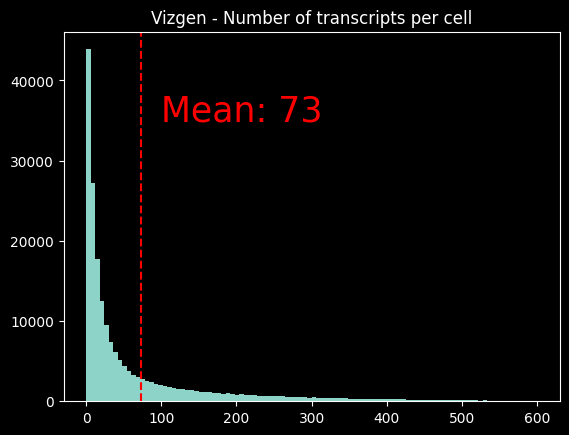

In [29]:
# plot mean histogram
plt.hist(vizgen_transcript_counts, bins = 100, range = (0,600))
plt.axvline(vizgen_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(100, 35000, f'Mean: {int(vizgen_transcript_counts.mean())}', color = 'red', fontsize = 25)
#plt.axvline(cbm2_transcript_counts.mean() - cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(2570, 3500, f'SD: {int(cbm2_transcript_counts.std())}', color = 'green', fontsize = 15)
#plt.axvline(cbm2_transcript_counts.mean() + cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Vizgen - Number of transcripts per cell')

Text(0.5, 1.0, 'Vizgen - Number of transcripts per cell')

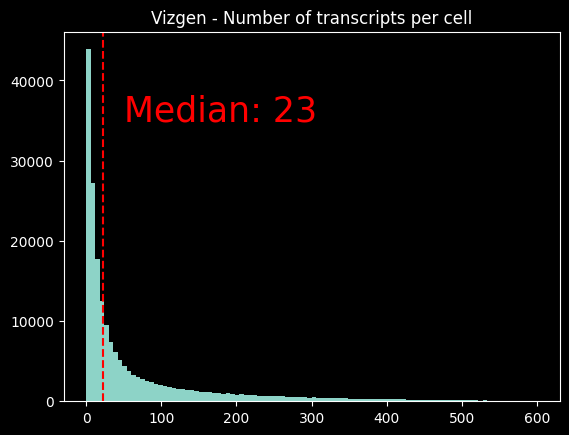

In [30]:
# plot median histogram
plt.hist(vizgen_transcript_counts, bins = 100, range = (0,600))
plt.axvline(vizgen_transcript_counts.median(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(50, 35000, f'Median: {int(vizgen_transcript_counts.median())}', color = 'red', fontsize = 25)
#plt.axvline(cbm2_transcript_counts.mean() - cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(2570, 3500, f'SD: {int(cbm2_transcript_counts.std())}', color = 'green', fontsize = 15)
#plt.axvline(cbm2_transcript_counts.mean() + cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Vizgen - Number of transcripts per cell')

In [31]:
vizgen_violin_plot_df = pd.DataFrame()
vizgen_violin_plot_df['transcript_count'] = vizgen_transcript_counts
vizgen_violin_plot_df['technology'] = 'Vizgen'
vizgen_violin_plot_df

transcript_count technology
cell_id                                         
2706017100029100017                 1     Vizgen
2706017100030100132                 1     Vizgen
2706017100030100136                26     Vizgen
2706017100030100137                 2     Vizgen
2706017100030100158                 1     Vizgen
...                               ...        ...
2706017105046100011                 1     Vizgen
2706017105046100298                 1     Vizgen
2706017105048100113                 1     Vizgen
2706017105049100349                 1     Vizgen
2706017105050100027                 1     Vizgen

[199644 rows x 2 columns]

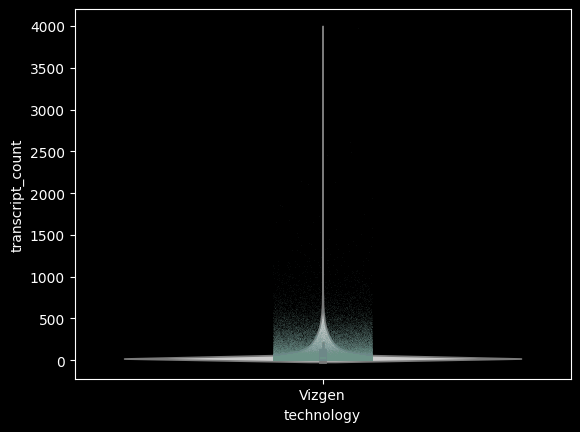

In [32]:
# generate violin plot
sns.violinplot(x = 'technology', y = 'transcript_count', data = vizgen_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = vizgen_violin_plot_df, jitter = True, size = 0.15)
plt.show()

# Gellyfish Analysis

In [33]:
cbm2_cell_df = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\cbm2_single_cell_raw_counts.csv")
cbm2_cell_df = cbm2_cell_df.iloc[:, 1:]
cbm2_cell_df

4930570B17Rik  Abhd2  Acer3  Acta2  Adcy1  Adcy2  Adgrl3  Agt  Ahcyl2  \
0                  0      0      5      6     17      2       6   83       5   
1                  0      0      1      0      5      0      11    0      12   
2                  0     28      0      2      0      0       4    7       2   
3                  0      7      8      5     12      1      42   31      16   
4                  0     15      7      2     10      4      28    0      16   
...              ...    ...    ...    ...    ...    ...     ...  ...     ...   
58187              0      3      0      0      0      0       0    6       0   
58188              0      0      0      0      1      3       0   12       0   
58189              0      1      0      0      0      2       1    0       0   
58190              0      1      0      7      0      0       0    0       0   
58191              0      0      0      0      2      0       0    2       0   

       Aif1l  ...  Unc13b  Unc13c  Unc5c  Vim  Vip  Vps13c  Wdr17  Wfs1  \
0          1  ...       0       5      0    0    0       3      0     3   
1          0  ...       0       1      9    0    0       7      0     6   
2          0  ...       0       5      0   10    0       0      0     1   
3          1  ...       3       3      8    2    0      33      4    15   
4          0  ...       9       0      8    3    0      45      5    11   
...      ...  ...     ...     ...    ...  ...  ...     ...    ...   ...   
58187      0  ...       0       0      0    0    0       0      0     0   
58188      1  ...       0       0      0    0    0       0      0     4   
58189      0  ...       0       0      0    0    0       2      0     1   
58190      0  ...       0       0      0    4    0       0      0     0   
58191      0  ...       0       0      0    0    0       0      0     0   

       Wipf3  Zfp36l1  
0          4       17  
1          0        6  
2          0       14  
3          6        2  
4          8        1  
...      ...      ...  
58187      0        0  
58188      0        0  
58189      0        0  
58190      0        2  
58191      0        1  

[58192 rows x 223 columns]

In [34]:
cbm5_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\CBM5_new_PTB.h5ad")
cbm5_scdata

AnnData object with n_obs × n_vars = 152568 × 223
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'leiden', 'leiden_denovo', 'Experiment', 'Age', 'Section', 'Mouse', 'Treatment', 'Timepoint', 'Ptbp1', 'MERFISH celltype', 'New_PTB'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'Mouse_colors', 'Section_colors', 'Treatment_colors', 'leiden', 'leiden_colors', 'leiden_denovo_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'X_umap_denovo', 'rep'
    varm: 'PCs'
    layers: 'Raw counts'
    obsp: 'connectivities', 'distances'

In [35]:
cbm5_cell_df = pd.DataFrame(cbm5_scdata.layers['Raw counts'], columns = cbm5_scdata.var.index)
cbm5_cell_df

4930570B17Rik  Abhd2  Acer3  Acta2  Adcy1  Adcy2  Adgrl3  Agt  Ahcyl2  \
0                   0      7      2      3     45     16       9    0      18   
1                   0      9      1      2     27     18       7    0       7   
2                   1     15      1      0     57     11       1    1      15   
3                   1     30      2      3     83     14       8    0      27   
4                   0      9      2      3     67     38       9    0      16   
...               ...    ...    ...    ...    ...    ...     ...  ...     ...   
152563              0      0      0      0      3      0       0    0       3   
152564              0      0      0      0     10      6       0    0       0   
152565              0      2      0      0      0      0       0    0       0   
152566              0      4      0      0      0      0       0    0       0   
152567              0      0      0      0      3      1       0    0       0   

        Aif1l  ...  Unc13b  Unc13c  Unc5c  Vim  Vip  Vps13c  Wdr17  Wfs1  \
0           0  ...       2       0      1    0    0      19      1     0   
1           0  ...       3       2      5    0    1       8      0     5   
2           0  ...       5       3      1    2    0       6      0     2   
3           0  ...       9       8      0    3    0      17      4     3   
4           0  ...       1       5      7    0    0      24      2     6   
...       ...  ...     ...     ...    ...  ...  ...     ...    ...   ...   
152563      0  ...       0       0      0    0    0       1      0     0   
152564      0  ...       0       0      0    0    0       0      1     0   
152565      0  ...       0       0      0    0    0       0      2     0   
152566      0  ...       0       0      0    1    0       0      0     0   
152567      0  ...       0       0      0    0    0       0      0     0   

        Wipf3  Zfp36l1  
0          20        0  
1           5        7  
2          13        0  
3          17        3  
4          11        5  
...       ...      ...  
152563      0        0  
152564      2        1  
152565      0        0  
152566      0        9  
152567      0        0  

[152568 rows x 223 columns]

In [36]:
gellyfish_cell_df = pd.concat([cbm2_cell_df, cbm5_cell_df], ignore_index = True)
gellyfish_cell_df

4930570B17Rik  Abhd2  Acer3  Acta2  Adcy1  Adcy2  Adgrl3  Agt  Ahcyl2  \
0                   0      0      5      6     17      2       6   83       5   
1                   0      0      1      0      5      0      11    0      12   
2                   0     28      0      2      0      0       4    7       2   
3                   0      7      8      5     12      1      42   31      16   
4                   0     15      7      2     10      4      28    0      16   
...               ...    ...    ...    ...    ...    ...     ...  ...     ...   
210755              0      0      0      0      3      0       0    0       3   
210756              0      0      0      0     10      6       0    0       0   
210757              0      2      0      0      0      0       0    0       0   
210758              0      4      0      0      0      0       0    0       0   
210759              0      0      0      0      3      1       0    0       0   

        Aif1l  ...  Unc13b  Unc13c  Unc5c  Vim  Vip  Vps13c  Wdr17  Wfs1  \
0           1  ...       0       5      0    0    0       3      0     3   
1           0  ...       0       1      9    0    0       7      0     6   
2           0  ...       0       5      0   10    0       0      0     1   
3           1  ...       3       3      8    2    0      33      4    15   
4           0  ...       9       0      8    3    0      45      5    11   
...       ...  ...     ...     ...    ...  ...  ...     ...    ...   ...   
210755      0  ...       0       0      0    0    0       1      0     0   
210756      0  ...       0       0      0    0    0       0      1     0   
210757      0  ...       0       0      0    0    0       0      2     0   
210758      0  ...       0       0      0    1    0       0      0     0   
210759      0  ...       0       0      0    0    0       0      0     0   

        Wipf3  Zfp36l1  
0           4       17  
1           0        6  
2           0       14  
3           6        2  
4           8        1  
...       ...      ...  
210755      0        0  
210756      2        1  
210757      0        0  
210758      0        9  
210759      0        0  

[210760 rows x 223 columns]

In [37]:
gellyfish_transcript_counts = gellyfish_cell_df.sum(axis=1)
gellyfish_transcript_counts_revised = gellyfish_transcript_counts[gellyfish_transcript_counts != 0]
gellyfish_transcript_counts_revised

0         1788
1         1018
2          959
3         3963
4         2720
          ... 
210755     168
210756     228
210757      80
210758     123
210759      55
Length: 210759, dtype: int64

In [38]:
print(f'Gellyfish mean transcript count: {gellyfish_transcript_counts_revised.mean()}')
print(f'Gellyfish median transcript count: {gellyfish_transcript_counts_revised.median()}')
print(f'Gellyfish min transcript count: {gellyfish_transcript_counts_revised.min()}')
print(f'Gellyfish max transcript count: {gellyfish_transcript_counts_revised.max()}')
print(f'Gellyfish mean ratio: {gellyfish_transcript_counts_revised.mean() / len(gellyfish_cell_df.columns)}')
print(f'Gellyfish median ratio: {gellyfish_transcript_counts_revised.median() / len(gellyfish_cell_df.columns)}')

Gellyfish mean transcript count: 1274.7540176220232
Gellyfish median transcript count: 1075.0
Gellyfish min transcript count: 1
Gellyfish max transcript count: 8758
Gellyfish mean ratio: 5.716385729246741
Gellyfish median ratio: 4.820627802690583


Text(0.5, 1.0, 'Gellyfish - Number of transcripts per cell')

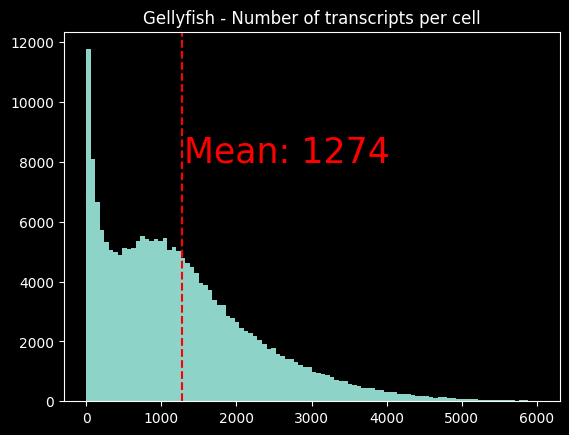

In [39]:
plt.hist(gellyfish_transcript_counts_revised, bins = 100, range = (0,6000))
plt.axvline(gellyfish_transcript_counts_revised.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(1300, 8000, f'Mean: {int(gellyfish_transcript_counts_revised.mean())}', color = 'red', fontsize = 25)
#plt.axvline(cbm2_transcript_counts.mean() - cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(2570, 3500, f'SD: {int(cbm2_transcript_counts.std())}', color = 'green', fontsize = 15)
#plt.axvline(cbm2_transcript_counts.mean() + cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Gellyfish - Number of transcripts per cell')

Text(0.5, 1.0, 'Gellyfish - Number of transcripts per cell')

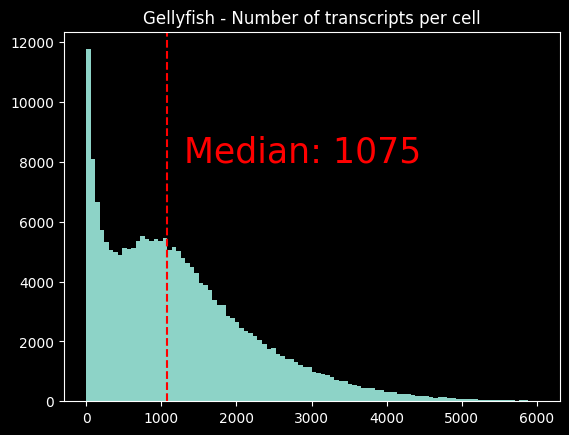

In [40]:
plt.hist(gellyfish_transcript_counts_revised, bins = 100, range = (0,6000))
plt.axvline(gellyfish_transcript_counts_revised.median(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(1300, 8000, f'Median: {int(gellyfish_transcript_counts_revised.median())}', color = 'red', fontsize = 25)
#plt.axvline(cbm2_transcript_counts.mean() - cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(2570, 3500, f'SD: {int(cbm2_transcript_counts.std())}', color = 'green', fontsize = 15)
#plt.axvline(cbm2_transcript_counts.mean() + cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Gellyfish - Number of transcripts per cell')

In [41]:
gellyfish_violin_plot_df = pd.DataFrame()

In [42]:
gellyfish_violin_plot_df['transcript_count'] = gellyfish_transcript_counts_revised
gellyfish_violin_plot_df['technology'] = 'Gellyfish'
gellyfish_violin_plot_df

transcript_count technology
0                   1788  Gellyfish
1                   1018  Gellyfish
2                    959  Gellyfish
3                   3963  Gellyfish
4                   2720  Gellyfish
...                  ...        ...
210755               168  Gellyfish
210756               228  Gellyfish
210757                80  Gellyfish
210758               123  Gellyfish
210759                55  Gellyfish

[210759 rows x 2 columns]

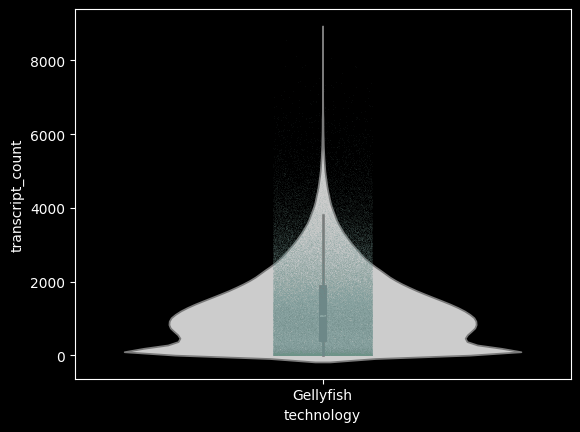

In [43]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = gellyfish_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = gellyfish_violin_plot_df, jitter = True, size = 0.15)
plt.show()

### Generate violin plot for all genes

In [44]:
concated_violin_plot_df = pd.DataFrame()

In [45]:
concated_violin_plot_df = pd.concat([xenium_violin_plot_df, cosmx_violin_plot_df, vizgen_violin_plot_df, gellyfish_violin_plot_df], ignore_index = True)
concated_violin_plot_df

transcript_count technology
0                       4     Xenium
1                      12     Xenium
2                      34     Xenium
3                       3     Xenium
4                       6     Xenium
...                   ...        ...
1098338               168  Gellyfish
1098339               228  Gellyfish
1098340                80  Gellyfish
1098341               123  Gellyfish
1098342                55  Gellyfish

[1098343 rows x 2 columns]

In [46]:
concated_violin_plot_df_revised = concated_violin_plot_df[concated_violin_plot_df['transcript_count'] <= 7000]
concated_violin_plot_df_revised

transcript_count technology
0                       4     Xenium
1                      12     Xenium
2                      34     Xenium
3                       3     Xenium
4                       6     Xenium
...                   ...        ...
1098338               168  Gellyfish
1098339               228  Gellyfish
1098340                80  Gellyfish
1098341               123  Gellyfish
1098342                55  Gellyfish

[1097928 rows x 2 columns]

C:\Users\krist\AppData\Local\Temp\ipykernel_26192\3838624476.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_violin_plot_df_revised, color = '0.8', palette = "tab10")


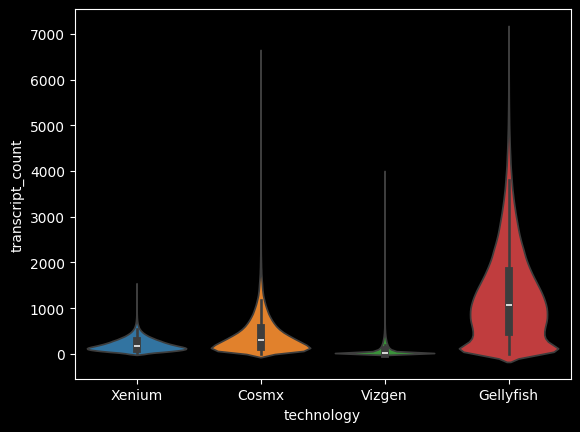

In [47]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_violin_plot_df_revised, color = '0.8', palette = "tab10")
#sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_violin_plot_df_revised, jitter = True, size = 0.15)
plt.show()

###  Transcripts per cell per gene panel size

In [48]:
xenium_violin_plot_df_gene = xenium_violin_plot_df.copy()
xenium_violin_plot_df_gene['transcript_count'] /= 248
cosmx_violin_plot_df_gene = cosmx_violin_plot_df.copy()
cosmx_violin_plot_df_gene['transcript_count'] /= 950
vizgen_violin_plot_df_gene = vizgen_violin_plot_df.copy()
vizgen_violin_plot_df_gene['transcript_count'] /= 135
gellyfish_violin_plot_df_gene = gellyfish_violin_plot_df.copy()
gellyfish_violin_plot_df_gene['transcript_count'] /= 223

In [49]:
concated_violin_plot_df_gene = pd.DataFrame()
concated_violin_plot_df_gene = pd.concat([xenium_violin_plot_df_gene, cosmx_violin_plot_df_gene, vizgen_violin_plot_df_gene, gellyfish_violin_plot_df_gene], ignore_index = True)
concated_violin_plot_df_gene

transcript_count technology
0                0.016129     Xenium
1                0.048387     Xenium
2                0.137097     Xenium
3                0.012097     Xenium
4                0.024194     Xenium
...                   ...        ...
1098338          0.753363  Gellyfish
1098339          1.022422  Gellyfish
1098340          0.358744  Gellyfish
1098341          0.551570  Gellyfish
1098342          0.246637  Gellyfish

[1098343 rows x 2 columns]

In [50]:
concated_violin_plot_df_gene_revised = concated_violin_plot_df_gene[concated_violin_plot_df_gene['transcript_count'] <= 25]
concated_violin_plot_df_gene_revised

transcript_count technology
0                0.016129     Xenium
1                0.048387     Xenium
2                0.137097     Xenium
3                0.012097     Xenium
4                0.024194     Xenium
...                   ...        ...
1098338          0.753363  Gellyfish
1098339          1.022422  Gellyfish
1098340          0.358744  Gellyfish
1098341          0.551570  Gellyfish
1098342          0.246637  Gellyfish

[1097700 rows x 2 columns]

C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2840398491.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_violin_plot_df_gene_revised, color = '0.8', palette = "tab10")


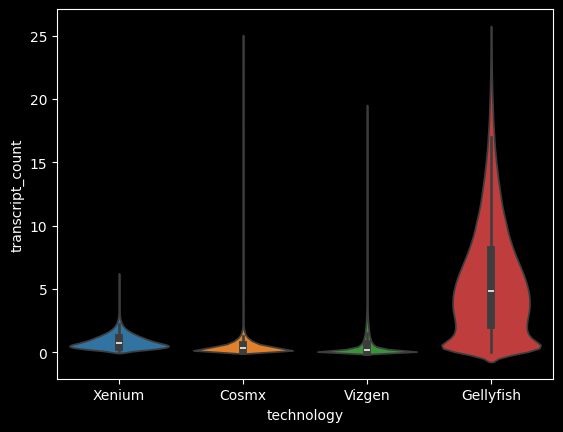

Xenium mean number of genes per cell per gene panel size 0.8410192374794162
Xenium median number of genes per cell per gene panel size 0.717741935483871
Cosmx mean number of genes per cell per gene panel size 0.4547366854216904
Cosmx median number of genes per cell per gene panel size 0.32526315789473687
Vizgen mean number of genes per cell per gene panel size 0.5419385083856164
Vizgen median number of genes per cell per gene panel size 0.17037037037037037
Gellyfish mean number of genes per cell per gene panel size 5.677473591180796
Gellyfish median number of genes per cell per gene panel size 4.811659192825112


In [51]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_violin_plot_df_gene_revised, color = '0.8', palette = "tab10")
#sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_violin_plot_df_revised, jitter = True, size = 0.15)
plt.show()
print (f'Xenium mean number of genes per cell per gene panel size', concated_violin_plot_df_gene_revised[concated_violin_plot_df_gene_revised['technology'] == 'Xenium']['transcript_count'].mean())
print (f'Xenium median number of genes per cell per gene panel size', concated_violin_plot_df_gene_revised[concated_violin_plot_df_gene_revised['technology'] == 'Xenium']['transcript_count'].median())
print (f'Cosmx mean number of genes per cell per gene panel size', concated_violin_plot_df_gene_revised[concated_violin_plot_df_gene_revised['technology'] == 'Cosmx']['transcript_count'].mean())
print (f'Cosmx median number of genes per cell per gene panel size', concated_violin_plot_df_gene_revised[concated_violin_plot_df_gene_revised['technology'] == 'Cosmx']['transcript_count'].median())
print (f'Vizgen mean number of genes per cell per gene panel size', concated_violin_plot_df_gene_revised[concated_violin_plot_df_gene_revised['technology'] == 'Vizgen']['transcript_count'].mean())
print (f'Vizgen median number of genes per cell per gene panel size', concated_violin_plot_df_gene_revised[concated_violin_plot_df_gene_revised['technology'] == 'Vizgen']['transcript_count'].median())
print (f'Gellyfish mean number of genes per cell per gene panel size', concated_violin_plot_df_gene_revised[concated_violin_plot_df_gene_revised['technology'] == 'Gellyfish']['transcript_count'].mean())
print (f'Gellyfish median number of genes per cell per gene panel size', concated_violin_plot_df_gene_revised[concated_violin_plot_df_gene_revised['technology'] == 'Gellyfish']['transcript_count'].median())

### Technology summary: all genes

In [52]:
print (f'Xenium number of cells:', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Xenium'].shape[0])
print(f'Xenium number of genes:', 248)
print (f'Xenium number of samples:', len(concated_cell_csv_filtered['sample_id'].unique()))
print (f'Xenium mean number of genes per cell', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Xenium']['transcript_count'].mean())
print (f'Xenium median number of genes per cell', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Xenium']['transcript_count'].median())
print(f'Xenium mean ratio: ', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Xenium']['transcript_count'].mean() / 248)
print(f'Xenium median ratio: ', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Xenium']['transcript_count'].median() / 248)

Xenium number of cells: 553305
Xenium number of genes: 248
Xenium number of samples: 10
Xenium mean number of genes per cell 208.57277089489523
Xenium median number of genes per cell 178.0
Xenium mean ratio:  0.8410192374794162
Xenium median ratio:  0.717741935483871


In [53]:
print (f'Cosmx number of cells:', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Cosmx'].shape[0])
print(f'Cosmx number of genes:', cosmx_gene_exp_revised.shape[1])
print (f'Cosmx number of samples:', 4)
print (f'Cosmx mean number of genes per cell', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Cosmx']['transcript_count'].mean())
print (f'Cosmx median number of genes per cell', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Cosmx']['transcript_count'].median())
print(f'Cosmx mean ratio: ', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Cosmx']['transcript_count'].mean() / len(cosmx_gene_exp_revised.columns))
print(f'Cosmx median ratio: ', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Cosmx']['transcript_count'].median() / len(cosmx_gene_exp_revised.columns))

Cosmx number of cells: 134256
Cosmx number of genes: 950
Cosmx number of samples: 4
Cosmx mean number of genes per cell 419.57175843165294
Cosmx median number of genes per cell 309.0
Cosmx mean ratio:  0.4416544825596347
Cosmx median ratio:  0.32526315789473687


In [54]:
print (f'Vizgen number of cells:', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Vizgen'].shape[0])
print(f'Vizgen number of genes:', gene_exp.shape[1])
print (f'Vizgen number of samples:', 1)
print (f'Vizgen mean number of genes per cell', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Vizgen']['transcript_count'].mean())
print (f'Vizgen median number of genes per cell', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Vizgen']['transcript_count'].median())
print(f'Vizgen mean ratio: ', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Vizgen']['transcript_count'].mean() / len(gene_exp.columns))
print(f'Vizgen median ratio: ', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Vizgen']['transcript_count'].median() / len(gene_exp.columns))

Vizgen number of cells: 199644
Vizgen number of genes: 135
Vizgen number of samples: 1
Vizgen mean number of genes per cell 73.18127266534431
Vizgen median number of genes per cell 23.0
Vizgen mean ratio:  0.5420835012247727
Vizgen median ratio:  0.17037037037037037


In [55]:
print (f'Gellyfish number of cells:', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Gellyfish'].shape[0])
print(f'Gellyfish number of genes:', gellyfish_cell_df.shape[1])
print (f'Gellyfish number of samples:', 5)
print (f'Gellyfish mean number of genes per cell', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Gellyfish']['transcript_count'].mean())
print (f'Gellyfish median number of genes per cell', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Gellyfish']['transcript_count'].median())
print(f'Gellyfish mean ratio: ', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Gellyfish']['transcript_count'].mean() / len(gellyfish_cell_df.columns))
print(f'Gellyfish median ratio: ', concated_violin_plot_df_revised[concated_violin_plot_df_revised['technology'] == 'Gellyfish']['transcript_count'].median() / len(gellyfish_cell_df.columns))

Gellyfish number of cells: 210723
Gellyfish number of genes: 223
Gellyfish number of samples: 5
Gellyfish mean number of genes per cell 1273.6963454392733
Gellyfish median number of genes per cell 1075.0
Gellyfish mean ratio:  5.711642804660419
Gellyfish median ratio:  4.820627802690583


# Overlapping genes for all technologies

In [56]:
xenium_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Xenium_mouse_filtered.h5ad")
xenium_scdata

AnnData object with n_obs × n_vars = 547139 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names', 'celltype'
    uns: 'Sample ID_colors', 'cell_id_colors', 'celltype_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [57]:
gene_exp

gene                 4732456N10Rik  Ace2  Adora2a  Aldh1l1  Ano3  Aqp4  Ar  \
cell_id                                                                      
2706017100029100017              0     1        0        0     0     0   0   
2706017100030100132              0     0        0        0     0     0   0   
2706017100030100136              0     0        0        0     0     1   0   
2706017100030100137              0     0        0        0     0     0   0   
2706017100030100158              0     0        0        0     0     0   0   
...                            ...   ...      ...      ...   ...   ...  ..   
2706017105046100011              0     0        0        0     0     0   0   
2706017105046100298              0     0        0        0     0     0   0   
2706017105048100113              0     0        0        0     0     0   0   
2706017105049100349              0     0        0        0     0     0   0   
2706017105050100027              0     0        0        0     0     0   0   

gene                 Arhgap36  Avpr1a  Avpr2  ...  Sytl4  Tacr1  Tacr3  \
cell_id                                       ...                        
2706017100029100017         0       0      0  ...      0      0      0   
2706017100030100132         0       0      0  ...      0      0      0   
2706017100030100136         0       0      0  ...      0      0      0   
2706017100030100137         0       0      0  ...      0      0      0   
2706017100030100158         0       0      0  ...      0      0      0   
...                       ...     ...    ...  ...    ...    ...    ...   
2706017105046100011         0       0      0  ...      0      0      0   
2706017105046100298         0       0      0  ...      0      0      0   
2706017105048100113         0       0      0  ...      0      0      0   
2706017105049100349         0       0      0  ...      0      0      0   
2706017105050100027         0       0      0  ...      0      0      0   

gene                 Tiparp  Tmem108  Traf4  Trhr  Ttn  Ttyh2  uc011zyl.1  
cell_id                                                                    
2706017100029100017       0        0      0     0    0      0           0  
2706017100030100132       0        0      0     0    0      0           0  
2706017100030100136       0        0      0     0    0      0           0  
2706017100030100137       0        0      0     0    0      0           0  
2706017100030100158       0        0      0     0    0      0           0  
...                     ...      ...    ...   ...  ...    ...         ...  
2706017105046100011       0        0      0     0    0      0           0  
2706017105046100298       0        0      0     0    0      0           0  
2706017105048100113       0        0      0     0    0      0           0  
2706017105049100349       0        0      0     0    0      0           0  
2706017105050100027       0        0      0     0    0      0           0  

[199644 rows x 135 columns]

In [58]:
xenium_gene_df = pd.DataFrame({'genes': xenium_scdata.var.index})
cosmx_gene_df = pd.DataFrame({'genes': cosmx_gene_exp_revised.columns})
vizgen_gene_df = pd.DataFrame({'genes': gene_exp.columns})
cbm2_gene_df = pd.DataFrame({'genes': gellyfish_cell_df.columns})

In [59]:
gene_overlap_df = xenium_gene_df.merge(cosmx_gene_df, on = 'genes').merge(cbm2_gene_df, on = 'genes').merge(vizgen_gene_df, on = 'genes')
gene_overlap_df

genes
0    Aqp4
1    Bdnf
2    Gad1
3   Npy2r
4  Pdgfra

In [60]:
list(gene_overlap_df['genes'])

['Aqp4', 'Bdnf', 'Gad1', 'Npy2r', 'Pdgfra']

### Overlapping genes - Xenium and Gellyfish

In [61]:
gene_overlap_df_xenium = xenium_gene_df.merge(cbm2_gene_df, on = 'genes')
print(list(gene_overlap_df_xenium['genes']))
print(f'Number of genes: {gene_overlap_df_xenium.shape[0]}')

['Acta2', 'Aqp4', 'Bdnf', 'Calb1', 'Cdh13', 'Cldn5', 'Cntnap5b', 'Cspg4', 'Fos', 'Gad1', 'Gfap', 'Gpr17', 'Inpp4b', 'Laptm5', 'Mapk4', 'Ndst4', 'Nell1', 'Neurod6', 'Npy2r', 'Opalin', 'Pdgfra', 'Prox1', 'Rasl10a', 'Sema3a', 'Slit2', 'Sox10', 'Sox11', 'Unc13c', 'Vip', 'Wfs1']
Number of genes: 30


### Overlapping genes - Cosmx and Gellyfish

In [62]:
gene_overlap_df_cosmx = cosmx_gene_df.merge(cbm2_gene_df, on = 'genes')
print(list(gene_overlap_df_cosmx['genes']))
print(f'Number of genes: {gene_overlap_df_cosmx.shape[0]}')

['Aldoc', 'Unc5c', 'Gnb1', 'Slit2', 'Bcl2', 'Pde10a', 'Atp1b1', 'Nnat', 'Rtn4', 'Cd74', 'Pdgfra', 'Reln', 'Slc1a2', 'Adcy2', 'Mcu', 'Htt', 'Slc2a1', 'Gad1', 'Gabra2', 'S100b', 'Adcy1', 'Ntrk2', 'Kcnd2', 'Vip', 'Cldn5', 'Rbfox3', 'Calb1', 'Dgkb', 'Olig2', 'Atp1a2', 'Synpr', 'Scd2', 'Acer3', 'Fyn', 'Tardbp', 'Bsg', 'Fxyd6', 'Ptgds', 'Casp3', 'Olig1', 'Npy2r', 'Thy1', 'Gja1', 'Fos', 'C1qa', 'Gpr17', 'Slc1a3', 'Acta2', 'Sox9', 'Gfap', 'Mfge8', 'Cd14', 'Vim', 'Trim2', 'Dcc', 'Prkg1', 'Mertk', 'Adgrl3', 'Efna5', 'Flt1', 'Bdnf', 'Slc5a7', 'Agt', 'Eif4a2', 'Pde1a', 'Cspg5', 'Tgfb1', 'Robo1', 'Psap', 'Sgk1', 'Gpm6a', 'Auts2', 'Aqp4']
Number of genes: 73


### Overlapping genes - Vizgen and Gellyfish

In [63]:
gene_overlap_df_vizgen = vizgen_gene_df.merge(cbm2_gene_df, on = 'genes')
print(list(gene_overlap_df_vizgen['genes']))
print(f'Number of genes: {gene_overlap_df_vizgen.shape[0]}')

['Aqp4', 'Bdnf', 'Cspg5', 'Gabra1', 'Gad1', 'Gda', 'Mki67', 'Npy2r', 'Ntng1', 'Opalin', 'Pdgfra', 'Pnoc', 'Pou3f2', 'Sgk1', 'Synpr', 'Tmem108']
Number of genes: 16


In [64]:
gene_overlap_list = ['Aqp4', 'Bdnf', 'Gad1', 'Npy2r', 'Pdgfra']

# Xenium overlap

In [65]:
xenium_cell_df = pd.DataFrame(columns = xenium_scdata.var.index)
for sample in sample_id_list:
    mtx = sc.read_10x_h5(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\xenium_prerelease_molina_mouse_brain_Mar13\{sample}\cell_feature_matrix.h5")
    xenium_cell_df = pd.concat([xenium_cell_df, pd.DataFrame(mtx.X.toarray(), columns = xenium_scdata.var.index)], ignore_index = True)

In [66]:
xenium_overlap = xenium_cell_df.loc[:, [gene for gene in xenium_cell_df.columns if gene in gene_overlap_list]]
xenium_overlap_filtered = xenium_overlap[xenium_overlap.sum(axis = 1) != 0]
xenium_overlap_filtered

Aqp4  Bdnf  Gad1  Npy2r  Pdgfra
7        0.0   0.0  10.0    0.0     0.0
8        1.0   0.0   0.0    0.0     0.0
11       0.0   0.0   1.0    0.0     0.0
18       1.0   0.0   1.0    0.0     0.0
20       2.0   3.0   0.0    0.0    10.0
...      ...   ...   ...    ...     ...
556311   0.0   0.0   8.0    0.0     0.0
556312   4.0   0.0   6.0    0.0     0.0
556313   0.0   0.0   3.0    0.0     0.0
556314   0.0   0.0   5.0    0.0     0.0
556325   0.0   0.0   0.0    1.0     0.0

[473377 rows x 5 columns]

In [67]:
cosmx_overlap = cosmx_gene_exp_revised.loc[:, [gene for gene in cosmx_gene_exp_revised.columns if gene in gene_overlap_list]]
cosmx_overlap_filtered = cosmx_overlap[cosmx_overlap.sum(axis=1) != 0]
cosmx_overlap_filtered

Pdgfra  Gad1  Npy2r  Bdnf  Aqp4
0            6    22     12    15    34
6            1     0      0     0     0
11           1     0      0     0     1
14           1     0      0     0     0
17           0     0      1     0     0
...        ...   ...    ...   ...   ...
134756       0     0      0     0     1
134760       0     1      0     1     0
134764       0     1      0     0     0
134770       1     0      0     0     0
134772       0     1      0     0     0

[77194 rows x 5 columns]

In [68]:
gene_exp

gene                 4732456N10Rik  Ace2  Adora2a  Aldh1l1  Ano3  Aqp4  Ar  \
cell_id                                                                      
2706017100029100017              0     1        0        0     0     0   0   
2706017100030100132              0     0        0        0     0     0   0   
2706017100030100136              0     0        0        0     0     1   0   
2706017100030100137              0     0        0        0     0     0   0   
2706017100030100158              0     0        0        0     0     0   0   
...                            ...   ...      ...      ...   ...   ...  ..   
2706017105046100011              0     0        0        0     0     0   0   
2706017105046100298              0     0        0        0     0     0   0   
2706017105048100113              0     0        0        0     0     0   0   
2706017105049100349              0     0        0        0     0     0   0   
2706017105050100027              0     0        0        0     0     0   0   

gene                 Arhgap36  Avpr1a  Avpr2  ...  Sytl4  Tacr1  Tacr3  \
cell_id                                       ...                        
2706017100029100017         0       0      0  ...      0      0      0   
2706017100030100132         0       0      0  ...      0      0      0   
2706017100030100136         0       0      0  ...      0      0      0   
2706017100030100137         0       0      0  ...      0      0      0   
2706017100030100158         0       0      0  ...      0      0      0   
...                       ...     ...    ...  ...    ...    ...    ...   
2706017105046100011         0       0      0  ...      0      0      0   
2706017105046100298         0       0      0  ...      0      0      0   
2706017105048100113         0       0      0  ...      0      0      0   
2706017105049100349         0       0      0  ...      0      0      0   
2706017105050100027         0       0      0  ...      0      0      0   

gene                 Tiparp  Tmem108  Traf4  Trhr  Ttn  Ttyh2  uc011zyl.1  
cell_id                                                                    
2706017100029100017       0        0      0     0    0      0           0  
2706017100030100132       0        0      0     0    0      0           0  
2706017100030100136       0        0      0     0    0      0           0  
2706017100030100137       0        0      0     0    0      0           0  
2706017100030100158       0        0      0     0    0      0           0  
...                     ...      ...    ...   ...  ...    ...         ...  
2706017105046100011       0        0      0     0    0      0           0  
2706017105046100298       0        0      0     0    0      0           0  
2706017105048100113       0        0      0     0    0      0           0  
2706017105049100349       0        0      0     0    0      0           0  
2706017105050100027       0        0      0     0    0      0           0  

[199644 rows x 135 columns]

In [69]:
vizgen_overlap = gene_exp.loc[:, [gene for gene in gene_exp.columns if gene in gene_overlap_list]]
vizgen_overlap_filtered = vizgen_overlap[vizgen_overlap.sum(axis=1) != 0]
vizgen_overlap_filtered

gene                 Aqp4  Bdnf  Gad1  Npy2r  Pdgfra
cell_id                                             
2706017100030100136     1     0     0      0       0
2706017100086100044     0     0     0      0       1
2706017100088100388     0     0     1      0       0
2706017100145100184     1     0     0      0       0
2706017100146100019     0     0     0      1       0
...                   ...   ...   ...    ...     ...
2706017104880100113     0     0     0      0       1
2706017104886100028     0     0     2      0       0
2706017104935100001    35     0     0      1      33
2706017104991100417     0     0     0      0       1
2706017104993100347     0     0     1      0       0

[119568 rows x 5 columns]

In [70]:
gellyfish_overlap = gellyfish_cell_df.loc[:, [gene for gene in cbm2_cell_df.columns if gene in gene_overlap_list]]
gellyfish_overlap_filtered = gellyfish_overlap[gellyfish_overlap.sum(axis=1) != 0]
gellyfish_overlap_filtered

Aqp4  Bdnf  Gad1  Npy2r  Pdgfra
0         17     0     0      0       0
1          0     0     0      2       0
2          1     1     0      1       0
3          3     7     1      2       3
4          0     4     0     14       2
...      ...   ...   ...    ...     ...
210750     0     0     1      0       0
210751     2     0     0      0       2
210752     2     0     0      0       0
210755     0     0     0      0       1
210759     0     0     0      0       1

[182044 rows x 5 columns]

Text(0.5, 1.0, 'Xenium Overlap - Number of Transcripts per cell')

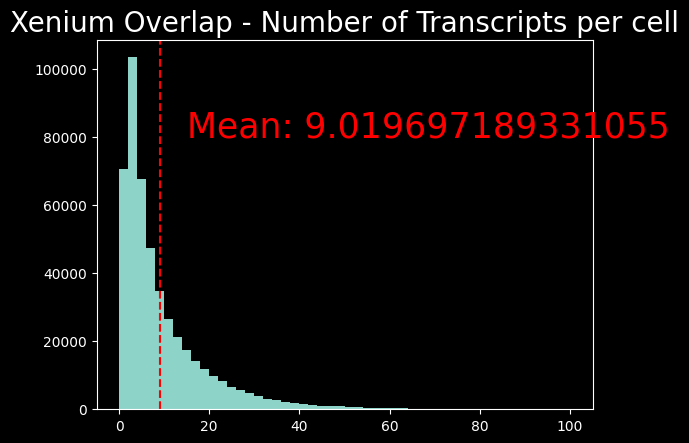

In [71]:
xenium_overlap_transcripts = xenium_overlap_filtered.sum(axis = 1)
plt.hist(xenium_overlap_transcripts, bins = 50, range = (0,100))
plt.axvline(xenium_overlap_transcripts.mean(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(15, 80000, f'Mean: {xenium_overlap_transcripts.mean()}', color = 'red', fontsize = 25)
plt.title('Xenium Overlap - Number of Transcripts per cell', fontsize = 20)

Text(0.5, 1.0, 'Xenium Overlap - Number of Transcripts per cell')

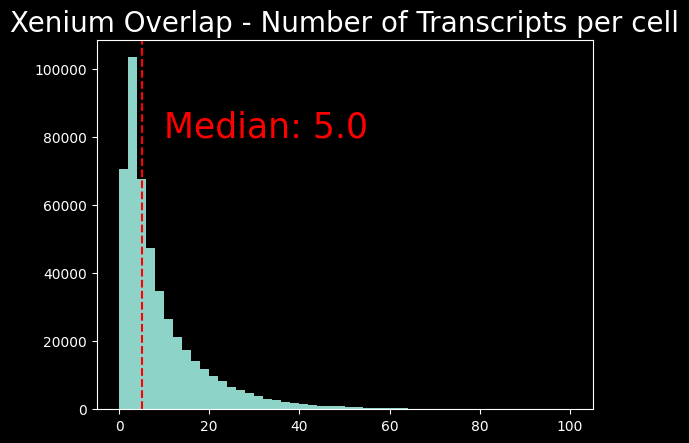

In [72]:
xenium_overlap_transcripts = xenium_overlap_filtered.sum(axis = 1)
plt.hist(xenium_overlap_transcripts, bins = 50, range = (0,100))
plt.axvline(xenium_overlap_transcripts.median(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(10, 80000, f'Median: {xenium_overlap_transcripts.median()}', color = 'red', fontsize = 25)
plt.title('Xenium Overlap - Number of Transcripts per cell', fontsize = 20)

In [73]:
xenium_overlap_violin_plot_df = pd.DataFrame()

In [74]:
xenium_overlap_violin_plot_df['transcript_count'] = xenium_overlap_transcripts
xenium_overlap_violin_plot_df['technology'] = 'Xenium'
xenium_overlap_violin_plot_df

transcript_count technology
7                   10.0     Xenium
8                    1.0     Xenium
11                   1.0     Xenium
18                   2.0     Xenium
20                  15.0     Xenium
...                  ...        ...
556311               8.0     Xenium
556312              10.0     Xenium
556313               3.0     Xenium
556314               5.0     Xenium
556325               1.0     Xenium

[473377 rows x 2 columns]

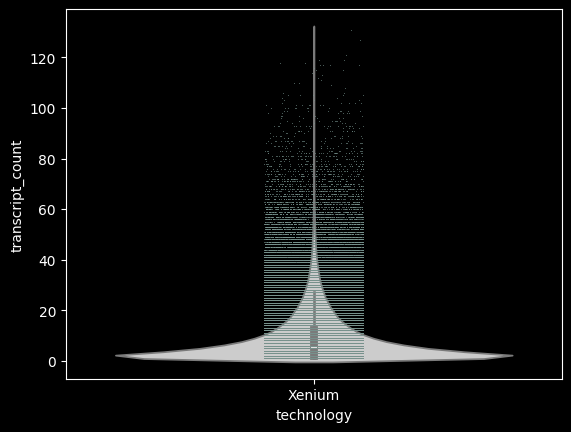

In [75]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = xenium_overlap_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = xenium_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

Text(0.5, 1.0, 'Cosmx Overlap - Number of Transcripts per cell')

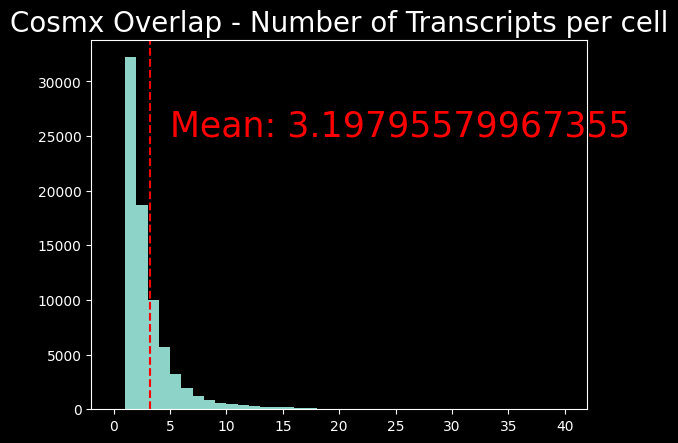

In [76]:
cosmx_overlap_transcripts = cosmx_overlap_filtered.sum(axis = 1)
plt.hist(cosmx_overlap_transcripts, bins = 40, range = (0,40))
plt.axvline(cosmx_overlap_transcripts.mean(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(5, 25000, f'Mean: {cosmx_overlap_transcripts.mean()}', color = 'red', fontsize = 25)
plt.title('Cosmx Overlap - Number of Transcripts per cell', fontsize = 20)

Text(0.5, 1.0, 'Cosmx Overlap - Number of Transcripts per cell')

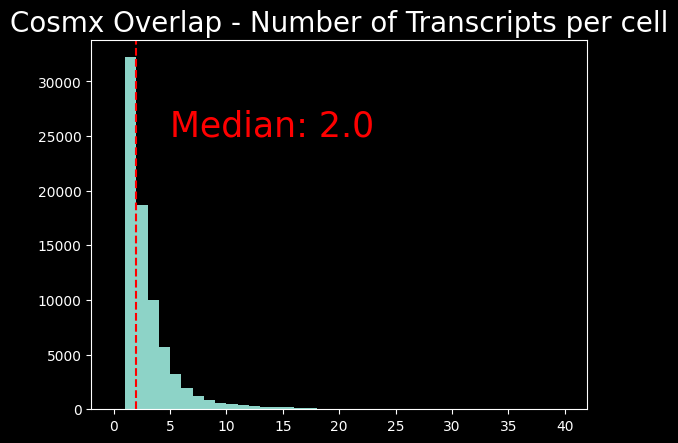

In [77]:
cosmx_overlap_transcripts = cosmx_overlap_filtered.sum(axis = 1)
plt.hist(cosmx_overlap_transcripts, bins = 40, range = (0,40))
plt.axvline(cosmx_overlap_transcripts.median(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(5, 25000, f'Median: {cosmx_overlap_transcripts.median()}', color = 'red', fontsize = 25)
plt.title('Cosmx Overlap - Number of Transcripts per cell', fontsize = 20)

In [78]:
cosmx_overlap_violin_plot_df = pd.DataFrame()

In [79]:
cosmx_overlap_violin_plot_df['transcript_count'] = cosmx_overlap_transcripts
cosmx_overlap_violin_plot_df['technology'] = 'Cosmx'
cosmx_overlap_violin_plot_df

transcript_count technology
0                     89      Cosmx
6                      1      Cosmx
11                     2      Cosmx
14                     1      Cosmx
17                     1      Cosmx
...                  ...        ...
134756                 1      Cosmx
134760                 2      Cosmx
134764                 1      Cosmx
134770                 1      Cosmx
134772                 1      Cosmx

[77194 rows x 2 columns]

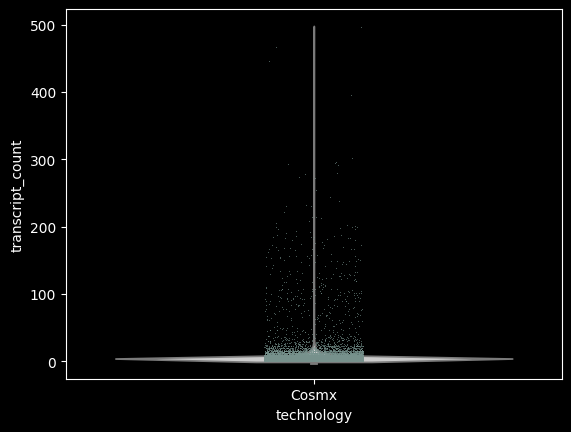

In [80]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = cosmx_overlap_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = cosmx_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

Text(0.5, 1.0, 'Vizgen Overlap - Number of Transcripts per cell')

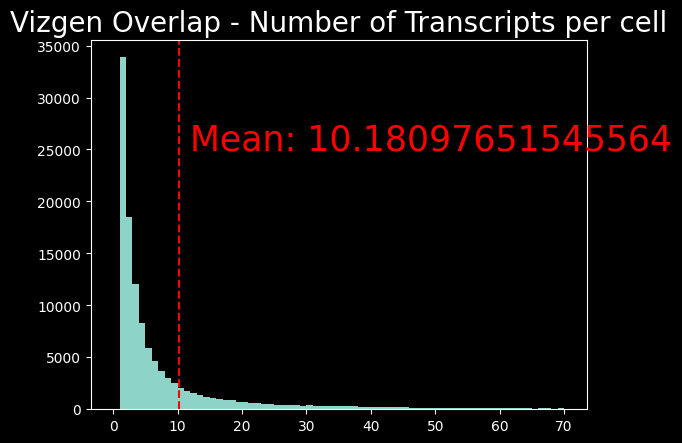

In [81]:
vizgen_overlap_transcripts = vizgen_overlap_filtered.sum(axis = 1)
plt.hist(vizgen_overlap_transcripts, bins = 70, range = (0,70))
plt.axvline(vizgen_overlap_transcripts.mean(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(12, 25000, f'Mean: {vizgen_overlap_transcripts.mean()}', color = 'red', fontsize = 25)
plt.title('Vizgen Overlap - Number of Transcripts per cell', fontsize = 20)

Text(0.5, 1.0, 'Vizgen Overlap - Number of Transcripts per cell')

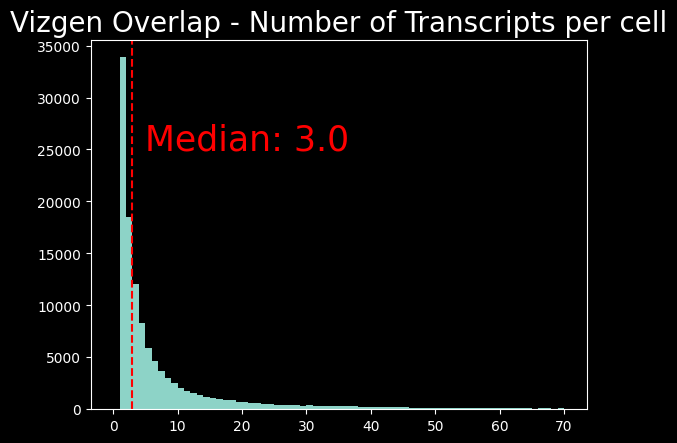

In [82]:
vizgen_overlap_transcripts = vizgen_overlap_filtered.sum(axis = 1)
plt.hist(vizgen_overlap_transcripts, bins = 70, range = (0,70))
plt.axvline(vizgen_overlap_transcripts.median(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(5, 25000, f'Median: {vizgen_overlap_transcripts.median()}', color = 'red', fontsize = 25)
plt.title('Vizgen Overlap - Number of Transcripts per cell', fontsize = 20)

In [83]:
vizgen_overlap_violin_plot_df = pd.DataFrame()
vizgen_overlap_violin_plot_df['transcript_count'] = vizgen_overlap_transcripts
vizgen_overlap_violin_plot_df['technology'] = 'Vizgen'
vizgen_overlap_violin_plot_df

transcript_count technology
cell_id                                         
2706017100030100136                 1     Vizgen
2706017100086100044                 1     Vizgen
2706017100088100388                 1     Vizgen
2706017100145100184                 1     Vizgen
2706017100146100019                 1     Vizgen
...                               ...        ...
2706017104880100113                 1     Vizgen
2706017104886100028                 2     Vizgen
2706017104935100001                69     Vizgen
2706017104991100417                 1     Vizgen
2706017104993100347                 1     Vizgen

[119568 rows x 2 columns]

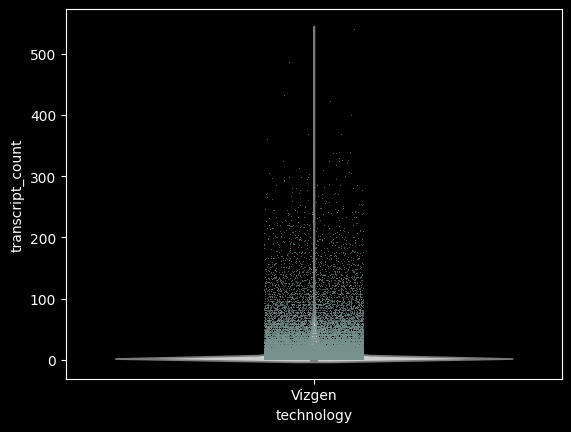

In [84]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = vizgen_overlap_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = vizgen_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

Text(0.5, 1.0, 'Gellyfish Overlap - Number of Transcripts per cell')

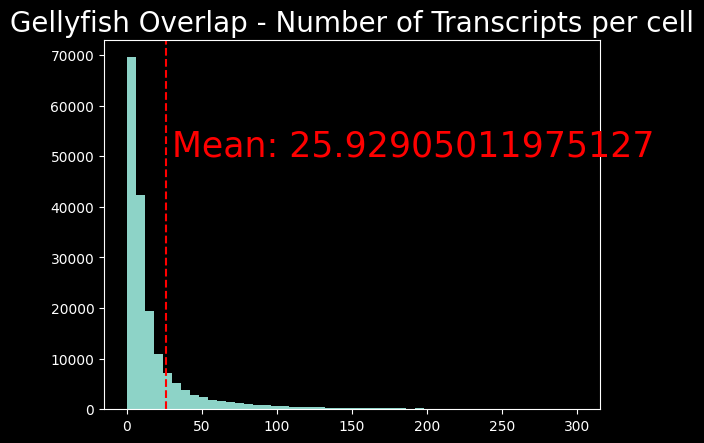

In [85]:
gellyfish_overlap_transcripts = gellyfish_overlap_filtered.sum(axis = 1)
plt.hist(gellyfish_overlap_transcripts, bins = 50, range = (0,300))
plt.axvline(gellyfish_overlap_transcripts.mean(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(30, 50000, f'Mean: {gellyfish_overlap_transcripts.mean()}', color = 'red', fontsize = 25)
plt.title('Gellyfish Overlap - Number of Transcripts per cell', fontsize = 20)

Text(0.5, 1.0, 'Gellyfish Overlap - Number of Transcripts per cell')

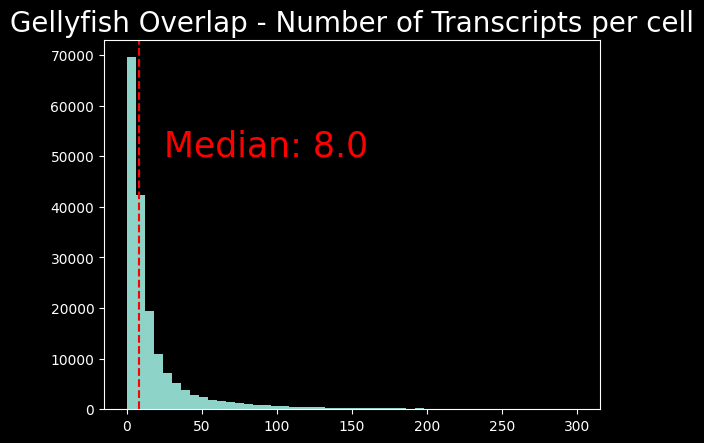

In [86]:
gellyfish_overlap_transcripts = gellyfish_overlap_filtered.sum(axis = 1)
plt.hist(gellyfish_overlap_transcripts, bins = 50, range = (0,300))
plt.axvline(gellyfish_overlap_transcripts.median(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(25, 50000, f'Median: {gellyfish_overlap_transcripts.median()}', color = 'red', fontsize = 25)
plt.title('Gellyfish Overlap - Number of Transcripts per cell', fontsize = 20)

In [87]:
gellyfish_overlap_violin_plot_df = pd.DataFrame()

In [88]:
gellyfish_overlap_violin_plot_df['transcript_count'] = gellyfish_overlap_transcripts
gellyfish_overlap_violin_plot_df['technology'] = 'Gellyfish'
gellyfish_overlap_violin_plot_df

transcript_count technology
0                     17  Gellyfish
1                      2  Gellyfish
2                      3  Gellyfish
3                     16  Gellyfish
4                     20  Gellyfish
...                  ...        ...
210750                 1  Gellyfish
210751                 4  Gellyfish
210752                 2  Gellyfish
210755                 1  Gellyfish
210759                 1  Gellyfish

[182044 rows x 2 columns]

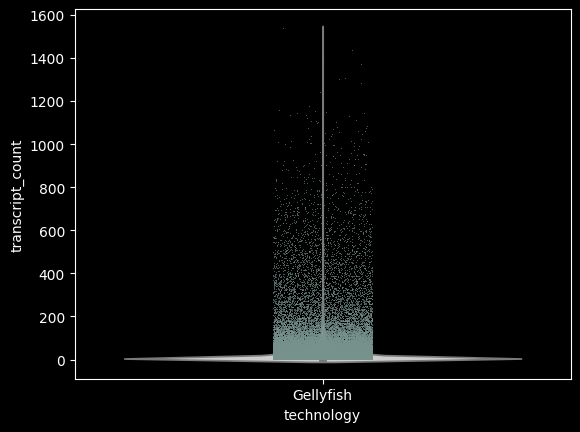

In [89]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = gellyfish_overlap_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = gellyfish_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

### Violin plot based on overlap genes

In [90]:
concated_overlap_violin_plot_df = pd.DataFrame()

In [91]:
concated_overlap_violin_plot_df = pd.concat([xenium_overlap_violin_plot_df, cosmx_overlap_violin_plot_df, vizgen_overlap_violin_plot_df, gellyfish_overlap_violin_plot_df], ignore_index = True)
concated_overlap_violin_plot_df

transcript_count technology
0                   10.0     Xenium
1                    1.0     Xenium
2                    1.0     Xenium
3                    2.0     Xenium
4                   15.0     Xenium
...                  ...        ...
852178               1.0  Gellyfish
852179               4.0  Gellyfish
852180               2.0  Gellyfish
852181               1.0  Gellyfish
852182               1.0  Gellyfish

[852183 rows x 2 columns]

In [92]:
concated_overlap_violin_plot_df_revised = concated_overlap_violin_plot_df[concated_overlap_violin_plot_df['transcript_count'] <= 300]
concated_overlap_violin_plot_df_revised

transcript_count technology
0                   10.0     Xenium
1                    1.0     Xenium
2                    1.0     Xenium
3                    2.0     Xenium
4                   15.0     Xenium
...                  ...        ...
852178               1.0  Gellyfish
852179               4.0  Gellyfish
852180               2.0  Gellyfish
852181               1.0  Gellyfish
852182               1.0  Gellyfish

[849806 rows x 2 columns]

C:\Users\krist\AppData\Local\Temp\ipykernel_26192\4195969986.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df_revised, color = '0.8', palette = 'tab10')


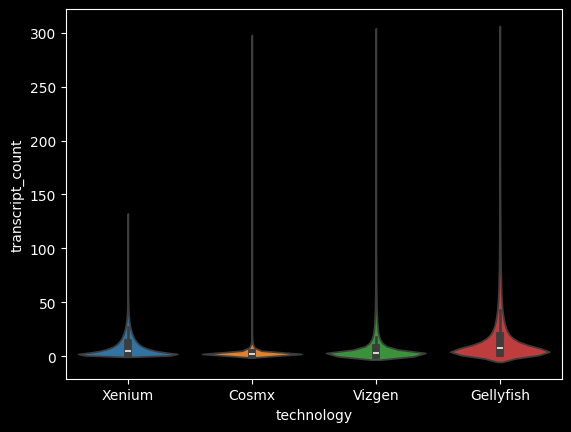

In [93]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df_revised, color = '0.8', palette = 'tab10')
#sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

### Technology summary: overlap genes

In [94]:
print (f'Xenium number of cells:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Xenium'].shape[0])
print(f'Xenium number of genes:', 5)
print (f'Xenium number of samples:', len(concated_cell_csv_filtered['sample_id'].unique()))
print (f'Xenium mean number of genes per cell', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Xenium']['transcript_count'].mean())
print (f'Xenium median number of genes per cell', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Xenium']['transcript_count'].median())
print (f'Xenium mean ratio:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Xenium']['transcript_count'].mean()/5)
print (f'Xenium median ratio:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Xenium']['transcript_count'].median()/5)

Xenium number of cells: 473377
Xenium number of genes: 5
Xenium number of samples: 10
Xenium mean number of genes per cell 9.019696774452498
Xenium median number of genes per cell 5.0
Xenium mean ratio: 1.8039393548904996
Xenium median ratio: 1.0


In [95]:
print (f'Cosmx number of cells:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Cosmx'].shape[0])
print(f'Cosmx number of genes:', 5)
print (f'Cosmx number of samples:', 4)
print (f'Cosmx mean number of genes per cell', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Cosmx']['transcript_count'].mean())
print (f'Cosmx median number of genes per cell', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Cosmx']['transcript_count'].median())
print (f'Cosmx mean ratio:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Cosmx']['transcript_count'].mean()/5)
print (f'Cosmx median ratio:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Cosmx']['transcript_count'].median()/5)


Cosmx number of cells: 77189
Cosmx number of genes: 5
Cosmx number of samples: 4
Cosmx mean number of genes per cell 3.170879270362357
Cosmx median number of genes per cell 2.0
Cosmx mean ratio: 0.6341758540724715
Cosmx median ratio: 0.4


In [96]:
print (f'Vizgen number of cells:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Vizgen'].shape[0])
print(f'Vizgen number of genes:', 5)
print (f'Vizgen number of samples:', 1)
print (f'Vizgen mean number of genes per cell', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Vizgen']['transcript_count'].mean())
print (f'Vizgen median number of genes per cell', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Vizgen']['transcript_count'].median())
print (f'Vizgen mean ratio:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Vizgen']['transcript_count'].mean()/5)
print (f'Vizgen median ratio:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Vizgen']['transcript_count'].median()/5)


Vizgen number of cells: 119539
Vizgen number of genes: 5
Vizgen number of samples: 1
Vizgen mean number of genes per cell 10.098528513706825
Vizgen median number of genes per cell 3.0
Vizgen mean ratio: 2.0197057027413647
Vizgen median ratio: 0.6


In [97]:
print (f'Gellyfish number of cells:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Gellyfish'].shape[0])
print(f'Gellyfish number of genes:', 5)
print (f'Gellyfish number of samples:', 5)
print (f'Gellyfish mean number of genes per cell', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Gellyfish']['transcript_count'].mean())
print (f'Gellyfish median number of genes per cell', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Gellyfish']['transcript_count'].median())
print (f'Gellyfish mean ratio:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Gellyfish']['transcript_count'].mean()/5)
print (f'Gellyfish median ratio:', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Gellyfish']['transcript_count'].median()/5)


Gellyfish number of cells: 179701
Gellyfish number of genes: 5
Gellyfish number of samples: 5
Gellyfish mean number of genes per cell 19.812722244172264
Gellyfish median number of genes per cell 8.0
Gellyfish mean ratio: 3.9625444488344526
Gellyfish median ratio: 1.6


### Histograms for overlapping genes individually

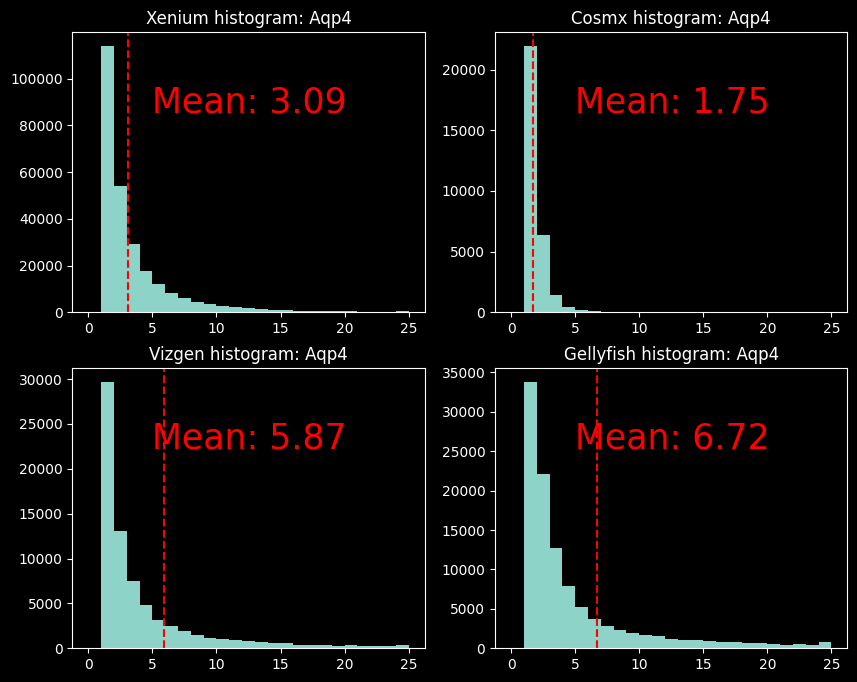

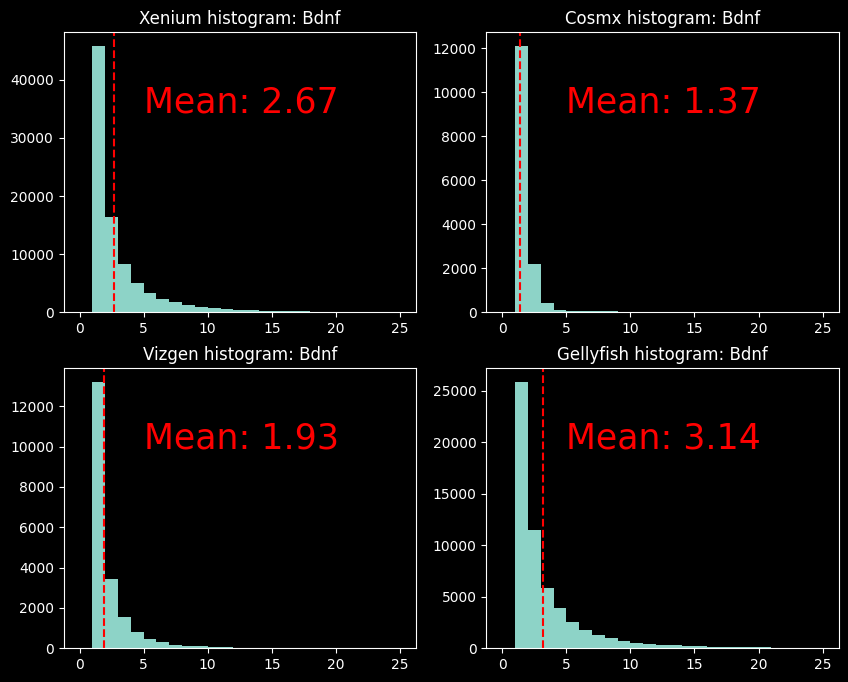

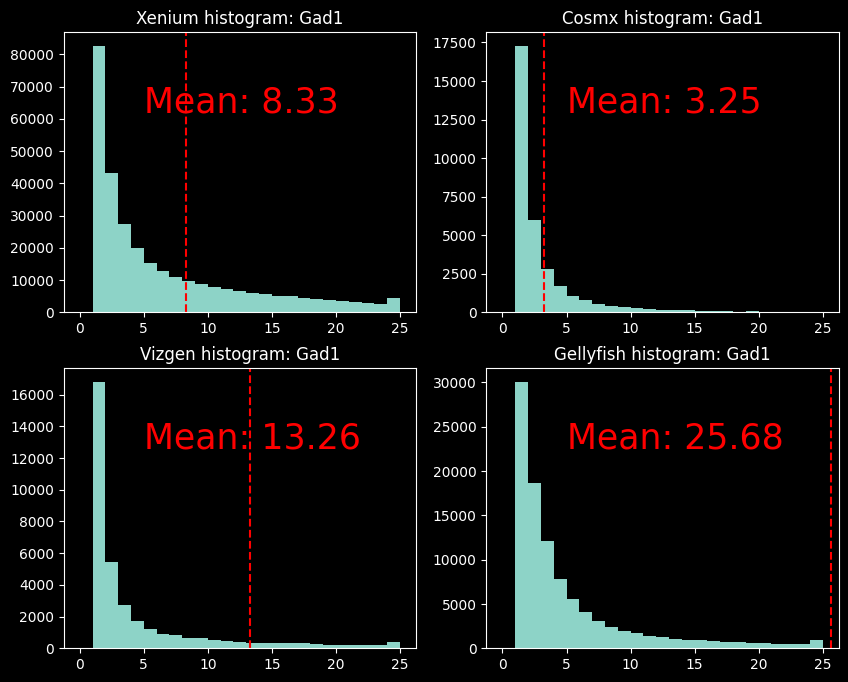

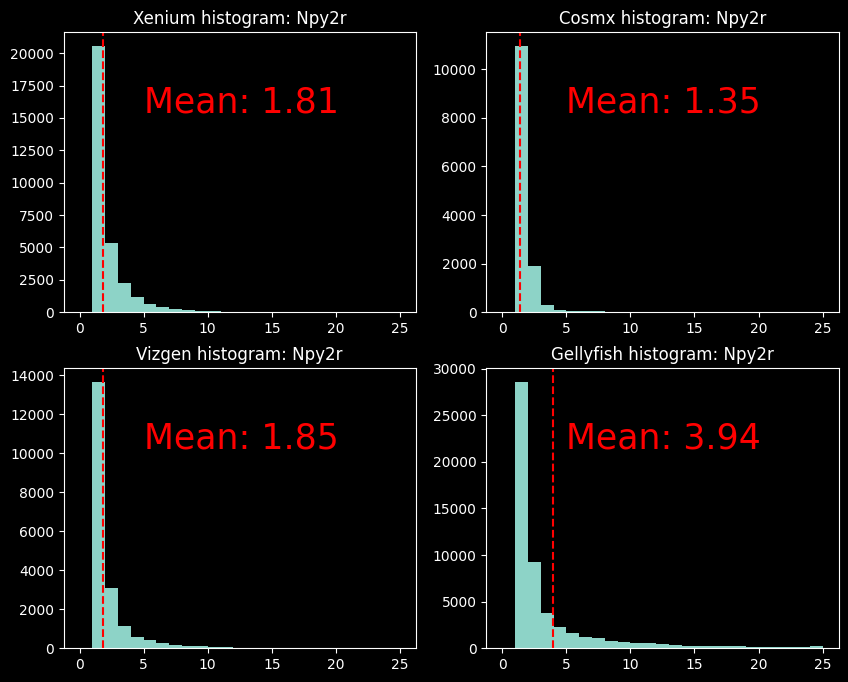

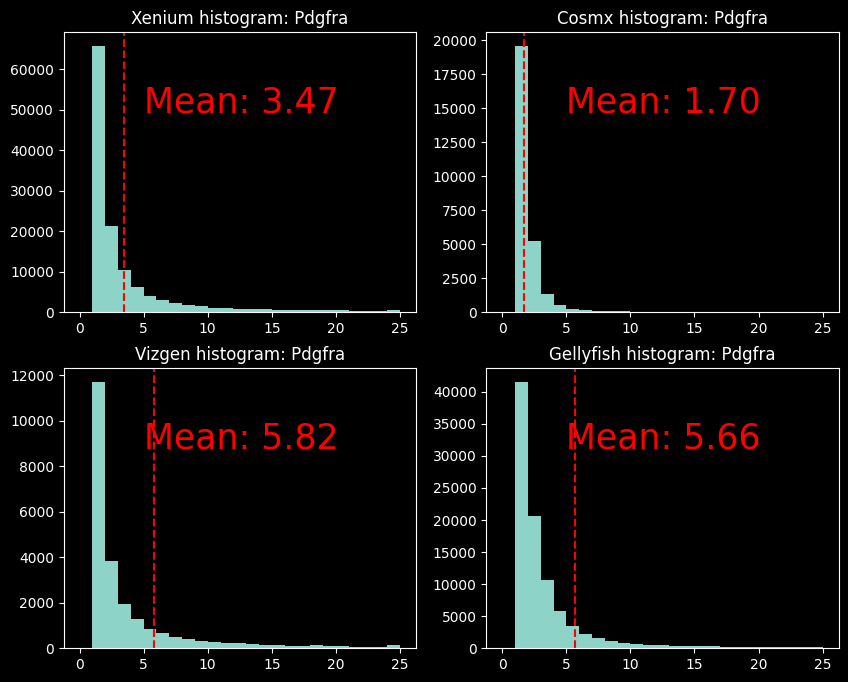

In [144]:
for gene in gene_overlap_list:
    xenium_overlap_filtered_gene = xenium_overlap_filtered[gene][xenium_overlap_filtered[gene] != 0]
    cosmx_overlap_filtered_gene = cosmx_overlap_filtered[gene][cosmx_overlap_filtered[gene] != 0]
    vizgen_overlap_filtered_gene = vizgen_overlap_filtered[gene][vizgen_overlap_filtered[gene] != 0]
    gellyfish_overlap_filtered_gene = gellyfish_overlap_filtered[gene][gellyfish_overlap_filtered[gene] != 0]
    fig, axs = plt.subplots(2,2, figsize = (10,8))
    
    counts, bins, _ = axs[0,0].hist(xenium_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[0,0].axvline(xenium_overlap_filtered_gene.mean(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[0,0].text(5, int(0.75 * np.max(counts)), f'Mean: {"{:.2f}".format(xenium_overlap_filtered_gene.mean())}', color = 'red', fontsize = 25)
    axs[0,0].set_title(f'Xenium histogram: {gene}')
    
    counts, bins, _ = axs[0,1].hist(cosmx_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[0,1].axvline(cosmx_overlap_filtered_gene.mean(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[0,1].text(5, int(0.75 * np.max(counts)), f'Mean: {"{:.2f}".format(cosmx_overlap_filtered_gene.mean())}', color = 'red', fontsize = 25)
    axs[0,1].set_title(f'Cosmx histogram: {gene}')
    
    counts, bins, _ = axs[1,0].hist(vizgen_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[1,0].axvline(vizgen_overlap_filtered_gene.mean(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[1,0].text(5, int(0.75 * np.max(counts)), f'Mean: {"{:.2f}".format(vizgen_overlap_filtered_gene.mean())}', color = 'red', fontsize = 25)
    axs[1,0].set_title(f'Vizgen histogram: {gene}')
    
    counts, bins, _ = axs[1,1].hist(gellyfish_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[1,1].axvline(gellyfish_overlap_filtered_gene.mean(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[1,1].text(5, int(0.75 * np.max(counts)), f'Mean: {"{:.2f}".format(gellyfish_overlap_filtered_gene.mean())}', color = 'red', fontsize = 25)
    axs[1,1].set_title(f'Gellyfish histogram: {gene}')
    plt.savefig(rf'D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Joint Analysis\Figures\{gene} count per cell mean histogram.png', dpi = 300)
    plt.show()

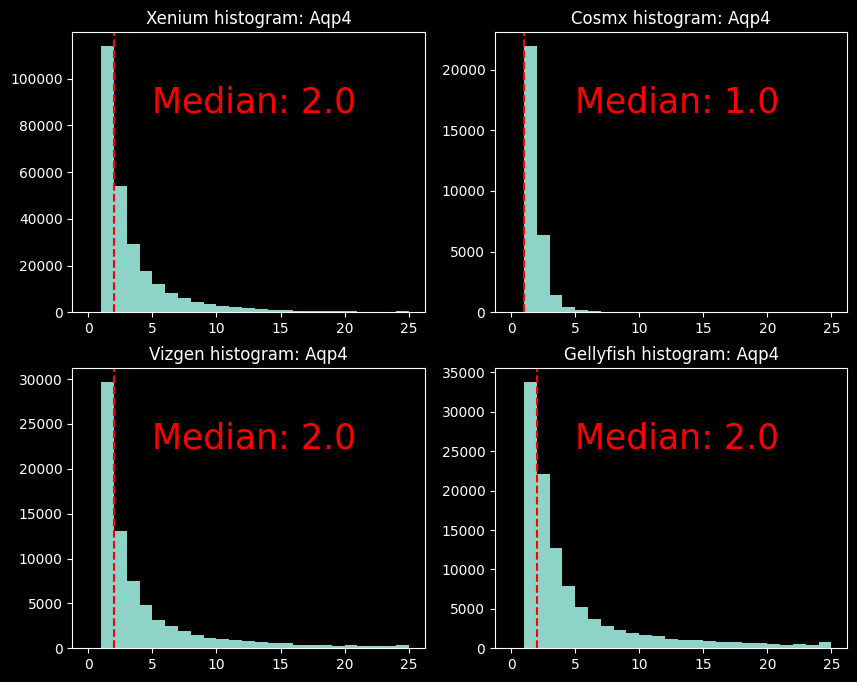

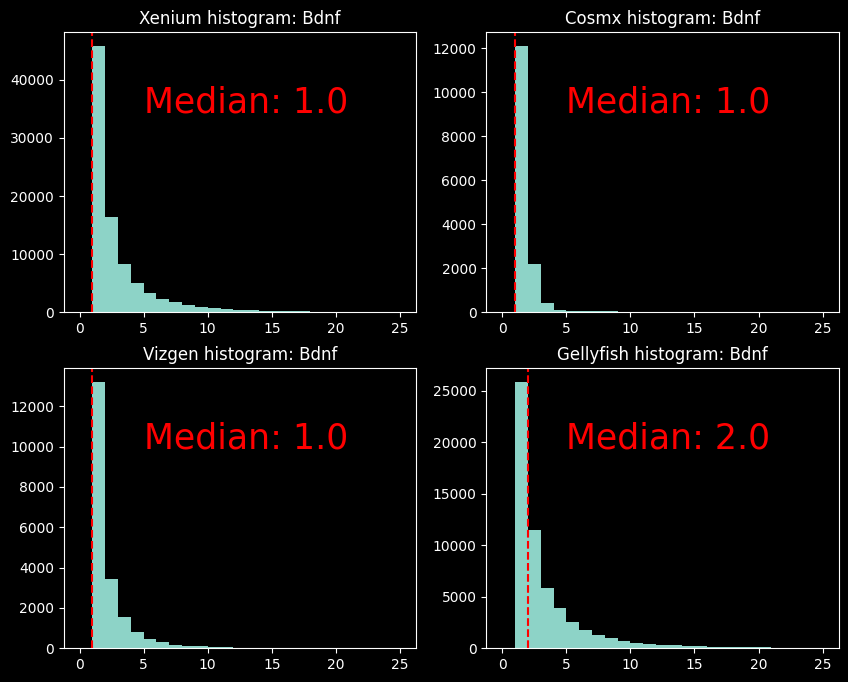

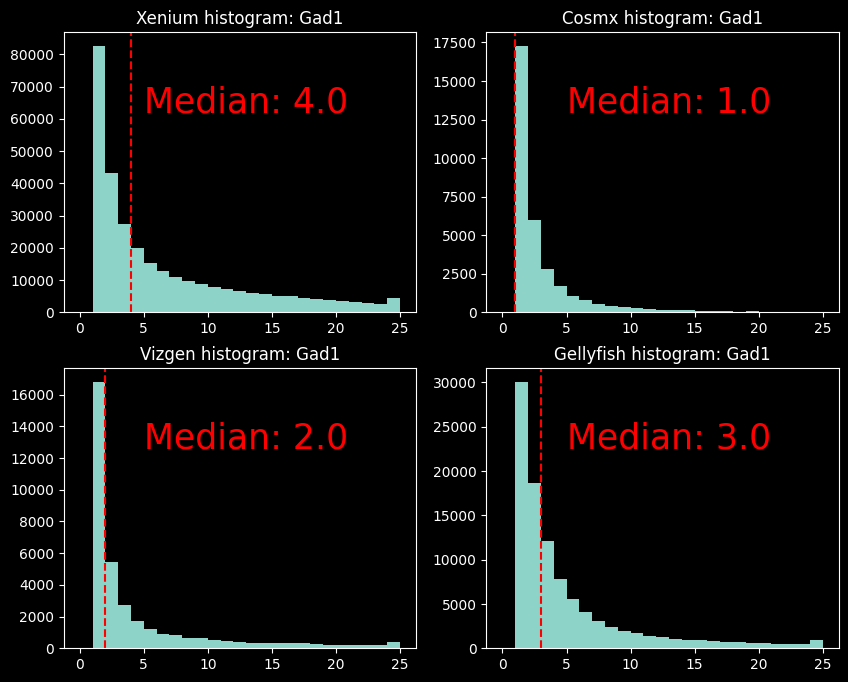

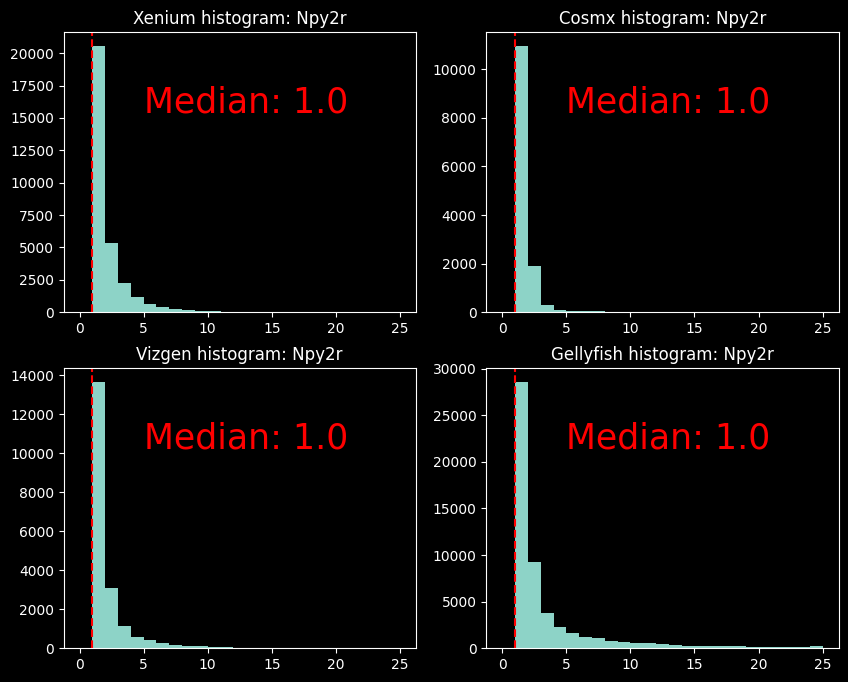

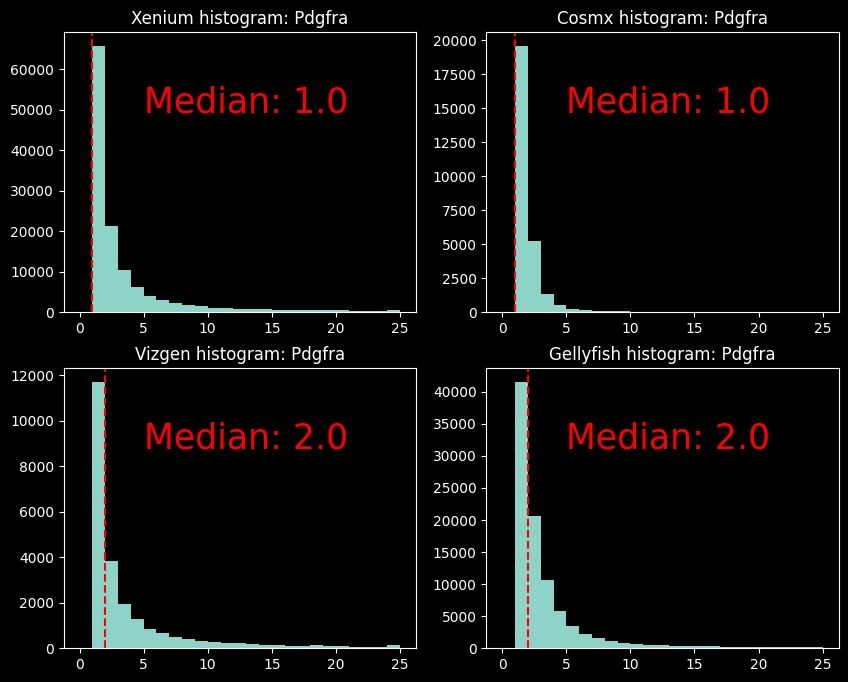

In [143]:
for gene in gene_overlap_list:
    xenium_overlap_filtered_gene = xenium_overlap_filtered[gene][xenium_overlap_filtered[gene] != 0]
    cosmx_overlap_filtered_gene = cosmx_overlap_filtered[gene][cosmx_overlap_filtered[gene] != 0]
    vizgen_overlap_filtered_gene = vizgen_overlap_filtered[gene][vizgen_overlap_filtered[gene] != 0]
    gellyfish_overlap_filtered_gene = gellyfish_overlap_filtered[gene][gellyfish_overlap_filtered[gene] != 0]
    fig, axs = plt.subplots(2,2, figsize = (10,8))
    
    counts, bins, _ = axs[0,0].hist(xenium_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[0,0].axvline(xenium_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[0,0].text(5, int(0.75 * np.max(counts)), f'Median: {xenium_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[0,0].set_title(f'Xenium histogram: {gene}')
    
    counts, bins, _ = axs[0,1].hist(cosmx_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[0,1].axvline(cosmx_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[0,1].text(5, int(0.75 * np.max(counts)), f'Median: {cosmx_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[0,1].set_title(f'Cosmx histogram: {gene}')
    
    counts, bins, _ = axs[1,0].hist(vizgen_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[1,0].axvline(vizgen_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[1,0].text(5, int(0.75 * np.max(counts)), f'Median: {vizgen_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[1,0].set_title(f'Vizgen histogram: {gene}')
    
    counts, bins, _ = axs[1,1].hist(gellyfish_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[1,1].axvline(gellyfish_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[1,1].text(5, int(0.75 * np.max(counts)), f'Median: {gellyfish_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[1,1].set_title(f'Gellyfish histogram: {gene}')
    plt.savefig(rf'D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Joint Analysis\Figures\{gene} count per cell median histogram.png', dpi = 300)
    plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2594126959.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = 'tab10')


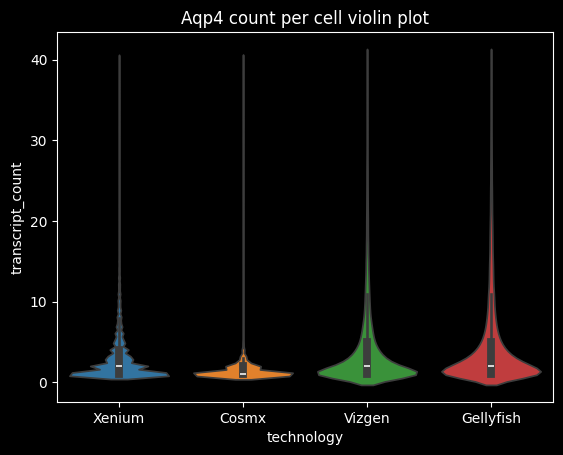

Xenium mean number of genes per cell - Aqp4: 3.0742218614636516
Xenium median number of genes per cell - Aqp4: 2.0
Cosmx mean number of genes per cell - Aqp4: 1.6266709719082983
Cosmx median number of genes per cell - Aqp4: 1.0
Vizgen mean number of genes per cell - Aqp4: 4.461878765060241
Vizgen median number of genes per cell - Aqp4: 2.0
Gellyfish mean number of genes per cell - Aqp4: 5.1068171590731675
Gellyfish median number of genes per cell - Aqp4: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2594126959.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = 'tab10')


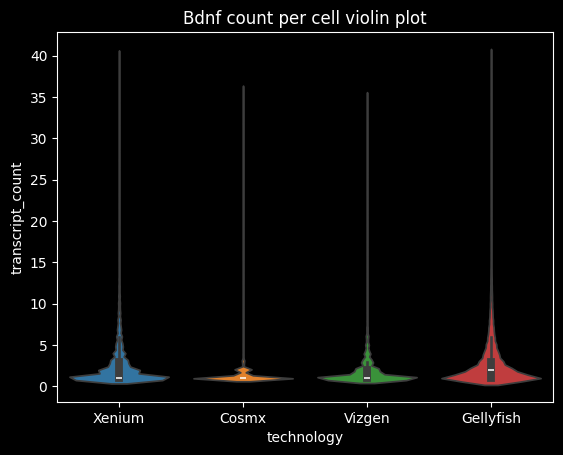

Xenium mean number of genes per cell - Bdnf: 2.6651839506311865
Xenium median number of genes per cell - Bdnf: 1.0
Cosmx mean number of genes per cell - Bdnf: 1.3693669882384036
Cosmx median number of genes per cell - Bdnf: 1.0
Vizgen mean number of genes per cell - Bdnf: 1.9253585238118545
Vizgen median number of genes per cell - Bdnf: 1.0
Gellyfish mean number of genes per cell - Bdnf: 3.0526178465820144
Gellyfish median number of genes per cell - Bdnf: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2594126959.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = 'tab10')


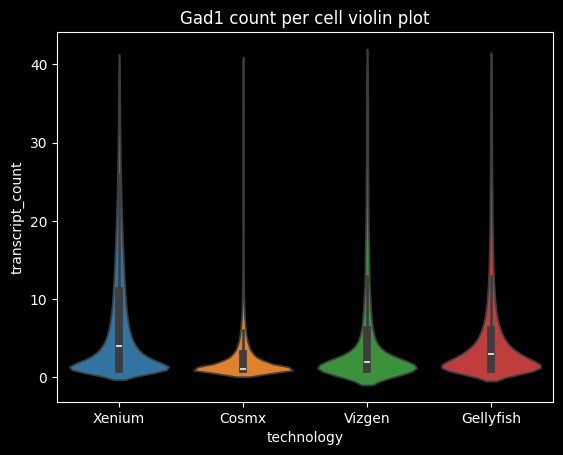

Xenium mean number of genes per cell - Gad1: 7.468390517155147
Xenium median number of genes per cell - Gad1: 4.0
Cosmx mean number of genes per cell - Gad1: 2.7739149145456783
Cosmx median number of genes per cell - Gad1: 1.0
Vizgen mean number of genes per cell - Gad1: 5.569302845582559
Vizgen median number of genes per cell - Gad1: 2.0
Gellyfish mean number of genes per cell - Gad1: 5.742161760017005
Gellyfish median number of genes per cell - Gad1: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2594126959.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = 'tab10')


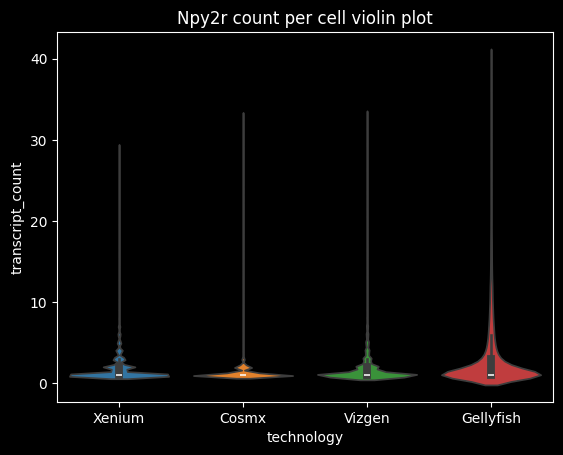

Xenium mean number of genes per cell - Npy2r: 1.8074772327847899
Xenium median number of genes per cell - Npy2r: 1.0
Cosmx mean number of genes per cell - Npy2r: 1.3492192703322727
Cosmx median number of genes per cell - Npy2r: 1.0
Vizgen mean number of genes per cell - Npy2r: 1.8427107404802572
Vizgen median number of genes per cell - Npy2r: 1.0
Gellyfish mean number of genes per cell - Npy2r: 3.493728325831919
Gellyfish median number of genes per cell - Npy2r: 1.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2594126959.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = 'tab10')


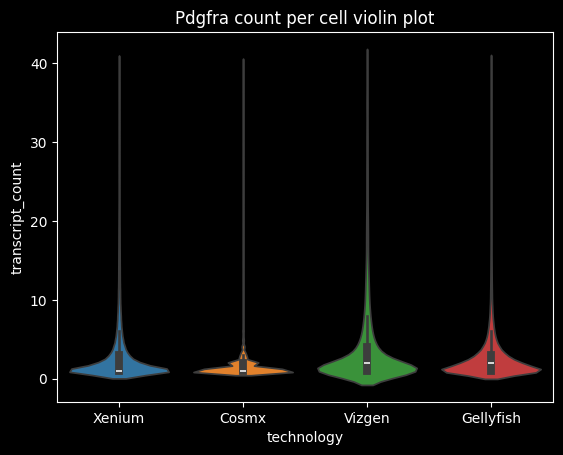

Xenium mean number of genes per cell - Pdgfra: 3.4500149138918976
Xenium median number of genes per cell - Pdgfra: 1.0
Cosmx mean number of genes per cell - Pdgfra: 1.6889536977028876
Cosmx median number of genes per cell - Pdgfra: 1.0
Vizgen mean number of genes per cell - Pdgfra: 4.346000901898085
Vizgen median number of genes per cell - Pdgfra: 2.0
Gellyfish mean number of genes per cell - Pdgfra: 3.3440634650197
Gellyfish median number of genes per cell - Pdgfra: 2.0


In [141]:
for gene in gene_overlap_list:
    xenium_overlap_filtered_gene = xenium_overlap_filtered[gene][xenium_overlap_filtered[gene] != 0]
    xenium_overlap_gene_df = pd.DataFrame()
    xenium_overlap_gene_df['transcript_count'] = xenium_overlap_filtered_gene
    xenium_overlap_gene_df['technology'] = 'Xenium'
    
    cosmx_overlap_filtered_gene = cosmx_overlap_filtered[gene][cosmx_overlap_filtered[gene] != 0]
    cosmx_overlap_gene_df = pd.DataFrame()
    cosmx_overlap_gene_df['transcript_count'] = cosmx_overlap_filtered_gene
    cosmx_overlap_gene_df['technology'] = 'Cosmx'
    
    vizgen_overlap_filtered_gene = vizgen_overlap_filtered[gene][vizgen_overlap_filtered[gene] != 0]
    vizgen_overlap_gene_df = pd.DataFrame()
    vizgen_overlap_gene_df['transcript_count'] = vizgen_overlap_filtered_gene
    vizgen_overlap_gene_df['technology'] = 'Vizgen'
    
    gellyfish_overlap_filtered_gene = gellyfish_overlap_filtered[gene][gellyfish_overlap_filtered[gene] != 0]
    gellyfish_overlap_gene_df = pd.DataFrame()
    gellyfish_overlap_gene_df['transcript_count'] = gellyfish_overlap_filtered_gene
    gellyfish_overlap_gene_df['technology'] = 'Gellyfish'
    
    concated_df = pd.DataFrame()
    concated_df = pd.concat([xenium_overlap_gene_df, cosmx_overlap_gene_df, vizgen_overlap_gene_df, gellyfish_overlap_gene_df], ignore_index = True)
    concated_df_revised = concated_df[concated_df['transcript_count'] <= 40]

    sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = 'tab10')
    #sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_df, jitter = True, size = 0.15)
    plt.title(f'{gene} count per cell violin plot')
    plt.savefig(rf'D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Joint Analysis\Figures\{gene} count per cell violin plot.png', dpi = 300)
    plt.show()
    
    print (f'Xenium mean number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Xenium']['transcript_count'].mean())
    print (f'Xenium median number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Xenium']['transcript_count'].median())
    print(f'Cosmx mean number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Cosmx']['transcript_count'].mean())
    print(f'Cosmx median number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Cosmx']['transcript_count'].median())
    print(f'Vizgen mean number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Vizgen']['transcript_count'].mean())
    print(f'Vizgen median number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Vizgen']['transcript_count'].median())
    print(f'Gellyfish mean number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Gellyfish']['transcript_count'].mean())
    print(f'Gellyfish median number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Gellyfish']['transcript_count'].median())

### Look at Xenium and Gellyfish overlap

In [102]:
xenium_gellyfish_overlap_list = list(gene_overlap_df_xenium['genes'])
print(xenium_gellyfish_overlap_list)

['Acta2', 'Aqp4', 'Bdnf', 'Calb1', 'Cdh13', 'Cldn5', 'Cntnap5b', 'Cspg4', 'Fos', 'Gad1', 'Gfap', 'Gpr17', 'Inpp4b', 'Laptm5', 'Mapk4', 'Ndst4', 'Nell1', 'Neurod6', 'Npy2r', 'Opalin', 'Pdgfra', 'Prox1', 'Rasl10a', 'Sema3a', 'Slit2', 'Sox10', 'Sox11', 'Unc13c', 'Vip', 'Wfs1']


In [103]:
xenium_overlap = xenium_cell_df.loc[:, [gene for gene in xenium_cell_df.columns if gene in xenium_gellyfish_overlap_list]]
xenium_overlap_filtered_gellyfish = xenium_overlap[xenium_overlap.sum(axis=1) != 0]
xenium_overlap_filtered_gellyfish

Acta2  Aqp4  Bdnf  Calb1  Cdh13  Cldn5  Cntnap5b  Cspg4  Fos  Gad1  \
1         0.0   0.0   0.0    0.0    0.0    0.0       0.0    0.0  0.0   0.0   
2         0.0   0.0   0.0    0.0    0.0    0.0       0.0    0.0  0.0   0.0   
5         0.0   0.0   0.0    0.0    0.0    0.0       0.0    0.0  0.0   0.0   
6         0.0   0.0   0.0    0.0    0.0    0.0       0.0    0.0  0.0   0.0   
7         0.0   0.0   0.0    1.0    0.0    0.0       0.0    0.0  0.0  10.0   
...       ...   ...   ...    ...    ...    ...       ...    ...  ...   ...   
556312    0.0   4.0   0.0    0.0    1.0    0.0       0.0    0.0  0.0   6.0   
556313    0.0   0.0   0.0    2.0    2.0    6.0       0.0    0.0  0.0   3.0   
556314    0.0   0.0   0.0    2.0    1.0    0.0       0.0    0.0  0.0   5.0   
556325    0.0   0.0   0.0    0.0    0.0    0.0       0.0    0.0  0.0   0.0   
556342    0.0   0.0   0.0    0.0    0.0    0.0       0.0    0.0  0.0   0.0   

        ...  Pdgfra  Prox1  Rasl10a  Sema3a  Slit2  Sox10  Sox11  Unc13c  Vip  \
1       ...     0.0    0.0      0.0     0.0    0.0    0.0    0.0     0.0  0.0   
2       ...     0.0    1.0      1.0     0.0    0.0    0.0    0.0     0.0  0.0   
5       ...     0.0    0.0      0.0     0.0    0.0    0.0    1.0     0.0  0.0   
6       ...     0.0    0.0      0.0     0.0    0.0    0.0    0.0     0.0  1.0   
7       ...     0.0    0.0      1.0     1.0    0.0    0.0    0.0     0.0  0.0   
...     ...     ...    ...      ...     ...    ...    ...    ...     ...  ...   
556312  ...     0.0    1.0      1.0     0.0    0.0    0.0    0.0     3.0  0.0   
556313  ...     0.0    0.0      0.0     0.0    1.0    0.0    0.0     0.0  0.0   
556314  ...     0.0    0.0      0.0     1.0    1.0    0.0    1.0     0.0  0.0   
556325  ...     0.0    0.0      0.0     0.0    0.0    0.0    0.0     0.0  0.0   
556342  ...     0.0    0.0      0.0     0.0    0.0    0.0    0.0     0.0  0.0   

        Wfs1  
1        0.0  
2        0.0  
5        0.0  
6        1.0  
7        0.0  
...      ...  
556312   0.0  
556313   0.0  
556314   1.0  
556325   0.0  
556342   0.0  

[546250 rows x 30 columns]

In [104]:
gellyfish_overlap = gellyfish_cell_df.loc[:, [gene for gene in cbm2_cell_df.columns if gene in xenium_gellyfish_overlap_list]]
gellyfish_overlap_filtered_xenium = gellyfish_overlap[gellyfish_overlap.sum(axis=1) != 0]
gellyfish_overlap_filtered_xenium

Acta2  Aqp4  Bdnf  Calb1  Cdh13  Cldn5  Cntnap5b  Cspg4  Fos  Gad1  \
0           6    17     0      2      0      0         0      0    1     0   
1           0     0     0      8      9      0         0      0    0     0   
2           2     1     1      1      3     40         0      0    0     0   
3           5     3     7     34     29      1         4      0    2     1   
4           2     0     4     14     13      0         3      0    8     0   
...       ...   ...   ...    ...    ...    ...       ...    ...  ...   ...   
210754      1     0     0      0      1      0         1      0    0     0   
210755      0     0     0      0      0      0         0      0    1     0   
210756      0     0     0      1      0      0         2      1    2     0   
210758      0     0     0      0      0      1         0      0    0     0   
210759      0     0     0      0      0      0         0      0    0     0   

        ...  Pdgfra  Prox1  Rasl10a  Sema3a  Slit2  Sox10  Sox11  Unc13c  Vip  \
0       ...       0      1        1       0      0      0      9       5    0   
1       ...       0      8        0       1      0      0      2       1    0   
2       ...       0      0        0       0      0      0      0       5    0   
3       ...       3     23        1       4      1      1      2       3    0   
4       ...       2     31        1       2      0      0      4       0    0   
...     ...     ...    ...      ...     ...    ...    ...    ...     ...  ...   
210754  ...       0      0        0       0      0      0      0       1    0   
210755  ...       1      0        0       0      0      0      0       0    0   
210756  ...       0      0        0       0      1      1      0       0    0   
210758  ...       0      0        0       0      1      0      0       0    0   
210759  ...       1      0        0       0      0      0      0       0    0   

        Wfs1  
0          3  
1          6  
2          1  
3         15  
4         11  
...      ...  
210754     0  
210755     0  
210756     0  
210758     0  
210759     0  

[206661 rows x 30 columns]

In [105]:
xenium_overlap_transcripts = xenium_overlap_filtered_gellyfish.sum(axis = 1)
xenium_overlap_violin_plot_df = pd.DataFrame()
xenium_overlap_violin_plot_df['transcript_count'] = xenium_overlap_transcripts
xenium_overlap_violin_plot_df['technology'] = 'Xenium'
xenium_overlap_violin_plot_df

transcript_count technology
1                    2.0     Xenium
2                   10.0     Xenium
5                    2.0     Xenium
6                    3.0     Xenium
7                   16.0     Xenium
...                  ...        ...
556312              18.0     Xenium
556313              17.0     Xenium
556314              13.0     Xenium
556325               1.0     Xenium
556342               1.0     Xenium

[546250 rows x 2 columns]

In [106]:
gellyfish_overlap_transcripts = gellyfish_overlap_filtered_xenium.sum(axis = 1)
gellyfish_overlap_violin_plot_df = pd.DataFrame()
gellyfish_overlap_violin_plot_df['transcript_count'] = gellyfish_overlap_transcripts
gellyfish_overlap_violin_plot_df['technology'] = 'Gellyfish'
gellyfish_overlap_violin_plot_df

transcript_count technology
0                     49  Gellyfish
1                     93  Gellyfish
2                     57  Gellyfish
3                    188  Gellyfish
4                    154  Gellyfish
...                  ...        ...
210754                 6  Gellyfish
210755                 6  Gellyfish
210756                12  Gellyfish
210758                 2  Gellyfish
210759                 2  Gellyfish

[206661 rows x 2 columns]

In [107]:
concated_overlap_violin_plot_df = pd.DataFrame()
concated_overlap_violin_plot_df = pd.concat([xenium_overlap_violin_plot_df, gellyfish_overlap_violin_plot_df], ignore_index = True)
concated_overlap_violin_plot_df

transcript_count technology
0                    2.0     Xenium
1                   10.0     Xenium
2                    2.0     Xenium
3                    3.0     Xenium
4                   16.0     Xenium
...                  ...        ...
752906               6.0  Gellyfish
752907               6.0  Gellyfish
752908              12.0  Gellyfish
752909               2.0  Gellyfish
752910               2.0  Gellyfish

[752911 rows x 2 columns]

In [108]:
concated_overlap_violin_plot_df_revised = concated_overlap_violin_plot_df[concated_overlap_violin_plot_df['transcript_count'] <= 600]
concated_overlap_violin_plot_df_revised

transcript_count technology
0                    2.0     Xenium
1                   10.0     Xenium
2                    2.0     Xenium
3                    3.0     Xenium
4                   16.0     Xenium
...                  ...        ...
752906               6.0  Gellyfish
752907               6.0  Gellyfish
752908              12.0  Gellyfish
752909               2.0  Gellyfish
752910               2.0  Gellyfish

[751878 rows x 2 columns]

In [109]:
custom_colors = ["#1f77b4","#d62728"]

C:\Users\krist\AppData\Local\Temp\ipykernel_26192\514788588.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df_revised, color = '0.8', palette = custom_colors)


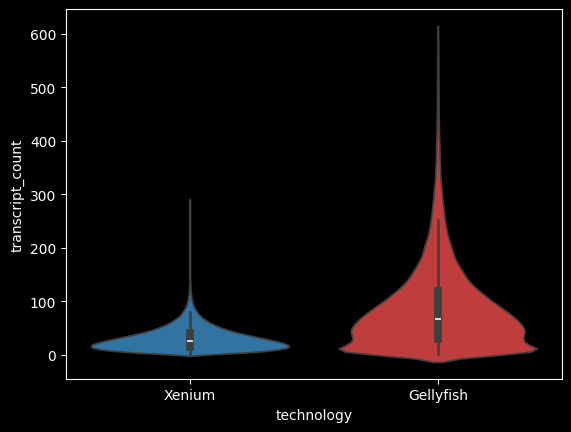

In [110]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df_revised, color = '0.8', palette = custom_colors)
#sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

### Look at Cosmx and Gellyfish overlap

In [111]:
cosmx_gellyfish_overlap_list = list(gene_overlap_df_cosmx['genes'])
print(cosmx_gellyfish_overlap_list)

['Aldoc', 'Unc5c', 'Gnb1', 'Slit2', 'Bcl2', 'Pde10a', 'Atp1b1', 'Nnat', 'Rtn4', 'Cd74', 'Pdgfra', 'Reln', 'Slc1a2', 'Adcy2', 'Mcu', 'Htt', 'Slc2a1', 'Gad1', 'Gabra2', 'S100b', 'Adcy1', 'Ntrk2', 'Kcnd2', 'Vip', 'Cldn5', 'Rbfox3', 'Calb1', 'Dgkb', 'Olig2', 'Atp1a2', 'Synpr', 'Scd2', 'Acer3', 'Fyn', 'Tardbp', 'Bsg', 'Fxyd6', 'Ptgds', 'Casp3', 'Olig1', 'Npy2r', 'Thy1', 'Gja1', 'Fos', 'C1qa', 'Gpr17', 'Slc1a3', 'Acta2', 'Sox9', 'Gfap', 'Mfge8', 'Cd14', 'Vim', 'Trim2', 'Dcc', 'Prkg1', 'Mertk', 'Adgrl3', 'Efna5', 'Flt1', 'Bdnf', 'Slc5a7', 'Agt', 'Eif4a2', 'Pde1a', 'Cspg5', 'Tgfb1', 'Robo1', 'Psap', 'Sgk1', 'Gpm6a', 'Auts2', 'Aqp4']


In [112]:
cosmx_overlap = cosmx_gene_exp_revised.loc[:, [gene for gene in cosmx_gene_exp_revised.columns if gene in cosmx_gellyfish_overlap_list]]
cosmx_overlap_filtered_gellyfish = cosmx_overlap[cosmx_overlap.sum(axis=1) != 0]
cosmx_overlap_filtered_gellyfish

Aldoc  Unc5c  Gnb1  Slit2  Bcl2  Pde10a  Atp1b1  Nnat  Rtn4  Cd74  \
0         106      9    40      9    11       5      34    29    20    11   
2           0      0     0      0     0       0       0     0     0     0   
3           0      0     0      0     0       0       0     0     0     0   
4           0      0     0      0     0       0       0     0     0     0   
5           2      0     1      0     0       0       0     0     0     1   
...       ...    ...   ...    ...   ...     ...     ...   ...   ...   ...   
134768      1      0     0      2     0       1       0     1     0     0   
134769      0      0     0      0     0       0       0     0     0     0   
134770      3      0     0      0     1       0       1     0     0     0   
134771      0      0     0      0     0       0       0     0     0     2   
134772      0      0     0      0     0       0       0     0     0     0   

        ...  Eif4a2  Pde1a  Cspg5  Tgfb1  Robo1  Psap  Sgk1  Gpm6a  Auts2  \
0       ...      15      6     23      9      6    68     4     71      5   
2       ...       0      0      0      0      0     0     0      0      0   
3       ...       0      0      0      0      0     0     0      0      0   
4       ...       0      1      0      0      0     0     0      0      0   
5       ...       0      1      0      0      0     0     0      0      0   
...     ...     ...    ...    ...    ...    ...   ...   ...    ...    ...   
134768  ...       0      0      0      0      0     0     0      0      0   
134769  ...       0      0      0      0      0     0     0      1      0   
134770  ...       0      1      1      2      0     0     0      0      1   
134771  ...       0      1      0      0      0     1     0      0      0   
134772  ...       0      0      0      0      0     1     0      0      0   

        Aqp4  
0         34  
2          0  
3          0  
4          0  
5          0  
...      ...  
134768     0  
134769     0  
134770     0  
134771     0  
134772     0  

[133543 rows x 73 columns]

In [113]:
gellyfish_overlap = gellyfish_cell_df.loc[:, [gene for gene in cbm2_cell_df.columns if gene in cosmx_gellyfish_overlap_list]]
gellyfish_overlap_filtered_cosmx = gellyfish_overlap[gellyfish_overlap.sum(axis=1) != 0]
gellyfish_overlap_filtered_cosmx

Acer3  Acta2  Adcy1  Adcy2  Adgrl3  Agt  Aldoc  Aqp4  Atp1a2  Atp1b1  \
0           5      6     17      2       6   83    205    17     202       7   
1           1      0      5      0      11    0      6     0      18      65   
2           0      2      0      0       4    7     56     1      36       4   
3           8      5     12      1      42   31     83     3      70     187   
4           7      2     10      4      28    0     41     0      23     152   
...       ...    ...    ...    ...     ...  ...    ...   ...     ...     ...   
210755      0      0      3      0       0    0      9     0       4      34   
210756      0      0     10      6       0    0      0     0       0      19   
210757      0      0      0      0       0    0      0     0       0       5   
210758      0      0      0      0       0    0      0     0       0       5   
210759      0      0      3      1       0    0      0     0       1       3   

        ...  Slit2  Sox9  Synpr  Tardbp  Tgfb1  Thy1  Trim2  Unc5c  Vim  Vip  
0       ...      0    22      1       0      0    15      0      0    0    0  
1       ...      0     0      1       0      9    45      0      9    0    0  
2       ...      0     2      1       2      0     8      0      0   10    0  
3       ...      1     3      3      20      1   122      4      8    2    0  
4       ...      0     3     12      12      4    64      1      8    3    0  
...     ...    ...   ...    ...     ...    ...   ...    ...    ...  ...  ...  
210755  ...      0     1      0       0      0    13      0      0    0    0  
210756  ...      1     0      0       0      0    11      0      0    0    0  
210757  ...      0     0      0       3      0     6      0      0    0    0  
210758  ...      1     0      0       0      0     0      0      0    1    0  
210759  ...      0     0      0       0      0     3      0      0    0    0  

[210634 rows x 73 columns]

In [114]:
cosmx_overlap_transcripts = cosmx_overlap_filtered_gellyfish.sum(axis = 1)
cosmx_overlap_violin_plot_df = pd.DataFrame()
cosmx_overlap_violin_plot_df['transcript_count'] = cosmx_overlap_transcripts
cosmx_overlap_violin_plot_df['technology'] = 'Cosmx'
cosmx_overlap_violin_plot_df

transcript_count technology
0                   2028      Cosmx
2                      2      Cosmx
3                      4      Cosmx
4                      2      Cosmx
5                     12      Cosmx
...                  ...        ...
134768                10      Cosmx
134769                 4      Cosmx
134770                42      Cosmx
134771                14      Cosmx
134772                21      Cosmx

[133543 rows x 2 columns]

In [115]:
gellyfish_overlap_transcripts = gellyfish_overlap_filtered_cosmx.sum(axis = 1)
gellyfish_overlap_violin_plot_df = pd.DataFrame()
gellyfish_overlap_violin_plot_df['transcript_count'] = gellyfish_overlap_transcripts
gellyfish_overlap_violin_plot_df['technology'] = 'Gellyfish'
gellyfish_overlap_violin_plot_df

transcript_count technology
0                   1276  Gellyfish
1                    646  Gellyfish
2                    710  Gellyfish
3                   1971  Gellyfish
4                   1286  Gellyfish
...                  ...        ...
210755               116  Gellyfish
210756               103  Gellyfish
210757                60  Gellyfish
210758                66  Gellyfish
210759                34  Gellyfish

[210634 rows x 2 columns]

In [116]:
concated_overlap_violin_plot_df = pd.DataFrame()
concated_overlap_violin_plot_df = pd.concat([cosmx_overlap_violin_plot_df, gellyfish_overlap_violin_plot_df], ignore_index = True)
concated_overlap_violin_plot_df

transcript_count technology
0                   2028      Cosmx
1                      2      Cosmx
2                      4      Cosmx
3                      2      Cosmx
4                     12      Cosmx
...                  ...        ...
344172               116  Gellyfish
344173               103  Gellyfish
344174                60  Gellyfish
344175                66  Gellyfish
344176                34  Gellyfish

[344177 rows x 2 columns]

In [117]:
concated_overlap_violin_plot_df_revised = concated_overlap_violin_plot_df[concated_overlap_violin_plot_df['transcript_count'] <= 3000]
concated_overlap_violin_plot_df_revised

transcript_count technology
0                   2028      Cosmx
1                      2      Cosmx
2                      4      Cosmx
3                      2      Cosmx
4                     12      Cosmx
...                  ...        ...
344172               116  Gellyfish
344173               103  Gellyfish
344174                60  Gellyfish
344175                66  Gellyfish
344176                34  Gellyfish

[343627 rows x 2 columns]

In [118]:
custom_colors = ["#ff7f0e","#d62728"]

C:\Users\krist\AppData\Local\Temp\ipykernel_26192\514788588.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df_revised, color = '0.8', palette = custom_colors)


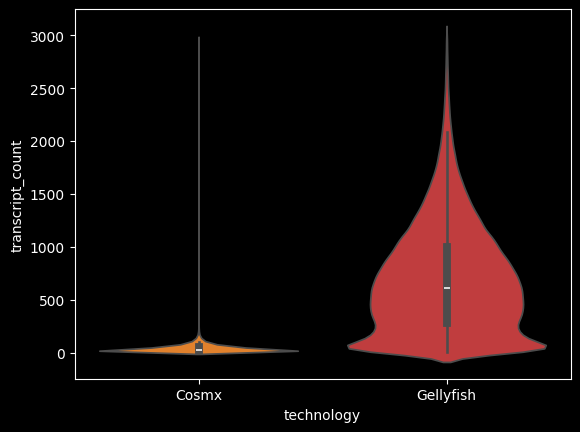

In [119]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df_revised, color = '0.8', palette = custom_colors)
#sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

In [120]:
print (f'Cosmx median number of genes per cell', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Cosmx']['transcript_count'].median())

Cosmx median number of genes per cell 28.0


In [121]:
print (f'Gellyfish median number of genes per cell', concated_overlap_violin_plot_df_revised[concated_overlap_violin_plot_df_revised['technology'] == 'Gellyfish']['transcript_count'].median())

Gellyfish median number of genes per cell 610.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


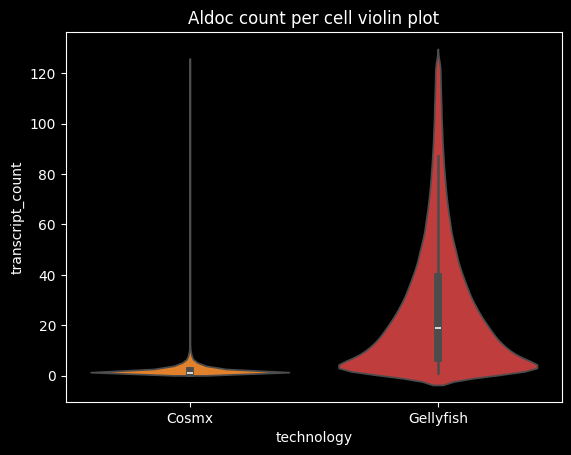

Cosmx median number of genes per cell - Aldoc: 1.0
Gellyfish median number of genes per cell - Aldoc: 19.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


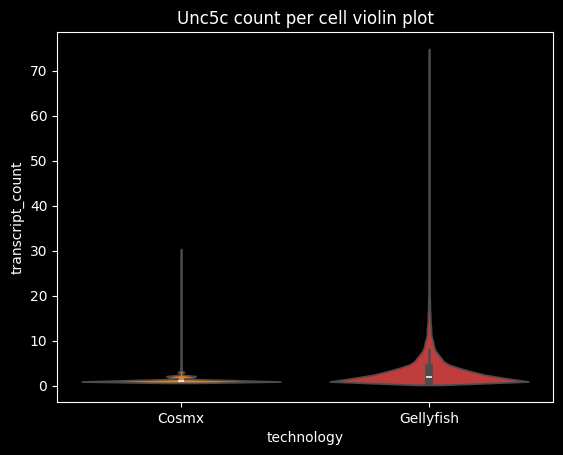

Cosmx median number of genes per cell - Unc5c: 1.0
Gellyfish median number of genes per cell - Unc5c: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


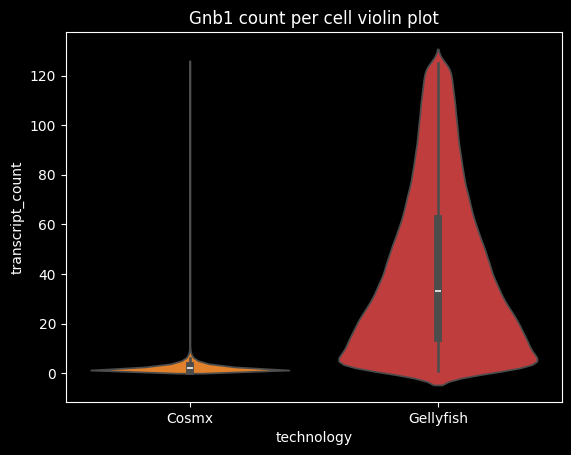

Cosmx median number of genes per cell - Gnb1: 2.0
Gellyfish median number of genes per cell - Gnb1: 33.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


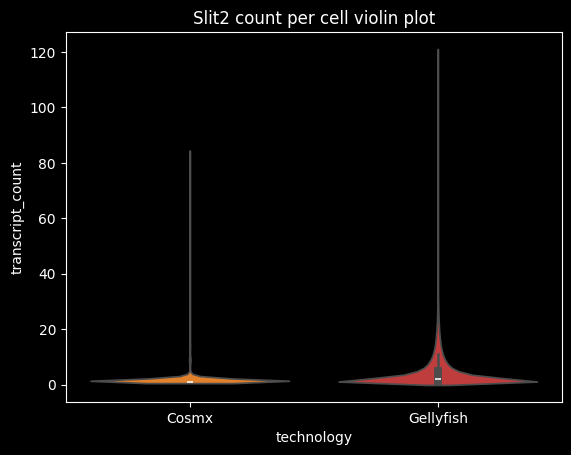

Cosmx median number of genes per cell - Slit2: 1.0
Gellyfish median number of genes per cell - Slit2: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


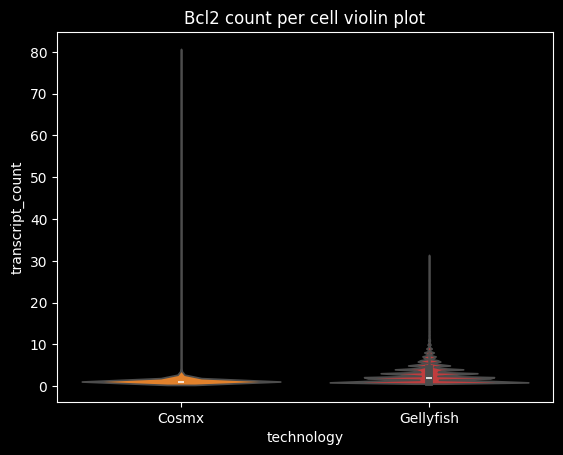

Cosmx median number of genes per cell - Bcl2: 1.0
Gellyfish median number of genes per cell - Bcl2: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


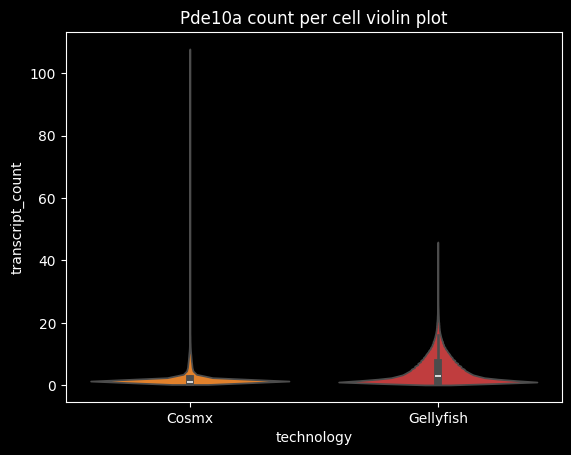

Cosmx median number of genes per cell - Pde10a: 1.0
Gellyfish median number of genes per cell - Pde10a: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


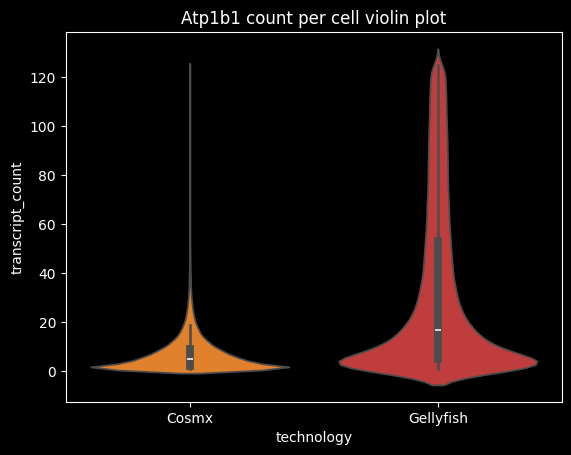

Cosmx median number of genes per cell - Atp1b1: 5.0
Gellyfish median number of genes per cell - Atp1b1: 17.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


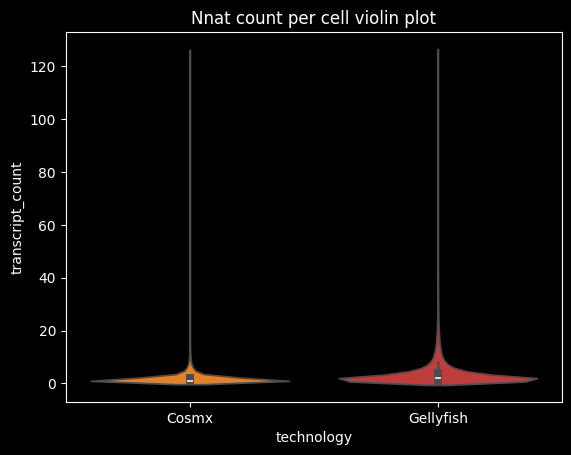

Cosmx median number of genes per cell - Nnat: 1.0
Gellyfish median number of genes per cell - Nnat: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


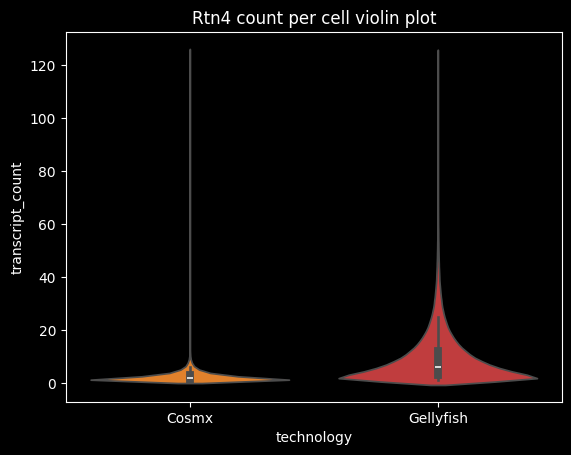

Cosmx median number of genes per cell - Rtn4: 2.0
Gellyfish median number of genes per cell - Rtn4: 6.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


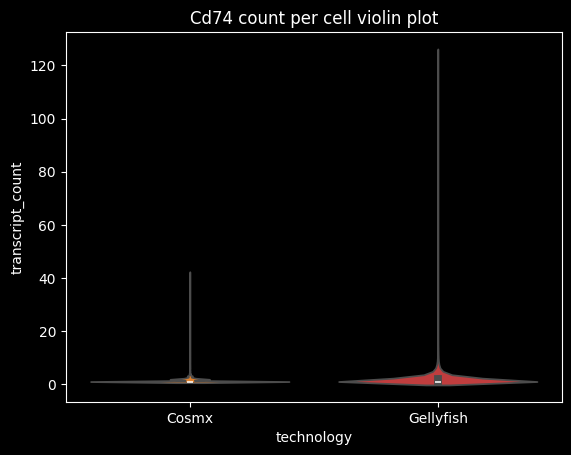

Cosmx median number of genes per cell - Cd74: 1.0
Gellyfish median number of genes per cell - Cd74: 1.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


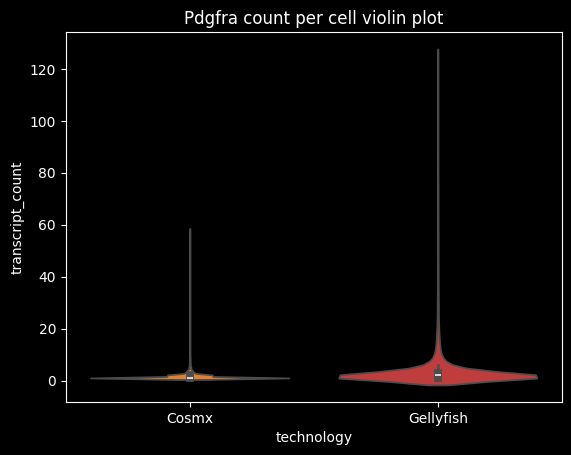

Cosmx median number of genes per cell - Pdgfra: 1.0
Gellyfish median number of genes per cell - Pdgfra: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


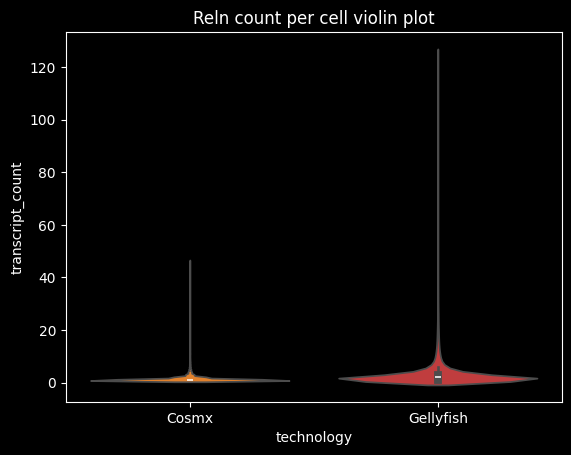

Cosmx median number of genes per cell - Reln: 1.0
Gellyfish median number of genes per cell - Reln: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


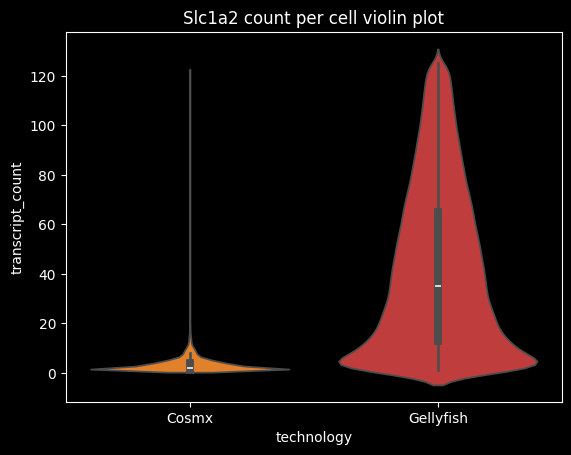

Cosmx median number of genes per cell - Slc1a2: 2.0
Gellyfish median number of genes per cell - Slc1a2: 35.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


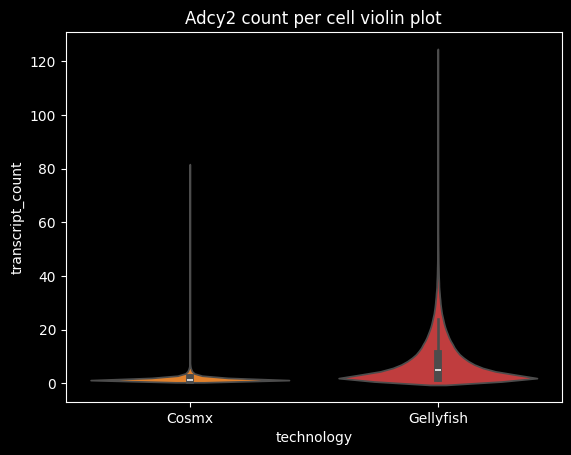

Cosmx median number of genes per cell - Adcy2: 1.0
Gellyfish median number of genes per cell - Adcy2: 5.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


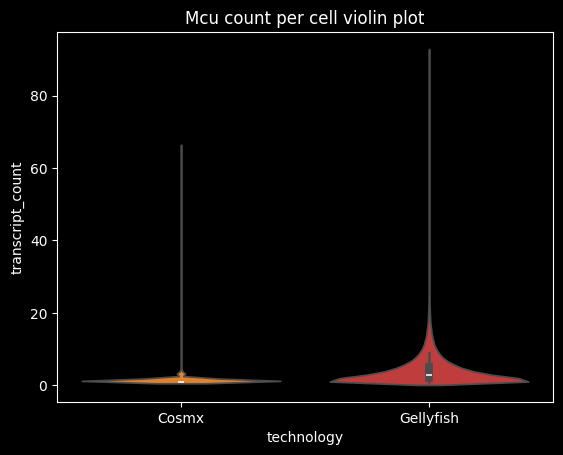

Cosmx median number of genes per cell - Mcu: 1.0
Gellyfish median number of genes per cell - Mcu: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


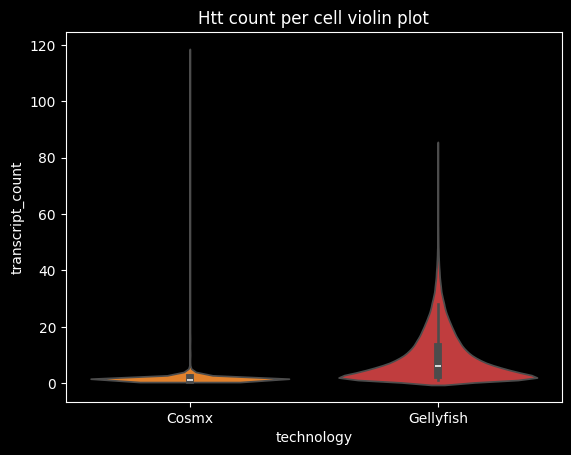

Cosmx median number of genes per cell - Htt: 1.0
Gellyfish median number of genes per cell - Htt: 6.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


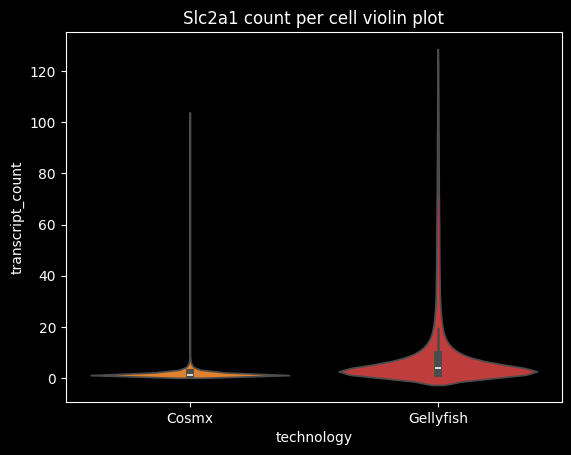

Cosmx median number of genes per cell - Slc2a1: 1.0
Gellyfish median number of genes per cell - Slc2a1: 4.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


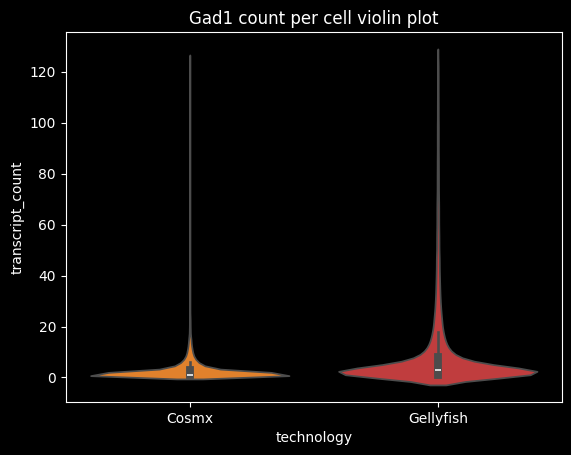

Cosmx median number of genes per cell - Gad1: 1.0
Gellyfish median number of genes per cell - Gad1: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


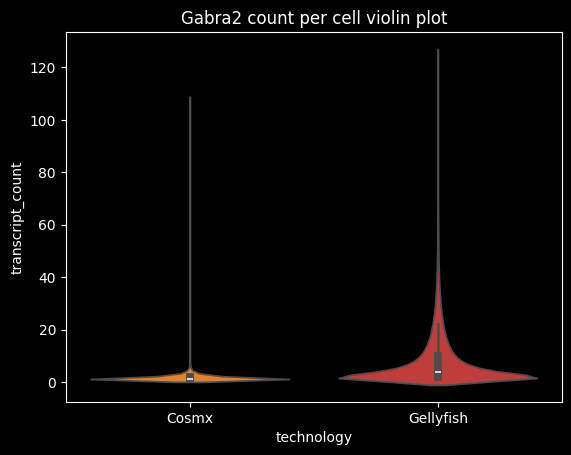

Cosmx median number of genes per cell - Gabra2: 1.0
Gellyfish median number of genes per cell - Gabra2: 4.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


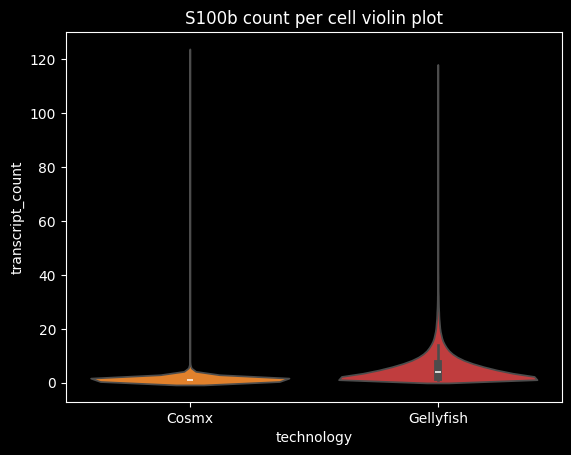

Cosmx median number of genes per cell - S100b: 1.0
Gellyfish median number of genes per cell - S100b: 4.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


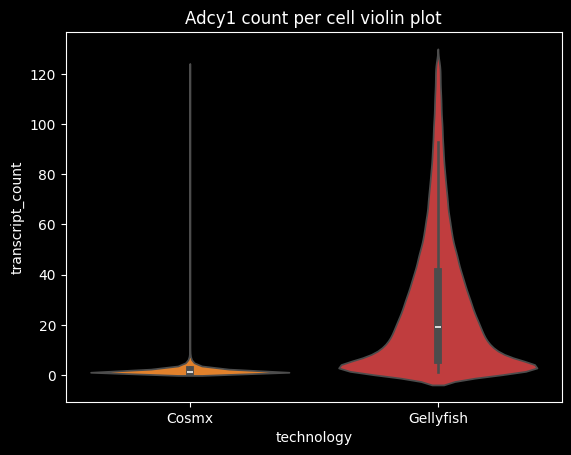

Cosmx median number of genes per cell - Adcy1: 1.0
Gellyfish median number of genes per cell - Adcy1: 19.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


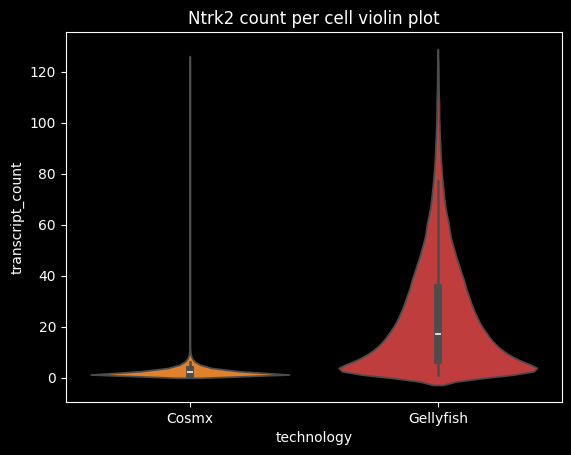

Cosmx median number of genes per cell - Ntrk2: 2.0
Gellyfish median number of genes per cell - Ntrk2: 17.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


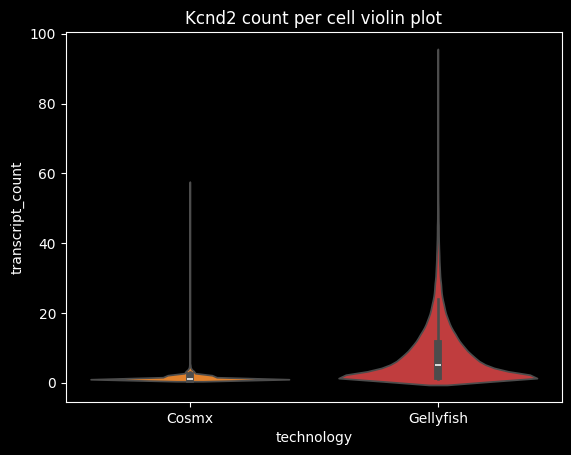

Cosmx median number of genes per cell - Kcnd2: 1.0
Gellyfish median number of genes per cell - Kcnd2: 5.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


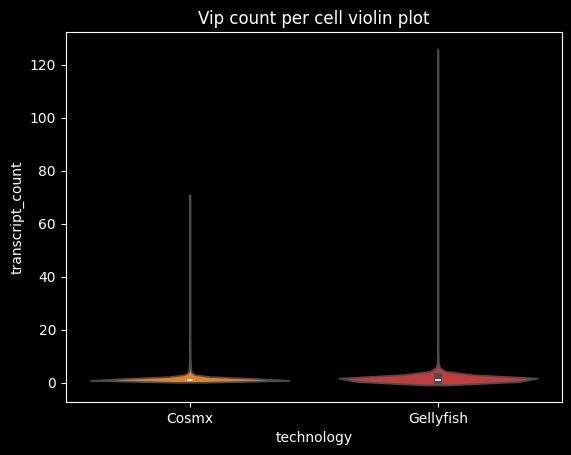

Cosmx median number of genes per cell - Vip: 1.0
Gellyfish median number of genes per cell - Vip: 1.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


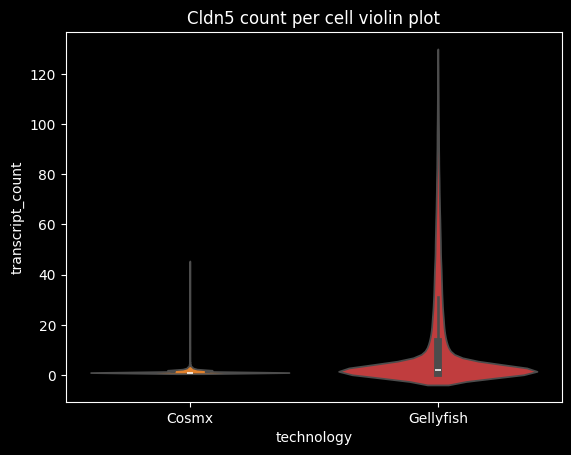

Cosmx median number of genes per cell - Cldn5: 1.0
Gellyfish median number of genes per cell - Cldn5: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


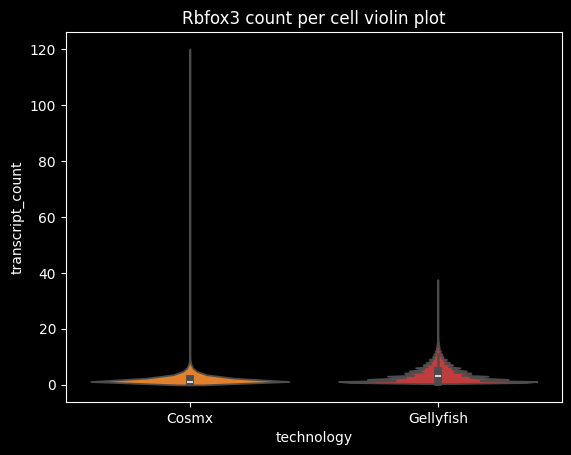

Cosmx median number of genes per cell - Rbfox3: 1.0
Gellyfish median number of genes per cell - Rbfox3: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


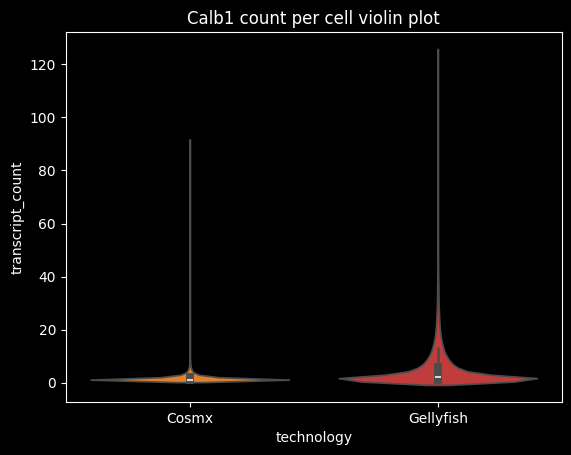

Cosmx median number of genes per cell - Calb1: 1.0
Gellyfish median number of genes per cell - Calb1: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


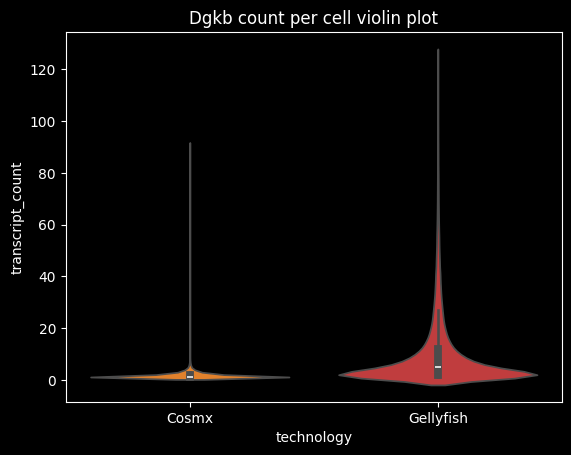

Cosmx median number of genes per cell - Dgkb: 1.0
Gellyfish median number of genes per cell - Dgkb: 5.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


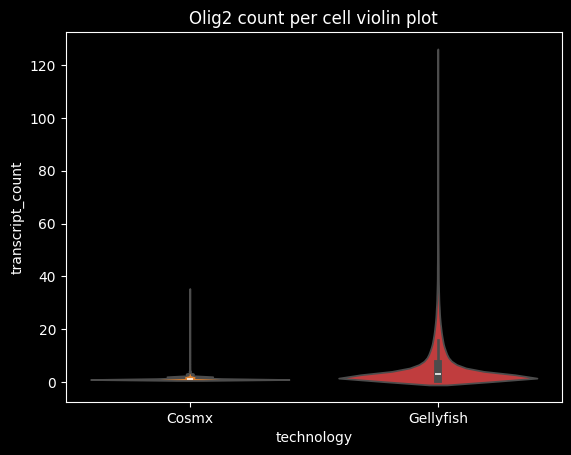

Cosmx median number of genes per cell - Olig2: 1.0
Gellyfish median number of genes per cell - Olig2: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


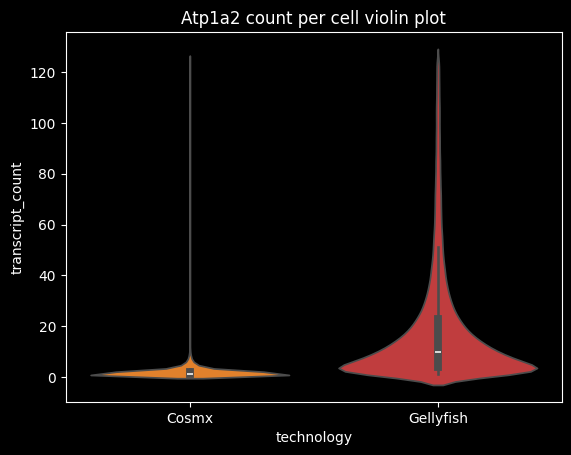

Cosmx median number of genes per cell - Atp1a2: 1.0
Gellyfish median number of genes per cell - Atp1a2: 10.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


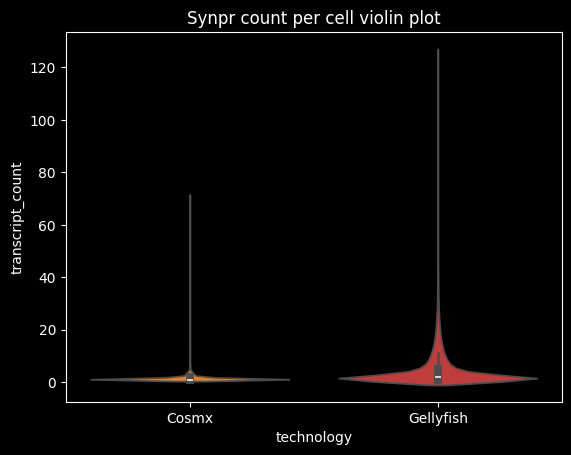

Cosmx median number of genes per cell - Synpr: 1.0
Gellyfish median number of genes per cell - Synpr: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


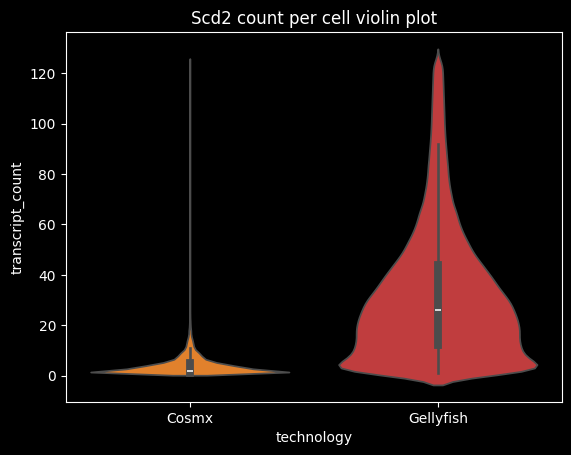

Cosmx median number of genes per cell - Scd2: 2.0
Gellyfish median number of genes per cell - Scd2: 26.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


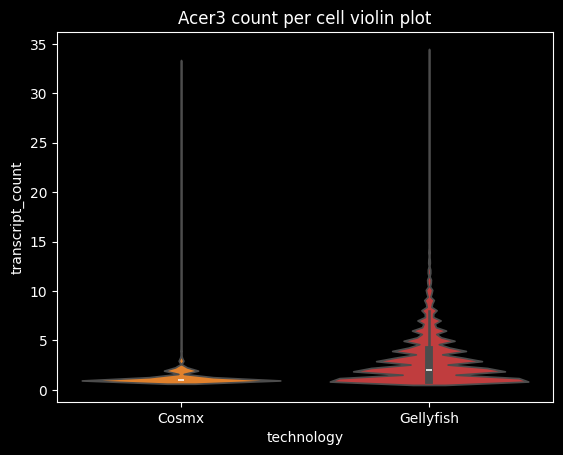

Cosmx median number of genes per cell - Acer3: 1.0
Gellyfish median number of genes per cell - Acer3: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


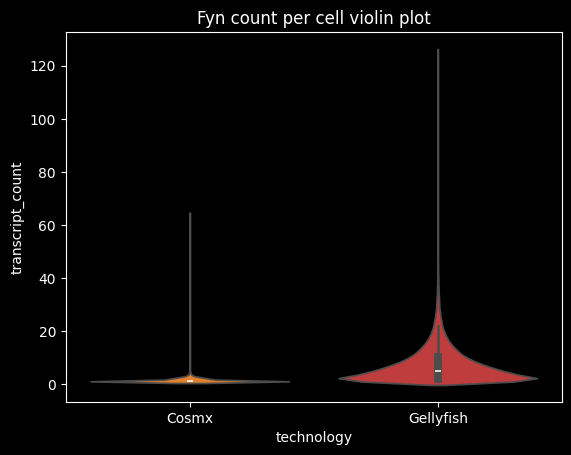

Cosmx median number of genes per cell - Fyn: 1.0
Gellyfish median number of genes per cell - Fyn: 5.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


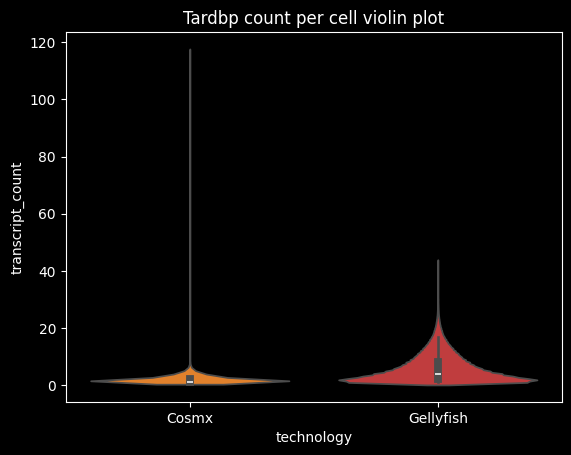

Cosmx median number of genes per cell - Tardbp: 1.0
Gellyfish median number of genes per cell - Tardbp: 4.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


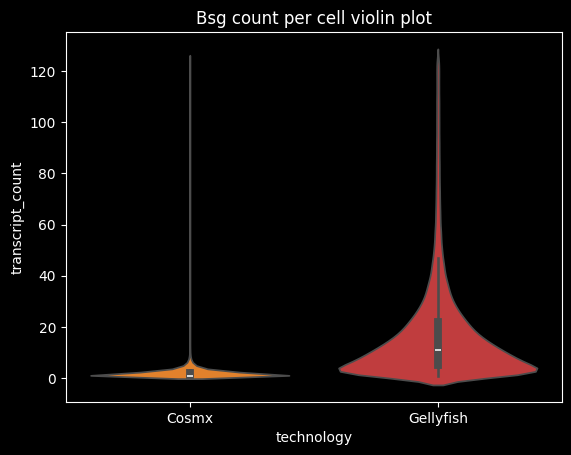

Cosmx median number of genes per cell - Bsg: 1.0
Gellyfish median number of genes per cell - Bsg: 11.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


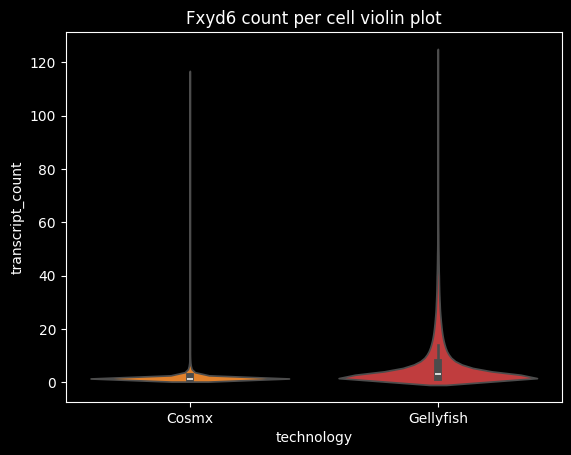

Cosmx median number of genes per cell - Fxyd6: 1.0
Gellyfish median number of genes per cell - Fxyd6: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


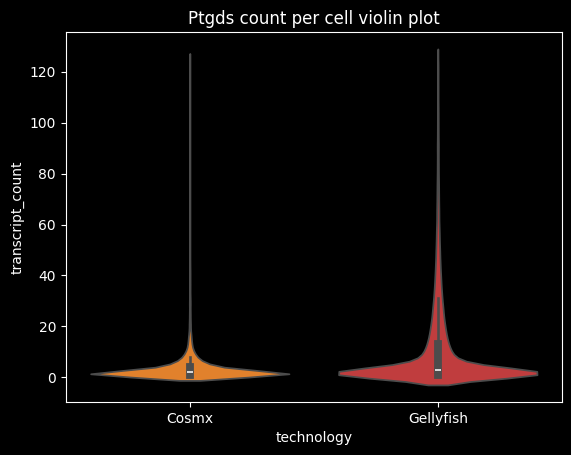

Cosmx median number of genes per cell - Ptgds: 2.0
Gellyfish median number of genes per cell - Ptgds: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


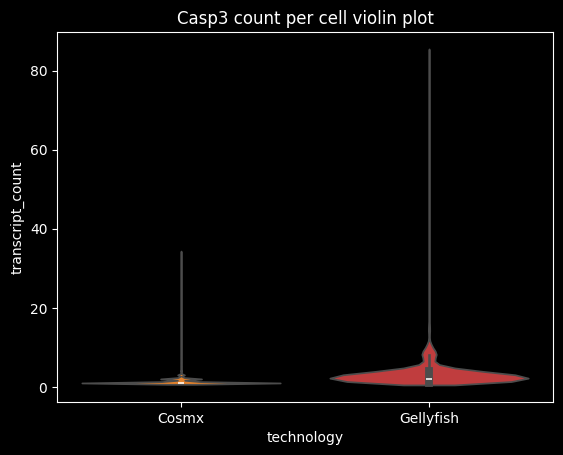

Cosmx median number of genes per cell - Casp3: 1.0
Gellyfish median number of genes per cell - Casp3: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


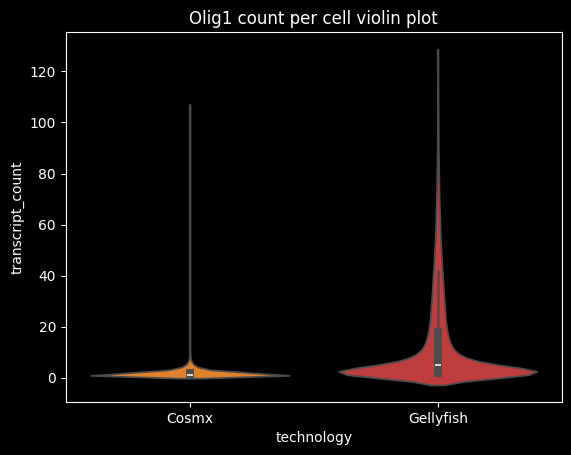

Cosmx median number of genes per cell - Olig1: 1.0
Gellyfish median number of genes per cell - Olig1: 5.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


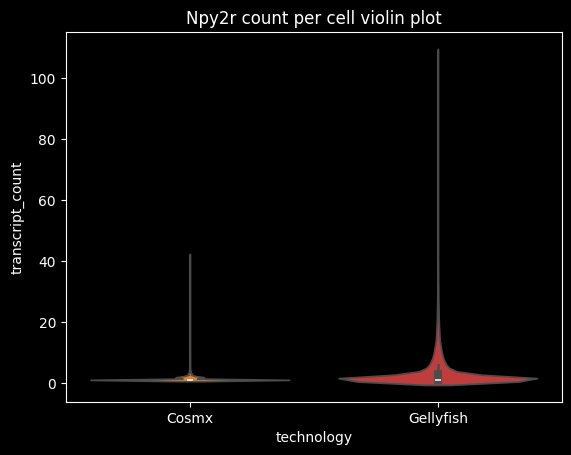

Cosmx median number of genes per cell - Npy2r: 1.0
Gellyfish median number of genes per cell - Npy2r: 1.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


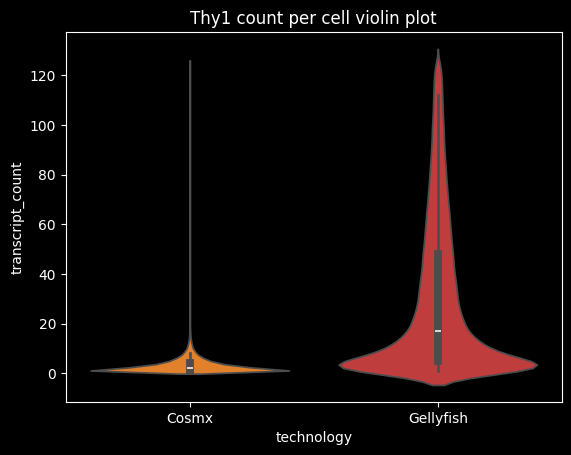

Cosmx median number of genes per cell - Thy1: 2.0
Gellyfish median number of genes per cell - Thy1: 17.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


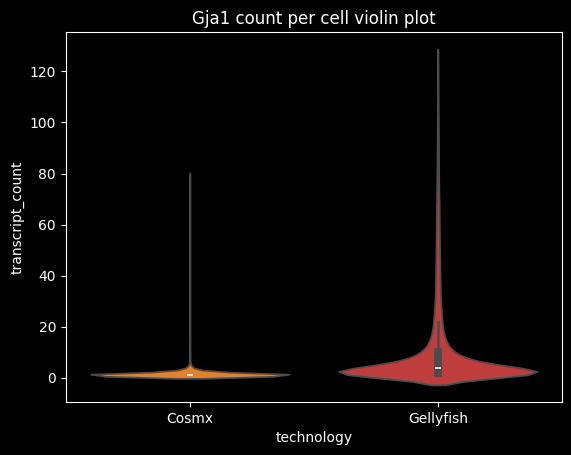

Cosmx median number of genes per cell - Gja1: 1.0
Gellyfish median number of genes per cell - Gja1: 4.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


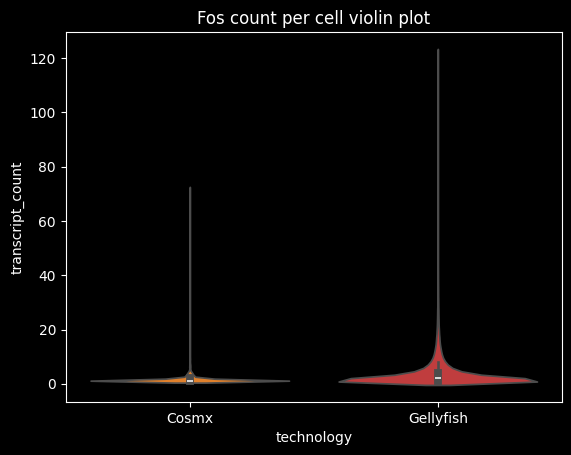

Cosmx median number of genes per cell - Fos: 1.0
Gellyfish median number of genes per cell - Fos: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


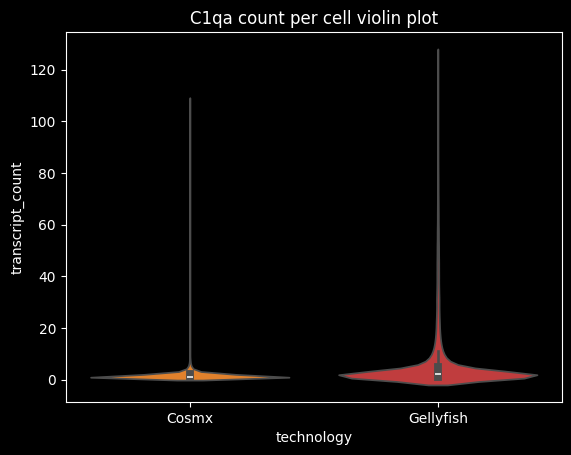

Cosmx median number of genes per cell - C1qa: 1.0
Gellyfish median number of genes per cell - C1qa: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


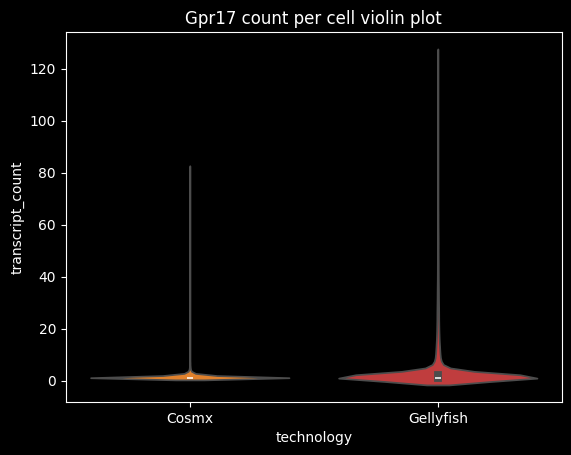

Cosmx median number of genes per cell - Gpr17: 1.0
Gellyfish median number of genes per cell - Gpr17: 1.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


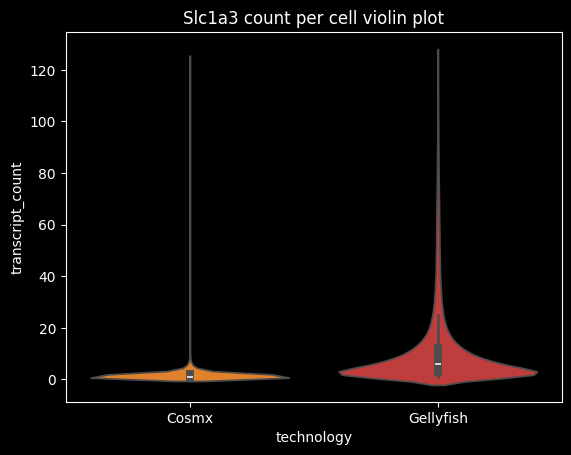

Cosmx median number of genes per cell - Slc1a3: 1.0
Gellyfish median number of genes per cell - Slc1a3: 6.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


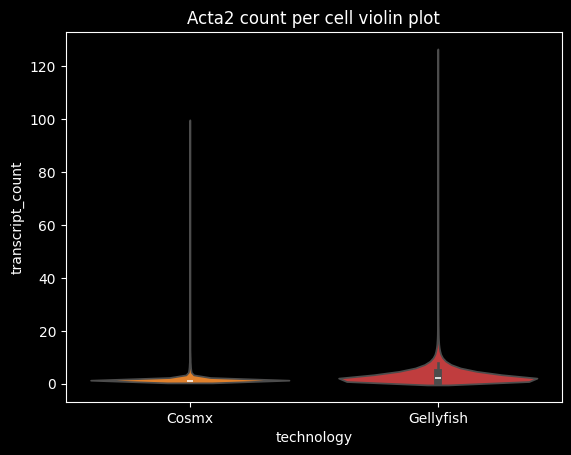

Cosmx median number of genes per cell - Acta2: 1.0
Gellyfish median number of genes per cell - Acta2: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


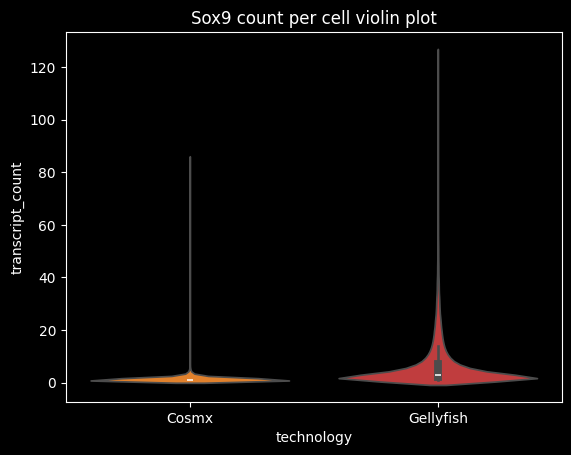

Cosmx median number of genes per cell - Sox9: 1.0
Gellyfish median number of genes per cell - Sox9: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


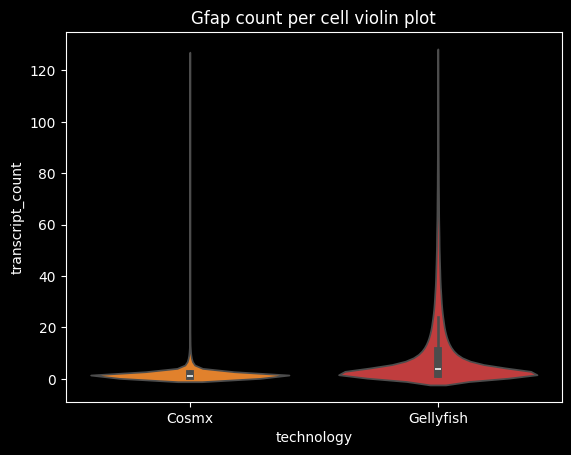

Cosmx median number of genes per cell - Gfap: 1.0
Gellyfish median number of genes per cell - Gfap: 4.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


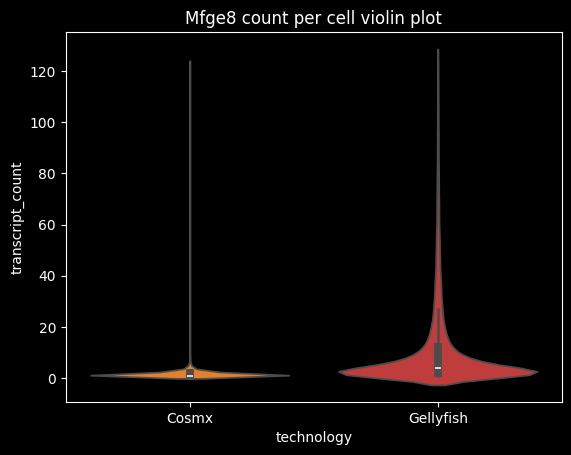

Cosmx median number of genes per cell - Mfge8: 1.0
Gellyfish median number of genes per cell - Mfge8: 4.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


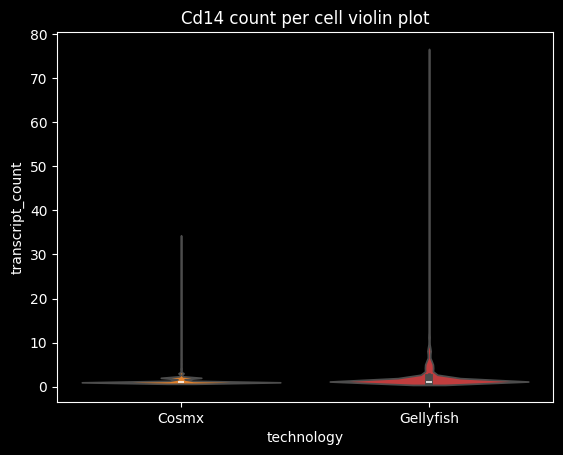

Cosmx median number of genes per cell - Cd14: 1.0
Gellyfish median number of genes per cell - Cd14: 1.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


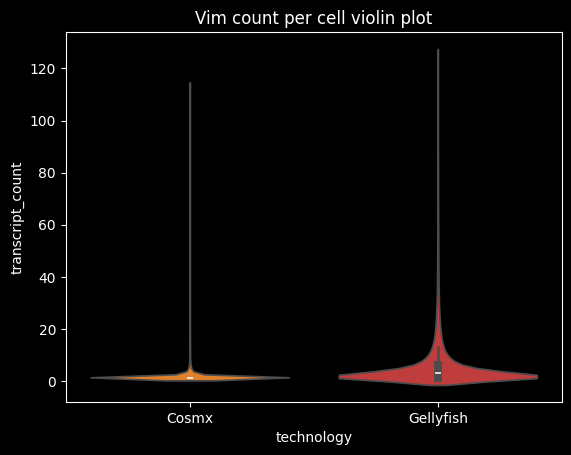

Cosmx median number of genes per cell - Vim: 1.0
Gellyfish median number of genes per cell - Vim: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


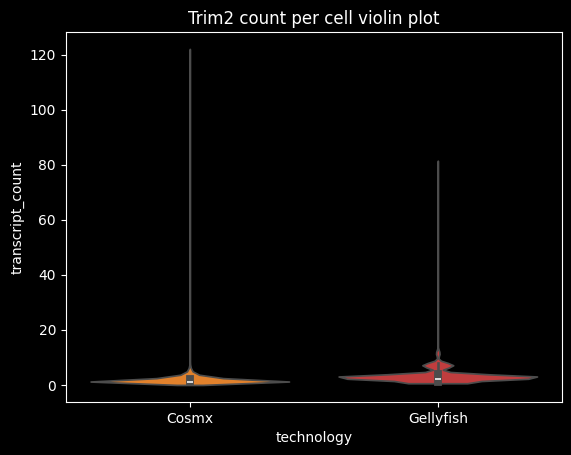

Cosmx median number of genes per cell - Trim2: 1.0
Gellyfish median number of genes per cell - Trim2: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


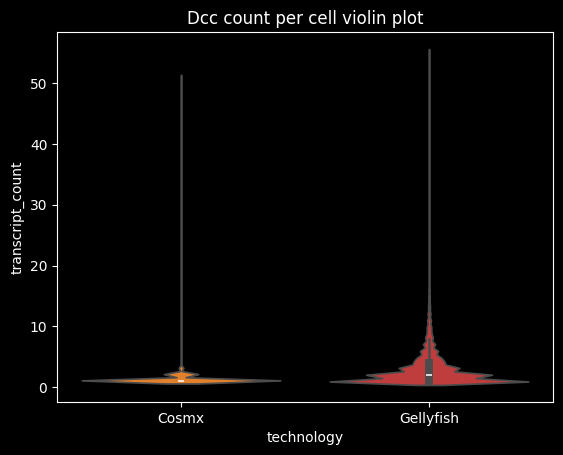

Cosmx median number of genes per cell - Dcc: 1.0
Gellyfish median number of genes per cell - Dcc: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


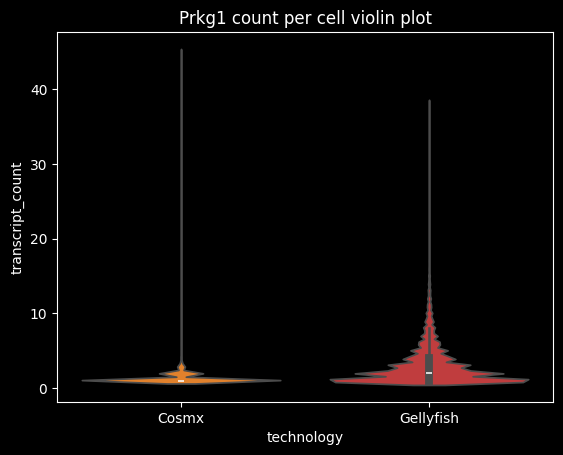

Cosmx median number of genes per cell - Prkg1: 1.0
Gellyfish median number of genes per cell - Prkg1: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


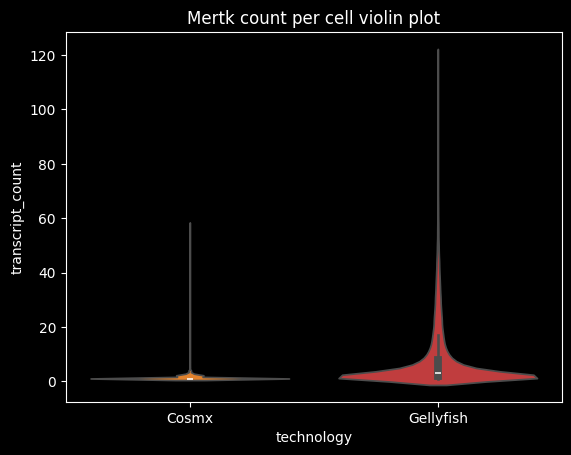

Cosmx median number of genes per cell - Mertk: 1.0
Gellyfish median number of genes per cell - Mertk: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


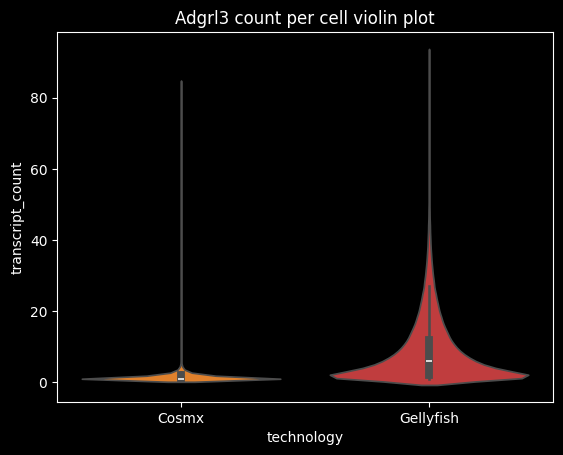

Cosmx median number of genes per cell - Adgrl3: 1.0
Gellyfish median number of genes per cell - Adgrl3: 6.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


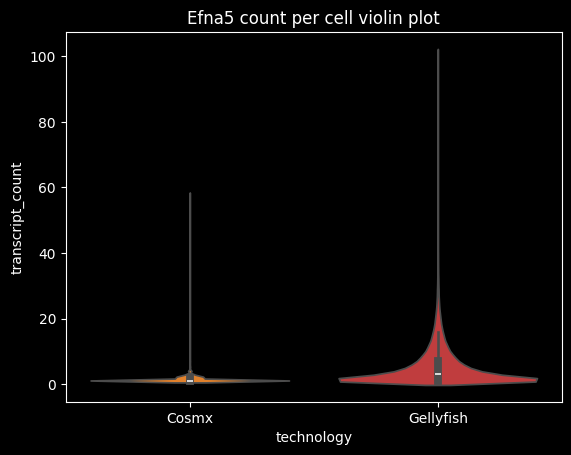

Cosmx median number of genes per cell - Efna5: 1.0
Gellyfish median number of genes per cell - Efna5: 3.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


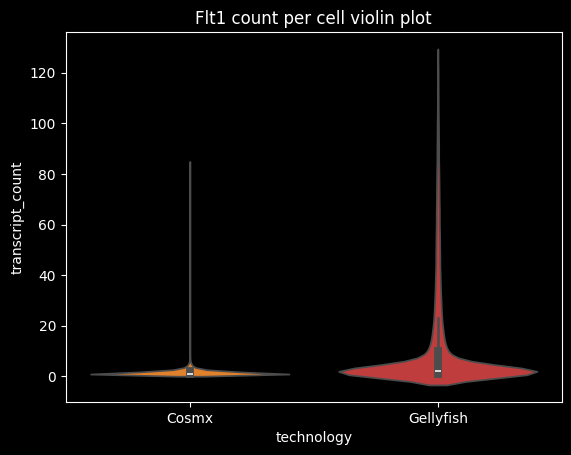

Cosmx median number of genes per cell - Flt1: 1.0
Gellyfish median number of genes per cell - Flt1: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


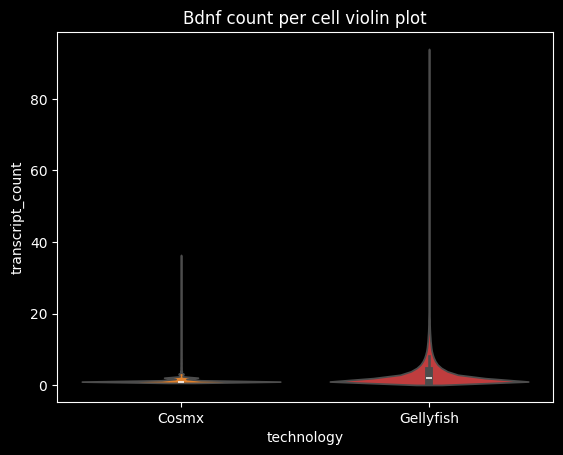

Cosmx median number of genes per cell - Bdnf: 1.0
Gellyfish median number of genes per cell - Bdnf: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


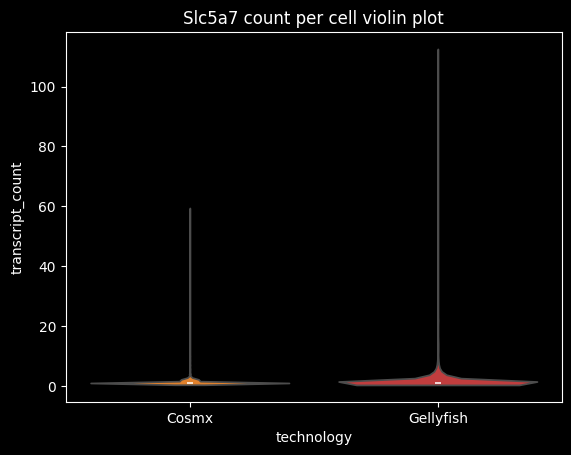

Cosmx median number of genes per cell - Slc5a7: 1.0
Gellyfish median number of genes per cell - Slc5a7: 1.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


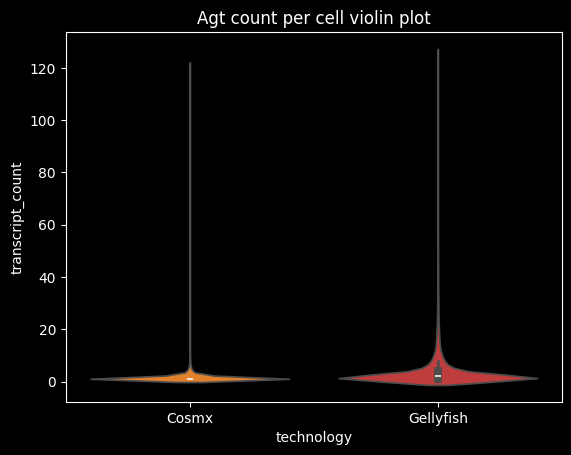

Cosmx median number of genes per cell - Agt: 1.0
Gellyfish median number of genes per cell - Agt: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


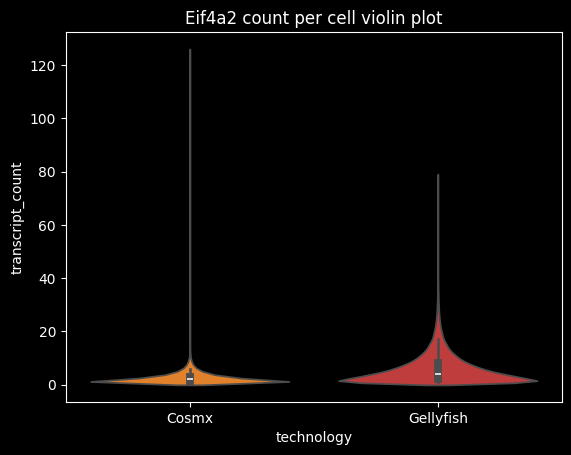

Cosmx median number of genes per cell - Eif4a2: 2.0
Gellyfish median number of genes per cell - Eif4a2: 4.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


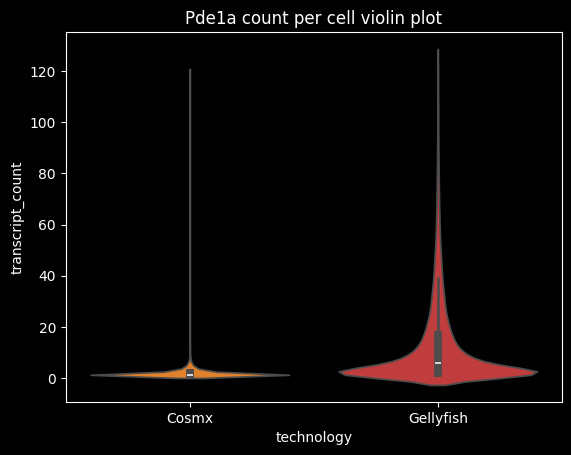

Cosmx median number of genes per cell - Pde1a: 1.0
Gellyfish median number of genes per cell - Pde1a: 6.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


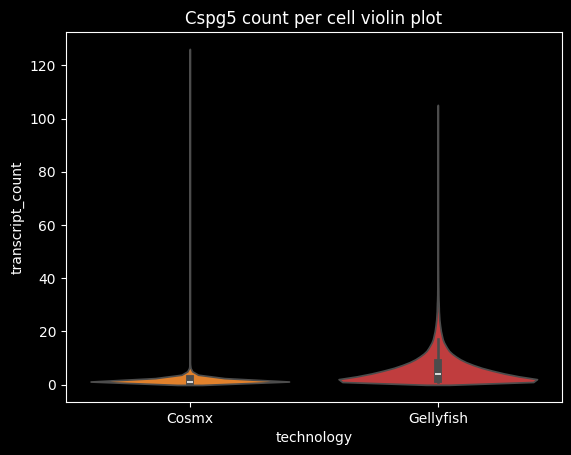

Cosmx median number of genes per cell - Cspg5: 1.0
Gellyfish median number of genes per cell - Cspg5: 4.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


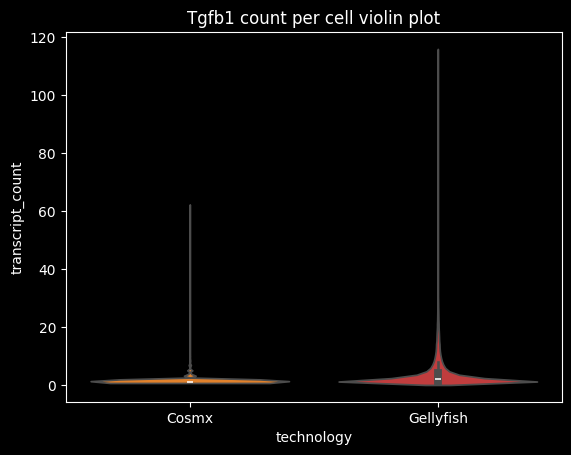

Cosmx median number of genes per cell - Tgfb1: 1.0
Gellyfish median number of genes per cell - Tgfb1: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


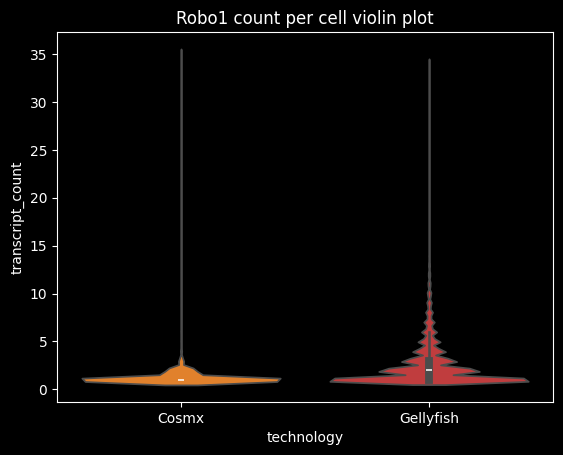

Cosmx median number of genes per cell - Robo1: 1.0
Gellyfish median number of genes per cell - Robo1: 2.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


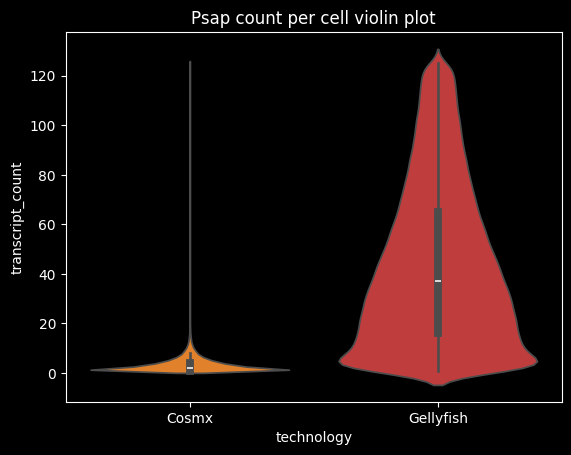

Cosmx median number of genes per cell - Psap: 2.0
Gellyfish median number of genes per cell - Psap: 37.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


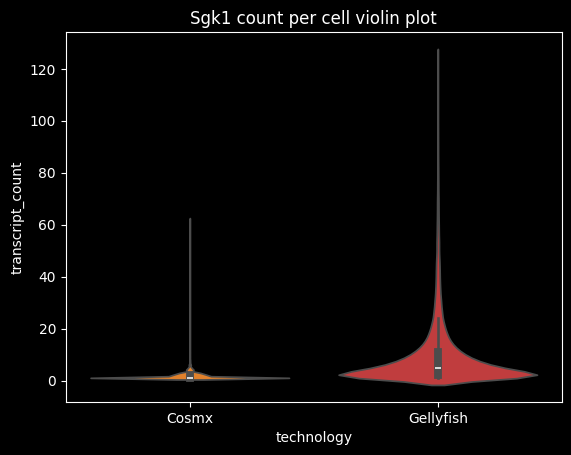

Cosmx median number of genes per cell - Sgk1: 1.0
Gellyfish median number of genes per cell - Sgk1: 5.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


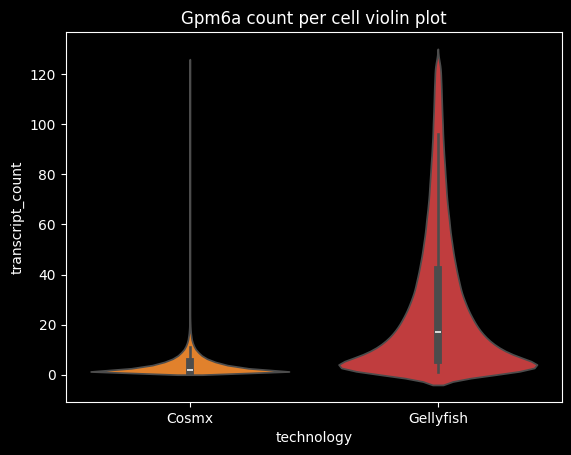

Cosmx median number of genes per cell - Gpm6a: 2.0
Gellyfish median number of genes per cell - Gpm6a: 17.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


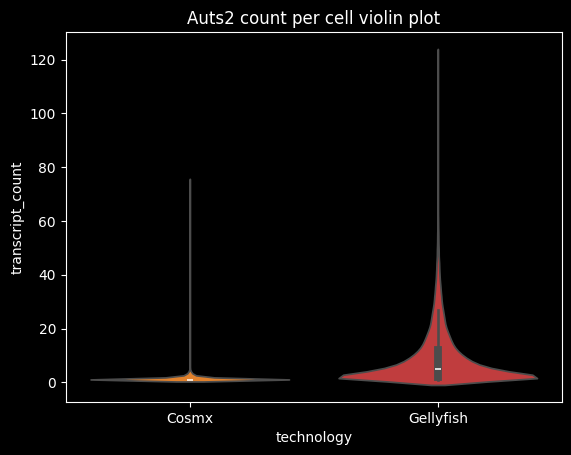

Cosmx median number of genes per cell - Auts2: 1.0
Gellyfish median number of genes per cell - Auts2: 5.0


C:\Users\krist\AppData\Local\Temp\ipykernel_26192\2870927283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


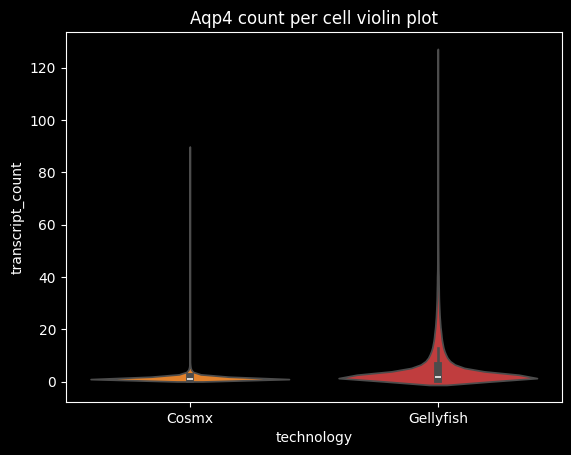

Cosmx median number of genes per cell - Aqp4: 1.0
Gellyfish median number of genes per cell - Aqp4: 2.0


In [122]:
for gene in cosmx_gellyfish_overlap_list:
    cosmx_overlap_filtered_gene = cosmx_overlap_filtered_gellyfish[gene][cosmx_overlap_filtered_gellyfish[gene] != 0]
    cosmx_overlap_gene_df = pd.DataFrame()
    cosmx_overlap_gene_df['transcript_count'] = cosmx_overlap_filtered_gene
    cosmx_overlap_gene_df['technology'] = 'Cosmx'
    
    gellyfish_overlap_filtered_gene = gellyfish_overlap_filtered_cosmx[gene][gellyfish_overlap_filtered_cosmx[gene] != 0]
    gellyfish_overlap_gene_df = pd.DataFrame()
    gellyfish_overlap_gene_df['transcript_count'] = gellyfish_overlap_filtered_gene
    gellyfish_overlap_gene_df['technology'] = 'Gellyfish'
    
    concated_df = pd.DataFrame()
    concated_df = pd.concat([cosmx_overlap_gene_df, gellyfish_overlap_gene_df], ignore_index = True)
    concated_df_revised = concated_df[concated_df['transcript_count'] <= 125]

    sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)
    #sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_df, jitter = True, size = 0.15)
    plt.title(f'{gene} count per cell violin plot')
    plt.show()
    
    print(f'Cosmx median number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Cosmx']['transcript_count'].median())
    print(f'Gellyfish median number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Gellyfish']['transcript_count'].median())

In [123]:
cosmx_gellyfish_overlap_list

['Aldoc',
 'Unc5c',
 'Gnb1',
 'Slit2',
 'Bcl2',
 'Pde10a',
 'Atp1b1',
 'Nnat',
 'Rtn4',
 'Cd74',
 'Pdgfra',
 'Reln',
 'Slc1a2',
 'Adcy2',
 'Mcu',
 'Htt',
 'Slc2a1',
 'Gad1',
 'Gabra2',
 'S100b',
 'Adcy1',
 'Ntrk2',
 'Kcnd2',
 'Vip',
 'Cldn5',
 'Rbfox3',
 'Calb1',
 'Dgkb',
 'Olig2',
 'Atp1a2',
 'Synpr',
 'Scd2',
 'Acer3',
 'Fyn',
 'Tardbp',
 'Bsg',
 'Fxyd6',
 'Ptgds',
 'Casp3',
 'Olig1',
 'Npy2r',
 'Thy1',
 'Gja1',
 'Fos',
 'C1qa',
 'Gpr17',
 'Slc1a3',
 'Acta2',
 'Sox9',
 'Gfap',
 'Mfge8',
 'Cd14',
 'Vim',
 'Trim2',
 'Dcc',
 'Prkg1',
 'Mertk',
 'Adgrl3',
 'Efna5',
 'Flt1',
 'Bdnf',
 'Slc5a7',
 'Agt',
 'Eif4a2',
 'Pde1a',
 'Cspg5',
 'Tgfb1',
 'Robo1',
 'Psap',
 'Sgk1',
 'Gpm6a',
 'Auts2',
 'Aqp4']

C:\Users\krist\AppData\Local\Temp\ipykernel_26192\3921103943.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)


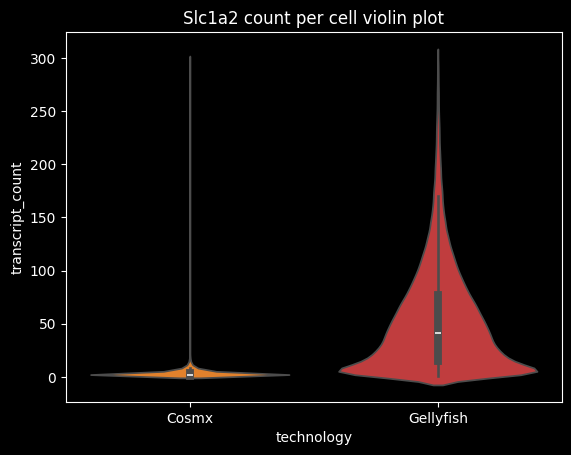

Cosmx median number of genes per cell - Slc1a2: 2.0
Gellyfish median number of genes per cell - Slc1a2: 41.0


In [124]:
for gene in ['Slc1a2']:
    cosmx_overlap_filtered_gene = cosmx_overlap_filtered_gellyfish[gene][cosmx_overlap_filtered_gellyfish[gene] != 0]
    cosmx_overlap_gene_df = pd.DataFrame()
    cosmx_overlap_gene_df['transcript_count'] = cosmx_overlap_filtered_gene
    cosmx_overlap_gene_df['technology'] = 'Cosmx'
    
    gellyfish_overlap_filtered_gene = gellyfish_overlap_filtered_cosmx[gene][gellyfish_overlap_filtered_cosmx[gene] != 0]
    gellyfish_overlap_gene_df = pd.DataFrame()
    gellyfish_overlap_gene_df['transcript_count'] = gellyfish_overlap_filtered_gene
    gellyfish_overlap_gene_df['technology'] = 'Gellyfish'
    
    concated_df = pd.DataFrame()
    concated_df = pd.concat([cosmx_overlap_gene_df, gellyfish_overlap_gene_df], ignore_index = True)
    concated_df_revised = concated_df[concated_df['transcript_count'] <= 300]

    sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df_revised, color = '0.8', palette = custom_colors)
    #sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_df, jitter = True, size = 0.15)
    plt.title(f'{gene} count per cell violin plot')
    plt.show()
    
    print(f'Cosmx median number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Cosmx']['transcript_count'].median())
    print(f'Gellyfish median number of genes per cell - {gene}:', concated_df_revised[concated_df_revised['technology'] == 'Gellyfish']['transcript_count'].median())

### Look at Vizgen and Gellyfish overlap

In [125]:
vizgen_gellyfish_overlap_list = list(gene_overlap_df_vizgen['genes'])
print(vizgen_gellyfish_overlap_list)

['Aqp4', 'Bdnf', 'Cspg5', 'Gabra1', 'Gad1', 'Gda', 'Mki67', 'Npy2r', 'Ntng1', 'Opalin', 'Pdgfra', 'Pnoc', 'Pou3f2', 'Sgk1', 'Synpr', 'Tmem108']


In [126]:
vizgen_overlap = gene_exp.loc[:, [gene for gene in gene_exp.columns if gene in vizgen_gellyfish_overlap_list]]
vizgen_overlap_filtered_gellyfish = vizgen_overlap[vizgen_overlap.sum(axis=1) != 0]
vizgen_overlap_filtered_gellyfish

gene                 Aqp4  Bdnf  Cspg5  Gabra1  Gad1  Gda  Mki67  Npy2r  \
cell_id                                                                   
2706017100030100136     1     0      2       2     0    0      0      0   
2706017100030100158     0     0      0       0     0    1      0      0   
2706017100082100076     0     0      0       0     0    0      0      0   
2706017100086100044     0     0      0       0     0    0      0      0   
2706017100086100053     0     0      0       0     0    1      0      0   
...                   ...   ...    ...     ...   ...  ...    ...    ...   
2706017104935100033     0     0      1       0     0    0      0      0   
2706017104937100234     0     0      0       0     0    0      0      0   
2706017104938100008     0     0      0       0     0    0      0      0   
2706017104991100417     0     0      0       0     0    0      0      0   
2706017104993100347     0     0      0       0     1    0      0      0   

gene                 Ntng1  Opalin  Pdgfra  Pnoc  Pou3f2  Sgk1  Synpr  Tmem108  
cell_id                                                                         
2706017100030100136      0       0       0     0       0     0      0        0  
2706017100030100158      0       0       0     0       0     0      0        0  
2706017100082100076      0       0       0     0       1     0      0        0  
2706017100086100044      0       0       1     0       0     0      0        0  
2706017100086100053      0       0       0     0       0     0      0        0  
...                    ...     ...     ...   ...     ...   ...    ...      ...  
2706017104935100033      0       0       0     0       0     0      0        0  
2706017104937100234      0       1       0     0       0     0      0        0  
2706017104938100008      0       0       0     0       0     1      0        0  
2706017104991100417      0       0       1     0       0     0      0        0  
2706017104993100347      0       0       0     0       0     0      0        0  

[160965 rows x 16 columns]

In [127]:
gellyfish_overlap = gellyfish_cell_df.loc[:, [gene for gene in cbm2_cell_df.columns if gene in vizgen_gellyfish_overlap_list]]
gellyfish_overlap_filtered_vizgen = gellyfish_overlap[gellyfish_overlap.sum(axis=1) != 0]
gellyfish_overlap_filtered_vizgen

Aqp4  Bdnf  Cspg5  Gabra1  Gad1  Gda  Mki67  Npy2r  Ntng1  Opalin  \
0         17     0      3       1     0    2      1      0      0       0   
1          0     0      6       7     0    0      0      2      2       0   
2          1     1      1       0     0    0      0      1      0       0   
3          3     7     21      18     1    0      3      2     38       0   
4          0     4     11       5     0    1      2     14     19       1   
...      ...   ...    ...     ...   ...  ...    ...    ...    ...     ...   
210753     0     0      1       0     0    9      0      0      0       1   
210754     0     0      1       2     0    1      0      0      0       0   
210755     0     0      0       1     0    8      0      0      0       0   
210756     0     0      1       2     0    3      0      0      0       0   
210759     0     0      1       0     0    0      0      0      0       1   

        Pdgfra  Pnoc  Pou3f2  Sgk1  Synpr  Tmem108  
0            0     0      12     0      1        0  
1            0     0       0     2      1        0  
2            0     0       0     6      1        0  
3            3     0       4     9      3        5  
4            2     1       1     7     12        0  
...        ...   ...     ...   ...    ...      ...  
210753       0     0       0     1      0        0  
210754       0     0       0     1      0        0  
210755       1     0       0     0      0        0  
210756       0     0       2     1      0        0  
210759       1     0       1     1      0        0  

[203305 rows x 16 columns]

In [128]:
vizgen_overlap_transcripts = vizgen_overlap_filtered_gellyfish.sum(axis = 1)
vizgen_overlap_violin_plot_df = pd.DataFrame()
vizgen_overlap_violin_plot_df['transcript_count'] = vizgen_overlap_transcripts
vizgen_overlap_violin_plot_df['technology'] = 'Vizgen'
vizgen_overlap_violin_plot_df

transcript_count technology
cell_id                                         
2706017100030100136                 5     Vizgen
2706017100030100158                 1     Vizgen
2706017100082100076                 1     Vizgen
2706017100086100044                 1     Vizgen
2706017100086100053                 1     Vizgen
...                               ...        ...
2706017104935100033                 1     Vizgen
2706017104937100234                 1     Vizgen
2706017104938100008                 1     Vizgen
2706017104991100417                 1     Vizgen
2706017104993100347                 1     Vizgen

[160965 rows x 2 columns]

In [129]:
gellyfish_overlap_transcripts = gellyfish_overlap_filtered_vizgen.sum(axis = 1)
gellyfish_overlap_violin_plot_df = pd.DataFrame()
gellyfish_overlap_violin_plot_df['transcript_count'] = gellyfish_overlap_transcripts
gellyfish_overlap_violin_plot_df['technology'] = 'Gellyfish'
gellyfish_overlap_violin_plot_df

transcript_count technology
0                     37  Gellyfish
1                     20  Gellyfish
2                     11  Gellyfish
3                    117  Gellyfish
4                     80  Gellyfish
...                  ...        ...
210753                12  Gellyfish
210754                 5  Gellyfish
210755                10  Gellyfish
210756                 9  Gellyfish
210759                 5  Gellyfish

[203305 rows x 2 columns]

In [130]:
concated_overlap_violin_plot_df = pd.DataFrame()
concated_overlap_violin_plot_df = pd.concat([vizgen_overlap_violin_plot_df, gellyfish_overlap_violin_plot_df], ignore_index = True)
concated_overlap_violin_plot_df

transcript_count technology
0                      5     Vizgen
1                      1     Vizgen
2                      1     Vizgen
3                      1     Vizgen
4                      1     Vizgen
...                  ...        ...
364265                12  Gellyfish
364266                 5  Gellyfish
364267                10  Gellyfish
364268                 9  Gellyfish
364269                 5  Gellyfish

[364270 rows x 2 columns]

In [131]:
concated_overlap_violin_plot_df_revised = concated_overlap_violin_plot_df[concated_overlap_violin_plot_df['transcript_count'] <= 400]
concated_overlap_violin_plot_df_revised

transcript_count technology
0                      5     Vizgen
1                      1     Vizgen
2                      1     Vizgen
3                      1     Vizgen
4                      1     Vizgen
...                  ...        ...
364265                12  Gellyfish
364266                 5  Gellyfish
364267                10  Gellyfish
364268                 9  Gellyfish
364269                 5  Gellyfish

[362017 rows x 2 columns]

In [132]:
custom_colors = ["#2ca02c","#d62728"]

C:\Users\krist\AppData\Local\Temp\ipykernel_26192\514788588.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df_revised, color = '0.8', palette = custom_colors)


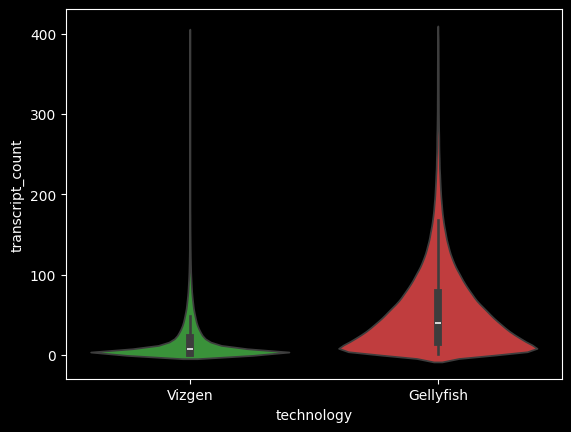

In [133]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df_revised, color = '0.8', palette = custom_colors)
#sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()